### Inverse Modelling: Demonstration of parameterisation of structure and history matching
#### Showcasing LoopStructural-Flopy to address Model Structure Uncertainty

This notebook uses a simple example to show how the pinchout of a formation at an unconformity can be included in uncertainty analysis using parameterisation and estimation of parameters and forecasting.


### 1. Project parameters

In [1]:
%run ./loop_showcase_functions.ipynb
#load from MODFLOW_tools (clone repo https://github.com/JimMcCallum/MODFLOW_Tools)
%run ../../MODFLOW_Tools/modelling_routines/modelling_routines.ipynb
%run ../../MODFLOW_Tools/meshing_routines/meshing_routines.ipynb
%run ../../MODFLOW_Tools/geomodel_routines/geomodel_routines.ipynb
%run ../../MODFLOW_Tools/loop2flopy/loop2flopy.ipynb
%run ../../MODFLOW_Tools/plotting_routines_USG/plotting_routines.ipynb

C:\Users\19904604\AppData\Local\Temp\ipykernel_21040\3209728366.py:21: DeprecationWarning: GeoPandas is set to use PyGEOS over Shapely. PyGEOS support is deprecatedand will be removed in GeoPandas 1.0, released in the Q1 of 2024. Please migrate to Shapely 2.0 (https://geopandas.org/en/stable/docs/user_guide/pygeos_to_shapely.html).
  import geopandas as gpd


Modelling routines loaded!
Meshing routines loaded!
Geomodel routines loaded!
loop2flopy routines loaded!
Plotting routines loaded!


In [2]:
P = Project('showcase', boundingbox = [0, 6000, 0, 6000, -500, 0]) # (x0, x1, y0, y1, z0, z1)

# ------------- DISCRETISATION PARAMETERS -----------------------#
P.triExeName = '../exe/triangle.exe'
P.workspace = '../modelfiles/'
P.crs = "epsg:28350" # Put in coordinate reference
P.xypumpbores = [(2000, 2000), (2500, 2000), (2000, 2500), (2500, 2500),] 
P.idpumpbores = ['P0','P1','P2','P3'] 
P.xyobsbores = [(1500,1000), (2500, 5000), (4000, 3000), (1500, 3500), (4500,4500)] 
P.idobsbores = ['OB1', 'OB2', 'OB3', 'OB4', 'OB5'] 
P.nobs = len(P.xyobsbores)
P.nzobs = 3
P.npump = len(P.xypumpbores)

P.r = 40        # refining factor for model boundary. High r has refined edges
P.w = 100      # Interior boundary
P.boundmaxtri = 30000 
P.modelmaxtri = 30000 # 10000 for ref
P.angle = 34   # minimum triangle angles

P.radius1 = 100 # radius of inner circle around pumping bores
P.radius2 = 200 # radius of outer circle around pumping bores
P.boremaxtri = 100000

# ------------- FLOW MODEL PARAMETERS -----------------------#
P.mfexe_name = '../exe/mf6.exe'

P.nlg = 4    # number of geological layers
P.nls = 2    # Number sublayers for conformable
P.geo_pl = 2 # Which geological layer pumping from (zero-based)
P.res = 2    # vertical resolution upon which voxel grid created to pick lithology bottoms

P.hk = [1.7, 0.07, 8.2, 0.05] 
P.vk = [0.12,0.007,0.51,0.005] 
P.ss = [0.00009, 0.00007, 0.00002, 0.00008]
P.sy = [0.12, 0.1, 0.1, 0.1]
reference = [P.hk, P.vk, P.ss, P.sy]
pickle.dump(reference, open('../results/reference.pkl','wb'))

P.rch = 0.4/365 # 0.0027 m/d
P.strt = 0.

P.chfunc = lambda x,z: -(0.005*x) - (z * 0.02)-20 # horizontal gradient of 0.01 and vertical gradient of 0.02
P.xt3d = True

past_years = 2
P.nts_past = past_years * 6
P.tdis_past = [(past_years * 365, P.nts_past, 1.1)] # period length, number of timesteps, tsmult
P.qwell_past = -2000 #m3/d 

future_years = 5
P.nts_future = future_years * 6
P.tdis_future = [(future_years * 365, P.nts_future, 1.1)] # period length, number of timesteps, tsmult
P.qwell_future = -5000 #m3/d 

#P.zobs = [-50, -100, -200]
   
vtk_workspace = '../vtk_files'
if not os.path.isdir(vtk_workspace):
    os.makedirs(vtk_workspace, exist_ok=True)
    
if not os.path.isdir('../results'):
    os.makedirs(workspace, exist_ok=True)
    

In [3]:
for i in P.hk: print(logfunc(i))
for i in P.vk: print(logfunc(i))
for i in P.ss: print(logfunc(i))

0.2304489213782739
-1.154901959985743
0.9138138523837167
-1.3010299956639813
-0.9208187539523752
-2.154901959985743
-0.2924298239020636
-2.3010299956639813
-4.045757490560675
-4.154901959985743
-4.698970004336019
-4.096910013008056


### 2. Meshing

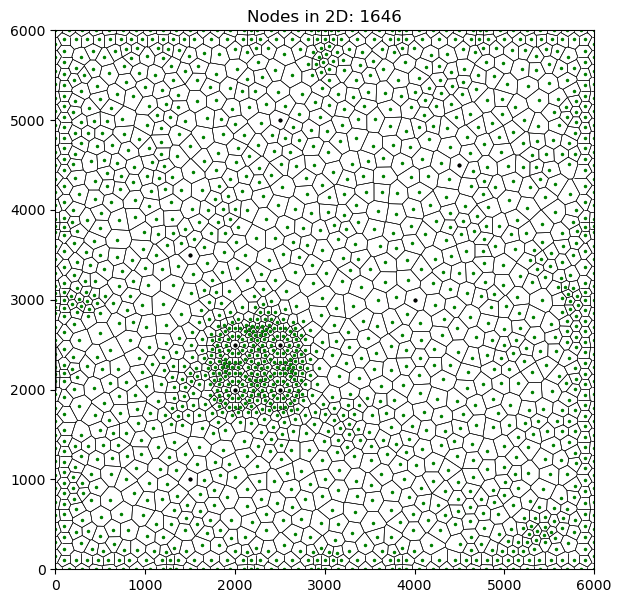

In [4]:
P.cell2dvor, P.xcycvor, P.verticesvor, P.vor, vornodes = createcell2d(P, grid = 'vor', fault = False)      
plot_cell2d_vor(P, xlim = [P.x0, P.x1], ylim = [P.y0, P.y1]) #xlim = [0, 3500], ylim = [0, 3500]

P.nlv  = 30  
P.delx, P.dely = 40, 40
P.ncol, P.nrow = int((P.x1 - P.x0) / P.delx), int((P.y1 - P.y0) / P.dely)
P.cell2dcar, P.xcyccar, P.verticescar, P.sg = createcell2d(P, grid = 'car', fault = False)    

### 3. Geological model (Reference)

In [5]:
P.control_points = ([])
data = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "inverse_example")
strat = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "strat")
P.data, P.strat = prepare_geomodel_loopshowcase(P, data, strat, include_fault = False)     # Prepare geomodel inputs
P.geomodel = create_geomodel_loopshowcase(P, include_fault = False) # Make geomodel

C:\Users\19904604\Anaconda3\envs\loopenv\lib\site-packages\skimage\util\dtype.py:27: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  np.bool8: (False, True),
C:\Users\19904604\Anaconda3\envs\loopenv\lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


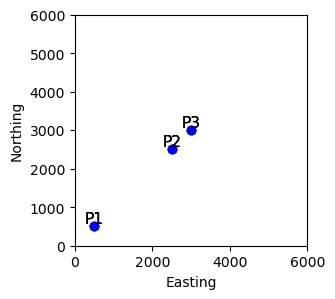

In [6]:
P.data
P.geomodel.feature_names()
plot_bores(P)

### 4. Flow model (Reference)

In [7]:
%run ../../MODFLOW_Tools/loop2flopy/loop2flopy.ipynb

# Initiate REFERENCE
R = Model('ref', P, plan = 'vor', transect = 'con') 
R.create_lith_dis_arrays(P)     # Create lithology and discretisation arrays (DIS)

loop2flopy routines loaded!
   Creating lithology and discretisation arrays for  ref  ...


In [8]:
P.wel_screens = []
for n in range(len(P.xypumpbores)):
    wel_icpl, wel_coords = find_cell_disv(P.xypumpbores[n][0], P.xypumpbores[n][1], R.xcyc)
    if P.geo_pl == 0:
        wel_top = R.top[wel_icpl]  
    else:   
        wel_top = R.botm[(P.geo_pl)* P.nls-1, wel_icpl]
    wel_bot = R.botm[(P.geo_pl + 1) * P.nls-1, wel_icpl]   
    print('Well coords ', wel_coords, ' Well screen top and bottom ', wel_top, wel_bot)
    P.wel_screens.append((wel_top, wel_bot))
    
P.zobs = np.zeros((P.nobs,P.nzobs))
for n in range(len(P.xyobsbores)):
    obs_icpl, obs_coords = find_cell_disv(P.xyobsbores[n][0], P.xyobsbores[n][1], R.xcyc) # Cell id in plan
    for m in range(3): # For the top three geological layers
        if m == 0:
            lay_top = R.top[obs_icpl]  
        else:   
            lay_top = R.botm[(m)* P.nls-1, obs_icpl]
        lay_bot = R.botm[(m + 1) * P.nls-1, obs_icpl]   
        obsz = lay_bot + (lay_top-lay_bot)/2
        P.zobs[n][m] = obsz
print('\nobservation depths')
print(P.zobs)

Well coords  (2000.0, 2000.0)  Well screen top and bottom  -186.0 -288.0
Well coords  (2500.0, 2000.0)  Well screen top and bottom  -164.0 -266.0
Well coords  (2000.0, 2500.0)  Well screen top and bottom  -164.0 -266.0
Well coords  (2500.0, 2500.0)  Well screen top and bottom  -148.0 -250.0

observation depths
[[ -25. -162. -326.]
 [ -25.  -50. -101.]
 [ -25.  -60. -121.]
 [ -25.  -99. -199.]
 [ -25.  -50.  -73.]]


In [9]:
R.create_prop_arrays(P)         # Create property arrays (NPF)
R.create_flow_package_arrays(P) # Create flow packages (CHD, RCH, IC, WEL, OBS)
print(R.modelname, ' has ', R.nnodes_div, ' nodes.')

   Creating property arrays for  ref  ...
   Adding flow packages to  ref  ...
   Time taken =  1.171622
ref  has  13168  nodes.


In [10]:
results = R.write_run_model(P, period = 'Steady', ic_array = P.strt)
R.gwf, R.head_ss, R.obs_ss, R.runtime_ss = results[0], results[1], results[2], results[-1]

   Writing simulation and gwf for  ref  ...
Period =  Steady 
   Model success =  True
   run_time =  15.430575


In [11]:
results = R.write_run_model(P, period = 'Past', ic_array = R.head_ss)
R.gwf, R.head_present, R.obs_present, R.runtime_past = results[0], results[1], results[2], results[-1]

   Writing simulation and gwf for  ref  ...
Period =  Past 
   Model success =  True
   run_time =  38.753659


In [12]:
results = R.write_run_model(P, period = 'Future', ic_array = R.head_present)
R.gwf, R.head_future, R.obs_future, R.runtime_future = results[0], results[1], results[2], results[-1]

   Writing simulation and gwf for  ref  ...
Period =  Future 
   Model success =  True
   run_time =  83.185529


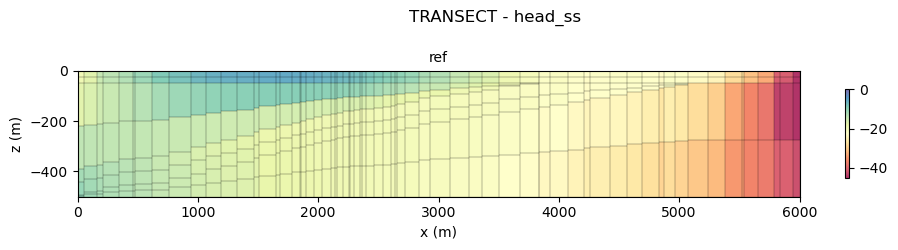

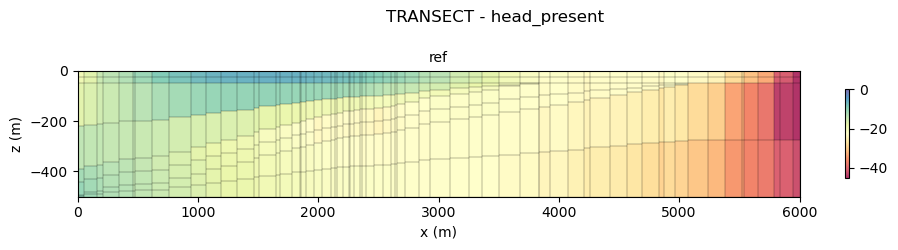

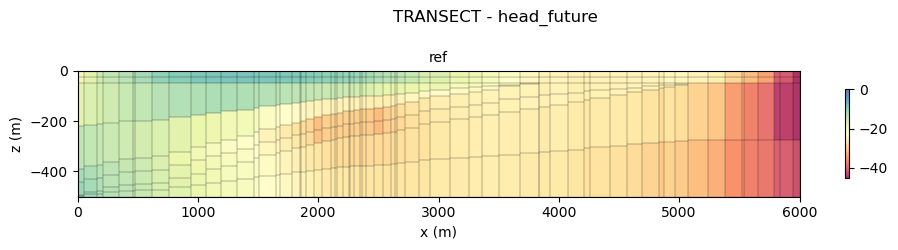

In [13]:
multiplot_prop_transect(P, models = [R], array = 'head_ss', 
                        X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1,
                        vmin = -45, vmax = 0)
multiplot_prop_transect(P, models = [R], array = 'head_present', 
                        X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1,
                        vmin = -45, vmax = 0)
multiplot_prop_transect(P, models = [R], array = 'head_future', 
                        X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1, 
                        vmin = -45, vmax = 0)

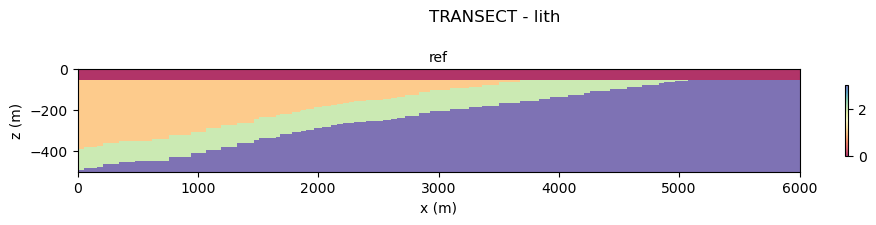

In [14]:
multiplot_vgrid_transect(P, models = [R], array = 'lith', X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1) 

In [15]:
#f = os.path.join(vtk_workspace, "test", R.modelname)
#R.gwf.export(f, fmt="vtk")

In [16]:
#plot_flow_features(P, [R])
#multiplot_prop_transect(P, models = [R], array = 'logk11', X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1)

In [17]:
#y_ = [1000,1500,2000,2500,3000,4000,5000]
#for y in y_:
#    multiplot_prop_transect(P, models=[R], array ='head_future',X0=P.x0, Y0=y, X1=P.x1, Y1=y, vmin = -45, vmax = 0)

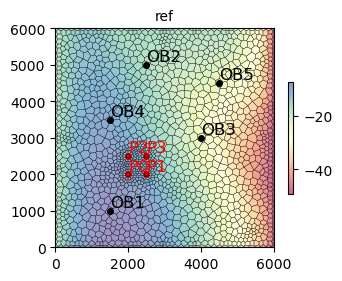

In [18]:
plot_bylayer(P, models = [R], layer = 1)#, vmin = -20, vmax = 5) 

In [19]:
#multiplot_prop_plan(P, models = [R], array = 'k11', layer = 3)#, vmin = None, vmax = None):   # array needs to be a string of a property eg. 'k11', 'logk11'  


### Testing convergence

In [20]:
#loghk0, loghk1, loghk2, loghk3 = 0.27972511989404736, -1.9442518204215036, 0.38322898929495725, -1.2905279279633497
#logvk0, logvk1, logvk2, logvk3 =  -0.5824396583949223, -2.4754872268614063, -0.3344909931386087, -2.640047841390039
#logss1, logss2, logss3 = -4.517405710106817, -4.610738280002378, -4.712335701038782
#sy0 =  0.11386417979259696
#cp =  -160.4664408080099
#
#P.hk = [10**loghk0, 10**loghk1, 10**loghk2, 10**loghk3]
#P.vk = [10**logvk0, 10**logvk1, 10**logvk2, 10**logvk3]
#P.ss = [0.00009, 10**logss1, 10**logss2, 10**logss3]
#P.sy = [sy0, 0.1, 0.1, 0.1]
#
## Initiate TEST
#P.control_points = (['CP1', 'control', 3000, 3000, cp, -200, 'c', 'lower', np.nan, np.nan, np.nan],) 
#P.data, P.strat = prepare_geomodel_loopshowcase(P, data, strat, include_fault = False)   # Prepare geomodel inputs
#P.geomodel = create_geomodel_loopshowcase(P, include_fault = False)
#T = Model('test', P, plan = 'vor', transect = 'con') 
#T.create_lith_dis_arrays(P)     # Create lithology and discretisation arrays (DIS)
#T.create_prop_arrays(P)         # Create property arrays (NPF)
#T.create_flow_package_arrays(P) # Create flow packages (CHD, RCH, IC, WEL, OBS)
#print(T.modelname, ' has ', T.ncell_disu, ' nodes.')
#
#T.gwf, T.head_ss, T.obs_ss, T.runtime_ss = T.write_run_model(P, period = 'Steady', ic_array = P.strt) 
#T.gwf, T.head_present, T.obs_present, T.runtime_past = T.write_run_model(P, period = 'Past', ic_array = T.head_ss)
#T.gwf, T.head_future, T.obs_future, T.runtime_future = T.write_run_model(P, period = 'Future', ic_array = T.head_present)
#
#T.angle2_disu = T.gwf.npf.angle2.array
#multiplot_prop_transect(P, models = [T], array = 'angle2_disu', X0=P.x0, Y0=P.y0, X1=P.x1, Y1=P.y1)

In [21]:
def plot_problem_cell(P, gwf, X, Y, Z, vmin = None, vmax = None): # array needs to be a string of a property eg. 'k11', 'angle2'
    a = gwf.npf.k.get_data()
    fig = plt.figure(figsize = (10,3))
    ax = plt.subplot(121)
    ax.set_title("West-East Transect\nY = %i" %(Y))
    xsect = flopy.plot.PlotCrossSection(modelgrid=gwf.modelgrid, line={"line": [(P.x0, Y),(P.x1, Y)]},
                                        geographic_coords=True)
    csa = xsect.plot_array(a = a, cmap = 'Spectral', alpha=0.8, vmin = vmin, vmax = vmax)
    ax.plot(X, Z, 'o', color = 'red')
    ax.set_xlabel('x (m)', size = 10)
    ax.set_ylabel('z (m)', size = 10)
    linecollection = xsect.plot_grid(lw = 0.1, color = 'black') 
    
    ax = plt.subplot(122)
    ax.set_title("South-North Transect\nX = %i" %(X))
    xsect = flopy.plot.PlotCrossSection(modelgrid=gwf.modelgrid, line={"line": [(X, P.y0),(X, P.y1)]},
                                        geographic_coords=True)
    csa = xsect.plot_array(a = a, cmap = 'Spectral', alpha=0.8, vmin = vmin, vmax = vmax)
    ax.plot(Y, Z, 'o', color = 'red')
    ax.set_xlabel('y (m)', size = 10)
    ax.set_ylabel('z (m)', size = 10)
    #ax.set_xlim([1000, 3000])
    #ax.set_ylim([-68, -48])
    linecollection = xsect.plot_grid(lw = 0.1, color = 'black') 
    
    fig = plt.figure(figsize = (6,6))
    ax = plt.subplot(111)
    ax.set_title("Plan")
    mapview = flopy.plot.PlotMapView(modelgrid=gwf.modelgrid, layer = 0)#, geographic_coords=True)
    plan = mapview.plot_array(a = a, cmap = 'Spectral', alpha=0.8, vmin = vmin, vmax = vmax)
    ax.plot(X, Y, 'o', color = 'red')
    ax.set_xlabel('x (m)', size = 10)
    ax.set_ylabel('y (m)', size = 10)
    linecollection = mapview.plot_grid(lw = 0.1, color = 'black') 
    
    #plt.colorbar(csa, shrink = 0.7)
    plt.tight_layout()  
    plt.show()  

In [22]:
#node = 2731-1
#sim = flopy.mf6.MFSimulation.load(sim_name = 'sim', sim_ws = '../modelfiles')
#gwf = sim.get_model('test')
#
#print("minimum cell thickness = %f at node %i" %(T.gwf.modelgrid.thick.min(), T.gwf.modelgrid.thick[node]))
#
#X = T.gwf.modelgrid.xyzcellcenters[0][node]
#Y = T.gwf.modelgrid.xyzcellcenters[1][node]
#Z = T.gwf.modelgrid.xyzcellcenters[2][0][node]
#print("XYZ problem = ", X,Y,Z)
#
#xv = T.gwf.modelgrid.xyzvertices[0][node]
#yv = T.gwf.modelgrid.xyzvertices[1][node]
#zv_top = T.gwf.modelgrid.xyzvertices[2][0][node]
#zv_bot = T.gwf.modelgrid.xyzvertices[2][1][node]
#xv, yv, zv_top, zv_bot
#print('cell width approx ', max(xv) - min(xv))
#print('cell length approx ', max(yv) - min(yv))
#print('cell thickness', zv_top - zv_bot)
#
#plot_problem_cell(P, T.gwf, X=X, Y=Y, Z=Z)

### 14. Create "truth" observations and plot observations

In [23]:
R.ref_steady  = process_obs_steady(P, R)
R.ref_past    = process_obs_past(P, R)
R.ref_future  = process_obs_future(P, R)

In [24]:
if not os.path.isdir('../results'):
    os.makedirs(workspace, exist_ok=True)
    
fname = '../results/ref_ss.pkl'
pickle.dump(R.ref_steady, open(os.path.join(P.workspace, fname),'wb'))
fname = '../results/ref_past.pkl'
pickle.dump(R.ref_past, open(os.path.join(P.workspace, fname),'wb'))
fname = '../results/ref_future.pkl'
pickle.dump(R.ref_future, open(os.path.join(P.workspace, fname),'wb'))

In [25]:
# Get times
csv_file = os.path.join(P.workspace, R.modelname + "_past.csv")
data_set = pd.read_csv(csv_file, header=0)
df = pd.DataFrame(data_set)
times_past = df.iloc[:,0]/365

csv_file = os.path.join(P.workspace, R.modelname + "_future.csv")
data_set = pd.read_csv(csv_file, header=0)
df = pd.DataFrame(data_set)
times_future = df.iloc[:,0]/365+2

Text(0, 0.5, 'Head (m)')

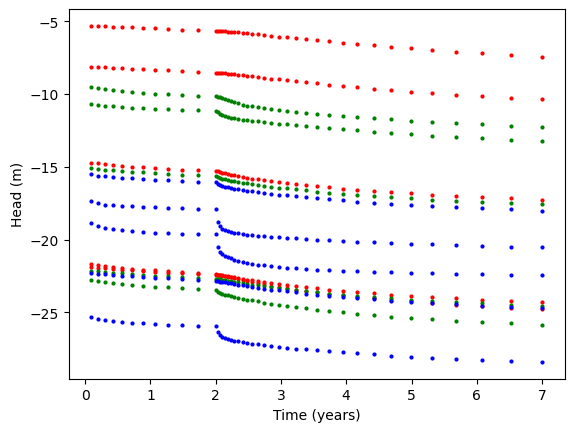

In [26]:
colors = ['red','green','blue']
R.ref_future.shape
for j in range(P.nobs):
    for i in range(P.nzobs):
        plt.plot(times_past, R.ref_past[j][i],'o', ms = 2, color = colors[i])
        plt.plot(times_future, R.ref_future[j][i],'o', ms = 2, color = colors[i])
plt.xlabel('Time (years)')
plt.ylabel('Head (m)')

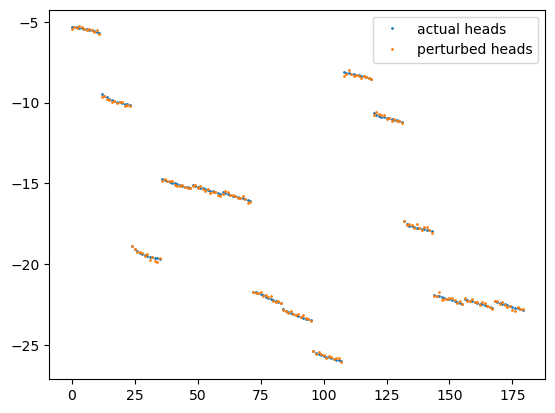

In [27]:
# CREATE SYNTHETIC OBSERVATIONS BY PERTURBING ACTUAL HEADS
err = 0.1
hobs_ref = np.copy(R.ref_past)    
for i in range(P.nobs):
    for j in range(P.nzobs):
        for k in range(hobs_ref.shape[2]):
            hobs_ref[i][j][k] += np.random.normal(0.,err) # Perturb samples either side of measurement
plt.plot(R.ref_past.flatten(), 'o', ms = 1, label = 'actual heads')
plt.plot(hobs_ref.flatten(),'o', ms = 1, label = 'perturbed heads')
plt.legend()

### 15. Set up Markov Chain Monte Carlo (MCMC)

#### Define statistics of parameters

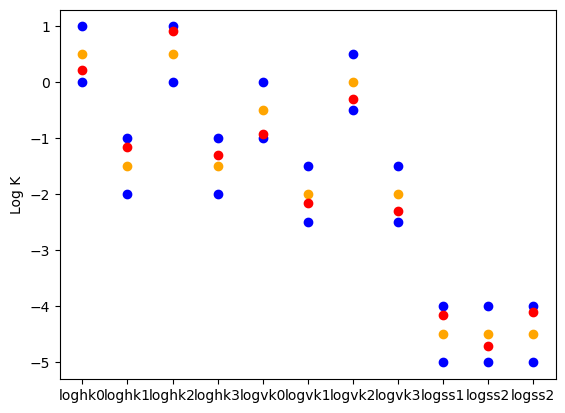

In [28]:
k_min = [0, -2, 0, -2, -1, -2.5, -0.5, -2.5, -5, -5, -5]
k_max = [1, -1, 1, -1, 0, -1.5, 0.5, -1.5, -4, -4, -4]

k_mean = [(k_max[i] - k_min[i])/2 + k_min[i] for i in range(len(k_min))]
plt.plot(np.linspace(0,10,11), k_min, 'o', color = 'blue')
plt.plot(np.linspace(0,10,11), k_max, 'o', color = 'blue')
plt.plot(np.linspace(0,10,11), k_mean, 'o', color = 'orange')
plt.plot(np.linspace(0,10,11), logfunc(reference[0] + reference[1] + reference[2][1:]), 'o', color = 'red')
plt.ylabel('Log K')
plt.xticks(np.linspace(0,10,11), ['loghk0', 'loghk1', 'loghk2', 'loghk3', 
                                'logvk0', 'logvk1', 'logvk2', 'logvk3',
                                'logss1', 'logss2', 'logss2'])#, logss1, logss2, logss3, sy0, cp])
plt.show()

In [29]:
def Likelihood(obs, mod, err):
    return(np.sum(-(obs-mod)**2/(2*err**2)))

#from DREAM import *
%run ../../Lab_tools/Uncertainty_tools/DREAM.py

Unif = [] # True = Uniform, False = Normal
Log = []  # ?? Just put False
Mean = []
Width = []  # for uniform distributon the range,  for normal, the standard deviation
Min = []
Max = []

###K values
for i in range(len(P.hk)):
    Unif.append(True) # True if uniform, False if normal
    Log.append(False) # Ignore
    Mean.append(k_mean[i])
    Width.append(k_mean[i] - k_min[i])
    Min.append(k_min[i]) 
    Max.append(k_max[i]) 

#make this anisotropy
for i in range(len(P.vk)):
    Unif.append(True) # True if uniform, False if normal
    Log.append(False) # Ignore
    Mean.append(k_mean[i+4]) # Changed 18/8
    Width.append(0.5)
    Min.append(k_min[i+4]) # Changed 18/8
    Max.append(k_max[i+4]) # Changed 18/8
    
for i in range(3): # 1e-4 to 1e-6 # Botom 3 layers
    Unif.append(True) # True if uniform, False if normal
    Log.append(True) # Ignore
    Mean.append(-4.5)
    Width.append(0.5)
    Min.append(-5) 
    Max.append(-4)
    
#Sy top geo layer #0.05 - 0.2
Unif.append(True)
Log.append(False)
Mean.append(0.125)
Width.append(0.125/2)
Min.append(0.05)
Max.append(0.2)

#Control points z value
Unif.append(True)
Log.append(False)
Mean.append(-125)
Width.append(125)
Min.append(-250)
Max.append(0)

In [30]:
MCMC = [Min, Mean, Max]
pickle.dump(MCMC, open('../results/MCMC.pkl','wb'))

#### Set up DREAM and define "run model" function

In [31]:
## DREAM for Steady State
nchains = 5     #number of parallel chains 
npars = len(Mean)  #number of parameters
nburn = 200 
minsamp = 169 # minimum number of samples

D = DREAM(nchains, npars, nburn = nburn, npairs = 1) #nburn is burn in perion, npairs defines how you sample
D.par_set(Log,Unif,Mean,Width,Min,Max) #initialise the class
D.set_CR(ncr=3)  #crossover testing thingy. Use 3
D.k = 1  # Number of things to try each chain. Numbers other than 1 can give weird results for some models

In [32]:
'''# Load DREAM results
pickleoff = open('../results/dream_pars_chain_0_.pkl','rb') # dream_pars (122, 13)
dream_pars_0 = pickle.load(pickleoff)
pickleoff.close()

pickleoff = open('../results/dream_pars_chain_1_.pkl','rb') # dream_pars (122, 13)
dream_pars_1 = pickle.load(pickleoff)
pickleoff.close()

pickleoff = open('../results/dream_pars_chain_2_.pkl','rb') # dream_pars (122, 13)
dream_pars_2 = pickle.load(pickleoff)
pickleoff.close()

pickleoff = open('../results/dream_pars_chain_3_.pkl','rb') # dream_pars (122, 13)
dream_pars_3 = pickle.load(pickleoff)
pickleoff.close()

pickleoff = open('../results/dream_pars_chain_4_.pkl','rb') # dream_pars (122, 13)
dream_pars_4 = pickle.load(pickleoff)
pickleoff.close()

D.chains[0].current = dream_pars_0[-1,:]
D.chains[1].current = dream_pars_1[-1,:]
D.chains[2].current = dream_pars_2[-1,:]
D.chains[3].current = dream_pars_3[-1,:]
D.chains[4].current = dream_pars_4[-1,:]'''


"# Load DREAM results\npickleoff = open('../results/dream_pars_chain_0_.pkl','rb') # dream_pars (122, 13)\ndream_pars_0 = pickle.load(pickleoff)\npickleoff.close()\n\npickleoff = open('../results/dream_pars_chain_1_.pkl','rb') # dream_pars (122, 13)\ndream_pars_1 = pickle.load(pickleoff)\npickleoff.close()\n\npickleoff = open('../results/dream_pars_chain_2_.pkl','rb') # dream_pars (122, 13)\ndream_pars_2 = pickle.load(pickleoff)\npickleoff.close()\n\npickleoff = open('../results/dream_pars_chain_3_.pkl','rb') # dream_pars (122, 13)\ndream_pars_3 = pickle.load(pickleoff)\npickleoff.close()\n\npickleoff = open('../results/dream_pars_chain_4_.pkl','rb') # dream_pars (122, 13)\ndream_pars_4 = pickle.load(pickleoff)\npickleoff.close()\n\nD.chains[0].current = dream_pars_0[-1,:]\nD.chains[1].current = dream_pars_1[-1,:]\nD.chains[2].current = dream_pars_2[-1,:]\nD.chains[3].current = dream_pars_3[-1,:]\nD.chains[4].current = dream_pars_4[-1,:]"

In [33]:
data = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "pinchout_example")
strat = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "strat")
    
# Include this here when ignoring structural parameters
#P.control_points = (['CP1', 'control', 3000, 3000, -100, -200, 'c', 'lower', np.nan, np.nan, np.nan],) 
#P.data, P.strat = prepare_geomodel_loopshowcase(P, data, strat, include_fault = False)   # Prepare geomodel inputs
#P.geomodel = create_geomodel_loopshowcase(P, include_fault = False) # Make geomodel

In [34]:
def update_model(P, loghk0, loghk1, loghk2, loghk3, logvk0, logvk1, logvk2, logvk3, 
                 logss1, logss2, logss3, sy0, cp):
    print(loghk0, loghk1, loghk2, loghk3, logvk0, logvk1, logvk2, logvk3, 
                 logss1, logss2, logss3, sy0, cp)
    del P.hk
    del P.vk
    del P.ss
    del P.sy
    P.hk = [10**loghk0, 10**loghk1, 10**loghk2, 10**loghk3] #[1, 0.1, 10, 0.1] 
    P.vk = [10**logvk0, 10**logvk1, 10**logvk2, 10**logvk3] #[i/10 for i in P.hk]
    P.ss = [0.00009, 10**logss1, 10**logss2, 10**logss3]
    P.sy = [sy0, 0.1, 0.1,0.1]#[sy0, 0.1, 0.1, 0.1]
    P.control_points = (['CP1', 'control', 3000, 3000, cp, -200, 'c', 'lower', np.nan, np.nan, np.nan],) 
    P.data, P.strat = prepare_geomodel_loopshowcase(P, data, strat, include_fault = False)   # Prepare geomodel inputs
    P.geomodel = create_geomodel_loopshowcase(P, include_fault = False) # Make geomodel
    M = Model('run', P, plan = 'vor', transect = 'con') # Create flow model 
    M.create_lith_dis_arrays(P)                                 # Create lith and dis arrays
    M.create_prop_arrays(P)                                     # Create K arrays
    M.create_flow_package_arrays(P)                             # Create flow packages
    
    results = M.write_run_model(P, period = 'Steady', ic_array = P.strt)   
    M.gwf, M.head_ss, M.obs_ss = results[0], results[1], results[2]
    
    results = M.write_run_model(P, period = 'Past', ic_array = M.head_ss)   
    M.gwf, M.head_past, M.obs_past = results[0], results[1], results[2]
     
    #hobs_steady = process_obs_steady(P, M)
    hobs_past = process_obs_past(P, M)
    return(hobs_past, M)


In [35]:
#this function and argument statement are for the labtools dream implementation.

def L_func(Prop, P, hobs_ref, err):
    hmod, M = update_model(P,
                        Prop[0],
                        Prop[1],
                        Prop[2],
                        Prop[3],
                        Prop[4],
                        Prop[5],
                        Prop[6],
                        Prop[7],
                        Prop[8],
                        Prop[9],
                        Prop[10],
                        Prop[11],
                        Prop[12],
                        ) 
    a = np.array(hobs_ref) 
    b = np.array(hmod)
    P.hmod = hmod
    P.M = M
    return(Likelihood(a,b,err))
    
    
args = (P, hobs_ref, err,) # P - project object, hobs_ref - real observations, err - 
    
def result_func(Prop,P):
    M = P.M
    hpred = run_prediction(M, ic_array = M.head_past)
    overall = np.append(P.hmod,hpred,axis=2)
    #print(overall)
    return(overall)

Rfunc_args = (P,)
    

In [36]:
def run_prediction(M, ic_array):
    results = M.write_run_model(P, period = 'Future', ic_array = ic_array)   
    M.gwf, M.head_future, M.obs_future = results[0], results[1], results[2]
    hpred = process_obs_future(P, M)
    return hpred

In [ ]:
results = Dream_ZS(D,       # DREAM class being used.
                   L_func,  # function that recieves the proposed pars, places in model, runs model & returns Likelihood 
                   args,    # contains all the args for the model outside of the parameters
                   result_func = result_func,      # save the model outputs
                   result_func_args = Rfunc_args,  
                   minsamp = minsamp,         
                   print_freq = 1,
                   Test = False,      # If True, only initial likelihoods obtained
                   lookback = 10,
                   R_overide = False)  # Stops even if R=1.2 not reached

0.5353031458967116 -1.2880767151369337 0.5484523396557045 -1.4131618703707765 -0.8695308572332657 -1.7007453547610083 -0.18751944260404096 -1.8872977707737428 -4.167370115155031 -4.299472589695318 -4.7635486351922784 0.10264559465605848 -177.3154153643551
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.129021
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.064484
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  30.491991
Initial Likelihood for chain  0  =  -475757.14016235934
0.6085209230862475 -1.3086476850477773 0.6478144863423566 -1.0666441376176155 -0.6326342466632735 -1.812999531855894 -0.177016800348876 -2.105821403969199 -4.131384153864873 -4.101943783284165 -4.688244667448086 0.13558570768131845 -214.1221584178437


   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.222183
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  19.377168
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  35.055627


Initial Likelihood for chain  1  =  -58817.11842210642
0.9565131218280979 -1.5378416981617702 0.7217447908104122 -1.5671208054602803 -0.4244377507157411 -2.221023950238944 -0.048344072865937227 -2.4651599700672704 -4.971589685884864 -4.413275345480956 -4.790409550031725 0.06387386025084517 -73.82545449690457
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.304077
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.509232
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.98065
Initial Likelihood for chain  2  =  -157207.58699607349
0.8604462230323546 -1.3242509157390336 0.6697649845578242 -1.9444694671993132 -0.08925876735156069 -2.1440701718567743 0.14006248633936236 -2.2706322341652863 -4.4741623417004455 -4.124766330965535 -4.005631911715507 0.07382637300219978 -8.59980667657112
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.134987
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.325127
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  25.357452
Initial Likelihood for chain  3  =  -302914.7647892035
0.8084816551245112 -1.4822679771718557 0.8383287614458463 -1.4653194983973952 -0.9500144509105514 -1.7987126698124956 -0.14987041807847 -2.2596609021030183 -4.6243835610527135 -4.94164146109497 -4.273239002843828 0.14658444959989497 -57.678335370200614
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.132136
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.207302
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  27.196661
Initial Likelihood for chain  4  =  -292252.05917221314
0.5352797292787554 -1.207052829621323 0.4594849234082279 -1.2271407818580335 -0.7212231801415655 -1.707417594921651 -0.20019059680231094 -1.815386911197922 -4.167275626315078 -4.299

   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.173175
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.095778
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  25.088242
0.6084629169959246 -1.3086066565861774 0.6478197418813035 -1.0665251137734835 -0.6326636850047842 -1.570155835363405 -0.17706115400735187 -2.1058988732558235 -4.756039209026033 -4.0487952330241574 -4.688269957298054 0.15368028534292805 -214.1126408441594
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.315998
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.422395
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  36.069797
0.9564889549080094 -1.5378201618918832 0.7217882860360096 -1.5670735278110783 -0.4242971166640205 -2.220988176187788 -0.04835651899066107 -2.4651469125690038 -4.971631134777348 -4.4135379472899885 -4.790311360682399 0.06386096468396733 -73.78543167639589
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.14245
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.357435
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  27.825494
0.8606228129757179 -1.3242390645731148 0.6698182595416284 -1.9444618139121879 -0.08923775359301725 -2.1440896347353116 0.14004319230328519 -2.270635460530675 -4.473981871020456 -4.124841134754958 -4.005664057099608 0.07381458822598717 -8.600850469507446
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.140707
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.530648
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  25.770871
0.8084773913120524 -1.4822772305007186 0.8383913051966876 -1.4651354302038258 -0.9502589408552234 -1.7987812420890021 -0.1499136658453688 -2.2597135402508757 -4.624474191140753 -4.941585231109851 -4.273103349606382 0.1466007989382092 -57.73890778085245
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.239977
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.16853
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  30.064687
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  1
sampled =   2.0  tried =  5.0
Currenty sampling at a rate of  40.0 %
Current Likelihood for chain  0  =  -475757.14016235934
Current Likelihood for chain  1  =  -58817.11842210642
Current Likelihood for chain  2  =  -157207.58699607349
Current Likelihood for chain  3  =  -302721.5948264127
Current Likelihood for chain  4  =  -292244.3561764958
1
0.5352963655719873 -1.288114996720542 0.5484973277379649 -1.41314723011292 -0.8695386898313903 -1.7005247350590542 -0.03954573128385519 -1.8872332555990698 -4.327128725243889 -4.310019370810684 -4.763500262652754 0.10265154242650262 -177.2918110319297
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.216643
   Writing simulation and gwf for  run  ...
Period =  Steady 
  

   run_time =  36.221584
0.5742729165639413 -1.3086389439376631 0.6014314714954556 -1.2281993202453583 -0.74313478683869 -1.8129433269451858 -0.17702471570806058 -2.105890570018707 -4.131248391605579 -4.199080996977909 -4.688061438325732 0.1355907044030669 -214.14091332803469
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.966088
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.401219
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.906561
0.7941052100971386 -1.4308504190044526 0.7217099499801636 -1.3334532797931644 -0.5213237562857843 -2.030525444999554 -0.10845307661147228 -2.2974218687813597 -4.579691096143346 -4.4131287066375755 -4.742718476972603 0.09733670854164982 -137.29957145359518
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.028438
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.730271
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  23.362088


0.023011391328674247 -1.4312046912801022 0.6697985680938904 -1.178157144772456 -0.9921400513569745 -2.33462530390407 0.2000168092998811 -2.270602116189666 -4.865587295229094 -4.270259090534255 -4.05318418779283 0.07382580709711227 -8.598502641291184
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.05023
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.450963
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  27.181579


0.005152582158032937 -1.598821413683197 0.9192661674913047 -1.464993953614348 -0.9501615781999782 -1.7988131330319954 -0.15408130828747013 -2.2597265531755393 -4.624689286403051 -4.9896524156613795 -4.285589435801217 0.12851937110249495 -57.732765630231825
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.404966
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.267824
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  28.314426
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  2
sampled =   3.0  tried =  10.0
Currenty sampling at a rate of  30.0 %
Current Likelihood for chain  0  =  -468882.87769171863
Current Likelihood for chain  1  =  -58817.11842210642
Current Likelihood for chain  2  =  -157207.58699607349
Current Likelihood for chain  3  =  -302721.5948264127
Current Likelihood for chain  4  =  -292244.3561764958
2
0.501064434344403 -1.2784861021265332 0.5020495120683309 -1.5751694413373003 -0.9801489014574275 -1.6479014712710527 0.02457053123102124 -1.7851126047945272 -4.4186156650982085 -4.407079925645049 -4.798473420779074 0.08725128094866866 -160.51953211069704
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.985371
   Writing simulation and gwf for  run  ...
Period =  Steady

Period =  Past 
   Model success =  True
   run_time =  25.302476
0.6085655569148151 -1.3087993834280605 0.6478533587695868 -1.066761936077932 -0.6324886020958965 -1.8129539371734147 -0.1770454957828367 -2.1058944812779394 -4.131312080770486 -4.102369914689652 -4.688003179763941 0.13560319534347856 -214.1050463311502
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.21285
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.67831
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  27.674128
0.8289323990709828 -1.4472830234652798 0.5864639091953026 -1.5424361416404253 -0.3868580469802388 -2.1752554217843776 -0.06599542609368006 -2.2912864919624503 -4.758104996133014 -4.11347085931645 -4.019787453717745 0.19337290872993235 -127.48948842495825
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.985116
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.195314
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  26.937121
0.012449528829558076 -1.3411219510286616 0.7264038309312945 -1.19246479005341 -0.7249675112616059 -2.143939035249332 0.1400909123592577 -2.2706436339659333 -4.616991452530572 -4.043274248284235 -4.005769808225926 0.07381919660282257 -8.552323321103193
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.880226
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.770397
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  25.911879
0.7743502772633019 -1.4726240861738444 0.7919960362400216 -1.6268067648358304 -0.060677348412415455 -1.7462860577889967 -0.15482276710103463 -2.157868672448071 -4.6412558851186025 -4.033516100611708 -4.308510055523385 0.1312167228700551 -39.94835597267295
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.984384
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.539106
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.826433
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  3
sampled =   3.0  tried =  15.0
Currenty sampling at a rate of  20.0 %
Current Likelihood for chain  0  =  -468882.87769171863
Current Likelihood for chain  1  =  -58817.11842210642
Current Likelihood for chain  2  =  -157207.58699607349
Current Likelihood for chain  3  =  -302721.5948264127
Current Likelihood for chain  4  =  -292244.3561764958
3
0.5351932504843542 -1.2880502453800875 0.5485834715620745 -1.413110807555773 -0.8696562332097053 -1.7007001783660827 -0.03945787438134199 -1.8873020427685812 -4.326960918865914 -4.310051111589679 -4.76342819673807 0.10265772543640383 -177.26687371429887
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.872689
   Writing simulation and gwf for  run  ...
Period =  Steady 

Period =  Past 
   Model success =  True
   run_time =  25.385747
0.4565976389950322 -1.2917169418863659 0.5911427283496467 -1.818338621602487 -0.9968315194921482 -1.6060470268303473 -0.2608157919748491 -1.9269122407386576 -4.062549938451015 -4.10181322327146 -4.041952759977684 0.14906793401355473 -42.6985399564125
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.065952
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.137374
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  23.102511


0.9564153074912519 -1.5377754579967524 0.7216787813694691 -1.5671586961207087 -0.424393425445657 -2.2210800653880116 -0.048368268344476745 -2.4650691734340806 -4.971617757697961 -4.4130475719218705 -4.790523254935303 0.06386924067175863 -73.86052872299396
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.972628
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.596628
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.192951
0.8603966152496257 -1.3242459760991392 0.6698527055301854 -1.9443640983826453 -0.08905160332921969 -2.1442333248506964 0.14006535893861732 -2.2707026804802206 -4.473959685502664 -4.124655538887686 -4.880507541993199 0.07382132758587137 -8.541912994822114
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.891237
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.724333
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.609684
0.926045643164516 -1.4895278243372443 0.8485524926084084 -1.8746887464280009 -0.696522950443708 -1.9531235508576898 -0.0019490591992674501 -2.336643361512198 -4.7842203380060075 -4.95226348551405 -4.954331948811182 0.1177836157103918 -208.7264051294567
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.007392
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.297225
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  29.470278
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  4
sampled =   5.0  tried =  20.0
Currenty sampling at a rate of  25.0 %
Current Likelihood for chain  0  =  -468882.87769171863
Current Likelihood for chain  1  =  -58817.11842210642
Current Likelihood for chain  2  =  -157207.58699607349
Current Likelihood for chain  3  =  -294143.8460204218
Current Likelihood for chain  4  =  -167444.40953328862
4
0.5353414437409658 -1.288031425857131 0.526542568881595 -1.5355733075224292 -0.41297333742640974 -2.3694714106957258 -0.3566378309241929 -1.722439153762444 -4.984271802605603 -4.287153141035012 -4.763431083302022 0.1026453232357218 -177.36799416234769
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.237678
   Writing simulation and gwf for  run  ...
Period =  Steady 


Period =  Past 
   Model success =  True
   run_time =  25.180784
0.608543087616988 -1.3086155109548285 0.6478463779258911 -1.0666505232136216 -0.6325268840126865 -1.8131389286677608 -0.1770742114404277 -2.1058605813028786 -4.131642167199048 -4.101594702916507 -4.562965552925512 0.13560275985679127 -214.10137589266867
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.893882
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.688242
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  27.666719
0.5353415237710425 -1.5378398535854545 0.7217336917738962 -1.4133783382509728 -0.8696610544180309 -2.2211050673538595 -0.04844792381911127 -1.887135057606874 -4.9717700092655175 -4.413638686775758 -4.763488778116659 0.10266800104454982 -174.15403858810635
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.974206
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.540438
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  28.469764
0.8604302388899917 -1.5377930698254434 0.6699158087328407 -1.5671627183488497 -0.08888874028573109 -2.1443975616814916 -0.04844160526331425 -2.4654923098319808 -4.473858607055071 -4.413458967844941 -4.880234268390243 0.07383892008305162 -8.52930173508733
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.922156
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.99397
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.146738
0.02204716052428024 -1.703148753511926 0.8485698878851768 -1.497285841651519 -0.03149010887549131 -2.0299792764125586 -0.0018870278074036928 -2.3364922838412028 -4.282043374948248 -4.2407504107053615 -4.954225886392779 0.11775507297044639 -208.7331896752532
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.892388
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.703099
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  27.349128
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  5
sampled =   7.0  tried =  25.0
Currenty sampling at a rate of  28.0 %
Current Likelihood for chain  0  =  -468882.87769171863
Current Likelihood for chain  1  =  -58817.11842210642
Current Likelihood for chain  2  =  -157207.58699607349
Current Likelihood for chain  3  =  -254808.81215670655
Current Likelihood for chain  4  =  -128492.43878773242
5
0.662636887429125 -1.3787895277792308 0.6838007051747192 -1.4373464434869865 -0.9068453261434455 -1.7463253767038227 -0.09103841568960101 -2.061352185058483 -4.465983133020081 -4.604834820254423 -4.534702972198953 0.12316784136665594 -124.17073716149051
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.871338
   Writing simulation and gwf for  run  ...
Period =  Stead

Period =  Past 
   Model success =  True
   run_time =  26.438377
0.5635726214578775 -1.2089330883840619 0.6235533631748584 -1.2424652666651748 -0.4759311350115098 -1.7770438747770576 -0.08915119203304356 -2.014976162018207 -4.898851677781741 -4.967480003735405 -4.321981616514386 0.14021774736012937 -184.11269930316033
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.879997
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.729815
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  27.440798
0.11878840842927141 -1.644752955737062 0.7562816942942139 -1.8006814435372054 -0.32715716778140697 -2.411361535918328 0.011645156792609773 -2.464999515462116 -4.3639129591723185 -4.558712530558536 -4.790608094014762 0.1803800289632784 -10.667062108928627
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.924806
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.911561
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  26.285379
0.7086664103798785 -1.4212927994043503 0.6132476773171622 -1.495185976200079 -0.45317875661674895 -1.9372059284851295 -0.11341354336977295 -2.195621362983236 -4.330719845013031 -4.359839094636355 -4.826085895221854 0.08726854815863308 -84.89757711254164
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.890611
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.19787
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  21.612849
0.8945561424966618 -1.6126087457567573 0.7132287559378269 -1.4732264720153907 -0.9938647939690229 -1.9840278786745649 0.049601437901564925 -2.162872594183033 -4.143305976542888 -4.945747225275003 -4.183196667523789 0.0972803955191868 -12.05588818694116
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.892403
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.164274
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.857005
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  6
sampled =   8.0  tried =  30.0
Currenty sampling at a rate of  26.7 %
Current Likelihood for chain  0  =  -427085.45497508475
Current Likelihood for chain  1  =  -58817.11842210642
Current Likelihood for chain  2  =  -157207.58699607349
Current Likelihood for chain  3  =  -254808.81215670655
Current Likelihood for chain  4  =  -128492.43878773242
6
Minimum likelihood for outlier chains is:  -520808.61226133263
0.6176877152759238 -1.37887478558506 0.6596644089547101 -1.4376132831366553 -0.7503239296340217 -1.7106561308307926 -0.09115904150572399 -2.0614397745847 -4.23390693882126 -4.604871614316266 -4.576790971347576 0.12780488590670233 -93.37600019344784
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.903289
 

Period =  Past 
   Model success =  True
   run_time =  22.335461
0.44579101869198234 -1.308675380177748 0.6132615979363611 -1.066652621450329 -0.729628405192987 -1.8130944196377086 -0.23707880287582625 -1.9377627257316195 -4.739265530436505 -4.9570467195462395 -4.640363206654371 0.1690957924010612 -29.469981686947165
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.885555
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.0493
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.712737
0.9567227962962875 -1.5051445007726172 0.72188484507796 -1.5667463587466504 -0.29625827768169277 -2.2523158145590947 -0.08854423280309083 -2.486127492354469 -4.815267239414269 -4.1784149405326865 -4.790644902139343 0.06965696888072165 -116.49970377902571
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.995753
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.975314
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  23.483955
0.9781277806314963 -1.5451503223365979 0.6801127660459279 -1.976694857612711 -0.8352635673135834 -2.299158818761336 0.09953790429197915 -1.5426907932809288 -4.634012781713115 -4.424103072747354 -4.561800639427931 0.1949567452869685 -162.86852955534567
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.896811
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.055286
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  24.636252
0.011823155587612709 -1.699768952537758 0.8485941143930843 -1.4974188801977526 -0.03164725502728852 -2.030167190406746 -0.07093088079999713 -2.3365489589248005 -4.282383048421336 -4.240721209176767 -4.061250833369394 0.05657751592724783 -208.68069672221094
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.98682
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.118462
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  30.763648
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  7
sampled =   11.0  tried =  35.0
Currenty sampling at a rate of  31.4 %
Current Likelihood for chain  0  =  -427085.45497508475
Current Likelihood for chain  1  =  -58817.11842210642
Current Likelihood for chain  2  =  -139083.78925922094
Current Likelihood for chain  3  =  -139690.07045010698
Current Likelihood for chain  4  =  -124990.00536346035
7
Minimum likelihood for outlier chains is:  -432879.00935184956
Removing chain 0with average lilihood of -447984.1663334017compared to interquartile minimum of -432879.00935184956
0.608511525182677 -1.3086536909787623 0.6478257602977308 -1.0666238407932478 -0.6326342466632735 -1.8129983151907207 -0.17700257723582563 -2.105821403969199 -4.131391813125251 -4.101943783284165 -4.688253760651198 0.13558570768131845 -214.1221584178437
   Creating lithology and discretisation arrays

   run_time =  28.939542
0.6085209228578051 -1.3086476849013802 0.6478144854319349 -1.0666441339103687 -0.6326342466632735 -1.8129995319022478 -0.1770168001930694 -2.105821403969199 -4.131384153604289 -4.101943783284165 -4.688244668067036 0.13558570768131845 -214.1221584178437
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.096597
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.559543
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  28.601162
0.9567227962684951 -1.5051445003352588 0.7218848444787651 -1.5667463509542356 -0.29625827768169277 -2.2523158146826785 -0.08854423406844725 -2.486127492354469 -4.815267238970569 -4.1784149405326865 -4.79064490267312 0.06965696888072165 -116.49970377902571
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.879507
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.123875
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  23.506636
0.978138904914012 -1.5451574945759423 0.6801185600368681 -1.9766662076841433 -0.8352922684439124 -2.299112222258264 0.09953057839428697 -1.5426301061333205 -4.634041030785455 -4.424096788089984 -4.5617944590759505 0.19495519365642985 -162.88881622892114
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.94461
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.312759
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  25.229793


0.011780858036090535 -1.6996592972672704 0.8486045491540503 -1.497029007461685 -0.031702317118594676 -2.03017768299695 -0.07088409212089117 -2.336655636313823 -4.282317364347592 -4.2406324245458675 -4.061213774183326 0.05658994832564958 -208.68723158786025
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.963379
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.026817
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  28.130237


--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  8
sampled =   14.0  tried =  40.0
Currenty sampling at a rate of  35.0 %
Current Likelihood for chain  0  =  -58808.645662358045
Current Likelihood for chain  1  =  -58817.11842210642
Current Likelihood for chain  2  =  -139083.78925922094
Current Likelihood for chain  3  =  -139636.56341228524
Current Likelihood for chain  4  =  -124603.56264006847
0
0.6083732400981937 -1.3086013611550253 0.6478006974210783 -1.0664855003478033 -0.63267658126002 -1.8129990691178535 -0.1770352737180441 -2.105737872679256 -4.131326678238794 -4.101910877385711 -4.688095544023299 0.13557979284233607 -214.10374563113592
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.905513
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.900534
   Writing sim

   run_time =  27.905809
0.6085056806531525 -1.1261409654972794 0.5541170802433579 -1.0668546774460093 -0.9131933675898238 -1.711602391068151 -0.2265739235265475 -2.1057599325947973 -4.0609506652123315 -4.101890828221697 -4.9808388277578155 0.17242497779683816 -216.6253637362155
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.009058
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.773545
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  27.828043
0.9567194816075382 -1.5051645148933446 0.7218972103320662 -1.5666952018494542 -0.2963858606038468 -2.252156101419209 -0.08854077261705255 -2.4861634232762095 -4.8154439258693795 -4.17837905440669 -4.790630419810768 0.06965388997007045 -116.49300013147412
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.909757
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.789047
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  25.368461


0.9780523336389307 -1.54510331893457 0.6800804266544599 -1.9766909870002307 -0.8353043038356541 -2.299243566027413 0.09956692969231327 -1.5424933395494826 -4.633953906312989 -4.424047394148976 -4.561772380129258 0.19495112071961215 -162.88234636598
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.162248
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.107649
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  28.103076
0.011696810409668332 -1.6996161404542918 0.848537306625971 -1.4971068388686581 -0.0316481074147791 -2.0301092337080404 -0.07092612196161119 -2.3366050123756543 -4.282473904379554 -4.240780075695681 -4.061275506310282 0.05658489263553551 -208.6670095010126
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.033613
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.237926
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  29.722468
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  9
sampled =   15.0  tried =  45.0
Currenty sampling at a rate of  33.3 %
Current Likelihood for chain  0  =  -58808.645662358045
Current Likelihood for chain  1  =  -58817.11842210642
Current Likelihood for chain  2  =  -139082.7285742668
Current Likelihood for chain  3  =  -139636.56341228524
Current Likelihood for chain  4  =  -124603.56264006847
1
0.6084205424525729 -1.3085139895780258 0.6478073020637878 -1.0669081069888133 -0.6325549514729752 -1.8129252059796905 -0.17697534805360648 -2.105922437299001 -4.131480167445834 -4.101909419803699 -4.688328073756892 0.13560598686723166 -214.11636358995995
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.154459
   Writing simulation and gwf for  run  ...
Period =  Stea

0.6083118647575885 -1.3087320455783829 0.6478098215356525 -1.0666566126726058 -0.6326683839777408 -1.8128707967645346 -0.17694371624175864 -2.105827895578466 -4.131442125160165 -4.101941711686631 -4.688275870975638 0.13561910263898846 -214.12389394745782
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.990501
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.024996
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.448321
0.7844752706361048 -1.5052346780032808 0.7068532126194159 -1.5663707094699055 -0.296169677503978 -2.0254084517047306 -0.08871362269495746 -2.4863533456748166 -4.815546787123132 -4.028193033780791 -4.849734502337955 0.0696328675946432 -116.4961605073031
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.988728
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.143084
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.224971
0.9780481968726208 -1.5451831248303918 0.6800939071110745 -1.9765645154520408 -0.8353609802811429 -2.299035499082769 0.09957614577114043 -1.5425952503851852 -4.633978238342001 -4.424096101744264 -4.561942493506156 0.19495647584419887 -162.86754417090862
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.072924
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.442432
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  27.243019
0.2902184255264873 -1.6995711636246509 0.8487065344362538 -1.4968859891258517 -0.03155290714412783 -2.0302125363245396 -0.12045655539086245 -2.3367233951464783 -4.211767361712845 -4.176019042143744 -4.353968727935328 0.05659316637768481 -208.71806009831678
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.11023
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.885479
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  28.649783
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  10
sampled =   17.0  tried =  50.0
Currenty sampling at a rate of  34.0 %
Current Likelihood for chain  0  =  -58808.645662358045
Current Likelihood for chain  1  =  -58815.768340611656
Current Likelihood for chain  2  =  -139082.7285742668
Current Likelihood for chain  3  =  -139636.56341228524
Current Likelihood for chain  4  =  -53682.70337887624
2
0.6086753330741628 -1.3086483265437587 0.6478767331287648 -1.0663735984277936 -0.6323487959558206 -1.8129929036360948 -0.17706516647937526 -2.105935246411819 -4.1314196659500455 -4.1020211198870244 -4.6881811406388 0.1355928325894379 -214.12809218704496
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.154325
   Writing simulation and gwf for  run  ...
Period =  Stea

0.6083135481418739 -1.3087365126196895 0.6477704549058151 -1.0666885152329222 -0.6328048351088192 -1.8126247081146527 -0.17696577430031504 -2.105779569864843 -4.13141126879386 -4.102044719276063 -4.688228396767428 0.13563583219337821 -214.15031642896403
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.968749
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.033944
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  31.710099
0.9568572871979654 -1.5052151958857558 0.7219377665447164 -1.566484962491541 -0.29634989918313565 -2.252343215815396 -0.08849838578325674 -2.486138296915763 -4.8156133337008145 -4.1784045971063115 -4.790674708376478 0.06959293213471106 -116.46654324543239
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.120646
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.627607
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.652494
0.9783478968167044 -1.5449584219925965 0.6800496010253483 -1.976916426399451 -0.8351941821147105 -2.299147730625543 0.09950883504603883 -1.542789490100076 -4.633772889380944 -4.424035795758968 -4.561821404322232 0.19498427910094723 -162.86562367509688
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.0659
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.453011
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  24.371219
0.290196381508482 -1.6997005957574411 0.8487029590680265 -1.295591016175508 -0.3119608739712452 -2.0301972916881765 -0.12045990092307875 -2.336866105087051 -4.211745380990043 -4.175979444354497 -4.354036163537826 0.09346409728492201 -211.20119453804833
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.975942
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.240526
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  27.444272
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  11
sampled =   21.0  tried =  55.0
Currenty sampling at a rate of  38.2 %
Current Likelihood for chain  0  =  -58760.83844090032
Current Likelihood for chain  1  =  -58688.67577573798
Current Likelihood for chain  2  =  -139069.26970643093
Current Likelihood for chain  3  =  -139636.56341228524
Current Likelihood for chain  4  =  -25777.747861120803
3
0.60875899308183 -1.1120091625993629 0.647902063221708 -1.5663756479602924 -0.6325244677312286 -1.8129701533166254 -0.17712571217493447 -1.7256902938869925 -4.131103624739803 -4.10205437325994 -4.688131501560277 0.13564531359874013 -214.09256975366395
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.89655
   Writing simulation and gwf for  run  ...
Period =  Steady 

Period =  Past 
   Model success =  True
   run_time =  30.890074
0.6083782044115225 -1.308792288631215 0.6477186620699455 -1.0665233218728196 -0.6325121545155081 -1.8125755969067965 -0.1769991949295005 -2.105804285218906 -4.131569215572561 -4.102006208740794 -4.688224630810193 0.1356430326037 -214.11321352112378
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.043579
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.659445
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  27.391883
0.5871464823523636 -1.2687213859000481 0.7219155089852459 -1.6561001963260156 -0.29620979982120654 -2.2524861522346504 -0.3651116417866257 -2.049278409928885 -4.313101809364881 -4.856230283350689 -4.917156913644036 0.1601795713917875 -166.80044442525013
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.59111
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.55525
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  23.30907
0.9778738065094142 -1.5451600966153676 0.6801938382285977 -1.9769854594374654 -0.835368894460122 -2.298912676699669 0.09955964960905934 -1.5425193888749726 -4.634128550405482 -4.424139751427258 -4.561655452287611 0.19496272288338515 -162.9388899515288
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.9727
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.461603
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  24.997964
0.2687419935417858 -1.6996955792288582 0.8487731261100162 -1.2957578840022976 -0.31196557157396004 -2.0303237803347853 -0.30852738437427185 -2.3367074602389835 -4.21199514994037 -4.930363741504902 -4.354097094191653 0.09350202984230961 -211.16494712619198
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.910087
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.427129
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.679545
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  12
sampled =   22.0  tried =  60.0
Currenty sampling at a rate of  36.7 %
Current Likelihood for chain  0  =  -58760.83844090032
Current Likelihood for chain  1  =  -58688.67577573798
Current Likelihood for chain  2  =  -139069.26970643093
Current Likelihood for chain  3  =  -139600.01946801372
Current Likelihood for chain  4  =  -25777.747861120803
4
0.6085121174743809 -1.3085781055421786 0.5541455949668636 -1.066290417024465 -0.6325594909782231 -1.8129472916179408 -0.2034610933301932 -1.9984418958290524 -4.131425888015718 -4.06730269015392 -4.688012188121604 0.13560145049313682 -214.1489522319063
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.046627
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time = 

Period =  Past 
   Model success =  True
   run_time =  28.760366
0.7809479939116414 -1.419208065872415 0.6629547025384022 -1.4916441588453324 -0.7274063318121544 -2.039771597149303 -0.04780230340487826 -1.84324480709967 -4.366105538970043 -4.2522984394855285 -4.629452198462247 0.16333074268463577 -190.27403946809073
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.019735
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.338073
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  28.915481
0.9568152494679216 -1.5050739882145565 0.7219720733561842 -1.566381205541645 -0.296436657252581 -2.2522775440048757 -0.08859349051823952 -2.485790674652415 -4.815532424530976 -4.178485521030597 -4.790673432035731 0.06955019040390102 -116.41564865124137
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.024735
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.626054
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  23.15185
0.8051253632999578 -1.5451771474158922 0.6651399087661765 -1.97692827375365 -0.7408572638543901 -2.2988303450695367 0.09961884499687997 -1.5425884422937262 -4.399623010468151 -4.273838494685101 -4.561812219490838 0.19495144811845522 -162.89126589495612
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.985727
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.89535
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  25.1231
0.28998872414863014 -1.699680169617484 0.8832826096915188 -1.2958017634625911 -0.15487092747987796 -2.030287350421841 -0.1203098921500187 -1.5144836888717617 -4.211772974597485 -4.211442096812442 -4.401947274109467 0.0934523789340026 -211.19622348609894
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.02715
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.661721
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  28.129687
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  13
sampled =   23.0  tried =  65.0
Currenty sampling at a rate of  35.4 %
Current Likelihood for chain  0  =  -58760.83844090032
Current Likelihood for chain  1  =  -58688.67577573798
Current Likelihood for chain  2  =  -139069.26970643093
Current Likelihood for chain  3  =  -139600.01946801372
Current Likelihood for chain  4  =  -13357.812226361342
5
0.781172536990627 -1.308450586014224 0.6630719693058499 -1.490926437881382 -0.7269276478744731 -1.8128949426620438 -0.1770680454026428 -2.1058997138918194 -4.131432018025151 -4.102115614774627 -4.688206185892544 0.13553323485816626 -214.13161469413402
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.890065
   Writing simulation and gwf for  run  ...
Period =  Steady

Period =  Past 
   Model success =  True
   run_time =  28.190132
0.6083210761502397 -1.4004069947864723 0.6477725239358679 -1.3000219447279449 -0.6323111008690933 -1.81210806302577 -0.13561692525583394 -2.105671516010467 -4.450618374547506 -4.1020784848664 -4.688059686536797 0.13567838377636895 -214.20849439101502
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.208809
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.800707
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  27.843162
0.956989860643682 -1.3228982891980061 0.7217984159033098 -1.4594422829592009 -0.4459749705287947 -2.2522433138890294 -0.11472201427666111 -2.378235431687589 -4.778469432505101 -4.178439800835842 -4.790720309801567 0.06957734292668662 -117.79282820492605
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.894063
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.973685
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  24.009937
0.9777447582129404 -1.5449377273793767 0.680154289184788 -1.9773493261427686 -0.8353508098998208 -1.5043369496005634 0.09963311576139541 -1.5424432252915066 -4.633884995293202 -4.424055746284651 -4.561579472067191 0.1949334580656266 -117.4093439020553
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.874207
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.044964
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.920289
0.29000205573707005 -1.6997039824839115 0.8833795795298859 -1.5290305002558457 -0.1546042182455555 -2.030572136066977 -0.12026557746589435 -1.514594443148806 -4.531452766339636 -4.211521980008593 -4.401810894062516 0.09341066021977859 -165.72607567792647
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.025714
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.156442
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  23.808869
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  14
sampled =   24.0  tried =  70.0
Currenty sampling at a rate of  34.3 %
Current Likelihood for chain  0  =  -58760.83844090032
Current Likelihood for chain  1  =  -58688.67577573798
Current Likelihood for chain  2  =  -138718.71180122683
Current Likelihood for chain  3  =  -139600.01946801372
Current Likelihood for chain  4  =  -13357.812226361342
6
Minimum likelihood for outlier chains is:  -212035.12355433597
0.6088988165576078 -1.3086854912840618 0.6479208969195005 -1.0663154415687497 -0.6323815907190136 -1.8130647273028724 -0.17691896556881073 -2.175884979526244 -4.412995201674953 -4.102134363200743 -4.688126983833017 0.13555431892610206 -214.0767508477064
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.01

Period =  Past 
   Model success =  True
   run_time =  27.290908
0.6085855663345228 -1.308806661330213 0.6131213678510156 -1.0675161396474562 -0.7896327554667345 -1.8125523603420317 -0.1770189411151829 -2.1058972430627465 -4.131684058258068 -4.066454162548552 -4.640252764630523 0.16644362754042152 -214.16988607471956
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.897812
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.181115
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  28.535968
0.9566070836491104 -1.3229597491118925 0.7217184141566099 -1.459107078493991 -0.44597044847032563 -2.252218188833147 -0.11470350873853422 -2.3778528299566366 -4.778186782919232 -4.178597876214821 -4.790843585704359 0.06959926369412547 -117.7476936312937
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.963685
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.113823
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  22.905926
0.9781649424172733 -1.5637668813497094 0.680133876801344 -1.9770261446244324 -0.8352537698894303 -2.320745116757013 0.09960500855209518 -1.5427974650207608 -4.63406383915288 -4.538769502228711 -4.561588383285871 0.10347945171944851 -162.95304715518085
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.922303
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.113031
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  26.51211
0.2903098273724526 -1.6993619760739882 0.8832848385857741 -1.2959649233806487 -0.06048494880305508 -2.0304882939490794 -0.24944794398897657 -1.5144454634193738 -4.977100410873569 -4.21156950849845 -4.402062104702014 0.09342839425571127 -235.28273510241488
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.893118
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.843005
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.009371
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  15
sampled =   25.0  tried =  75.0
Currenty sampling at a rate of  33.3 %
Current Likelihood for chain  0  =  -58760.83844090032
Current Likelihood for chain  1  =  -58688.67577573798
Current Likelihood for chain  2  =  -138718.71180122683
Current Likelihood for chain  3  =  -138832.0380738163
Current Likelihood for chain  4  =  -13357.812226361342
7
Minimum likelihood for outlier chains is:  -219263.76191249164
0.7574794354355469 -1.3086555404765394 0.6479238362602295 -1.9598549895571442 -0.632653052169757 -1.7117029123670973 -0.17700443962621024 -1.9982677720596282 -4.093855091817197 -4.101998597573816 -4.8442096764573686 0.15526907116755195 -215.4659878342272
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.01

   run_time =  28.354488
0.6082782089365558 -1.3090281179732648 0.6477349440950656 -1.0663472272787475 -0.6325693520676311 -1.8126453896404462 -0.1768754763922195 -2.106025390547789 -4.1313853833228675 -4.102143666689593 -4.688098131633117 0.13564341108323266 -214.1626929090662
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.9017
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.462742
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  28.094321
0.9571987803300926 -1.3228849163631258 0.7217910874215526 -1.460295669164408 -0.445845862509052 -2.252433757375371 -0.11470788589698273 -2.378024911377494 -4.778580787484511 -4.1783884698898985 -4.79042205780633 0.06958599291125256 -117.81586865245295
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.893624
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.597616
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  24.367436
0.9881297801204004 -1.6671937274714996 0.6606667649937434 -1.219453976711248 -0.016789301321359584 -2.3427185577676433 0.1996677720141838 -2.153163650715827 -4.566483123956042 -4.65351498439142 -4.454611315414831 0.16197752335574114 -184.670844638719
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.17211
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.425897
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  24.338976
0.46228934452496784 -1.8102486007246372 0.898218785520632 -1.7206770197804018 -0.24984358306021068 -2.2573753078891503 0.008695032670635587 -2.252037219860878 -4.44655804213903 -4.361601365731003 -4.343110885954641 0.12116376457905602 -187.59138022644973
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.884588
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.857541
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  25.836377
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  16
sampled =   27.0  tried =  80.0
Currenty sampling at a rate of  33.8 %
Current Likelihood for chain  0  =  -58760.83844090032
Current Likelihood for chain  1  =  -58648.202278279074
Current Likelihood for chain  2  =  -138718.71180122683
Current Likelihood for chain  3  =  -135484.1348060326
Current Likelihood for chain  4  =  -13357.812226361342
8
Minimum likelihood for outlier chains is:  -239267.3129479096
0.01150317803774634 -1.3087664858754586 0.8486898713801158 -1.4965541443207468 -0.03165163852605576 -2.0300311350136875 -0.17710414917752193 -2.3361932349210277 -4.281903210527204 -4.101997171682678 -4.061218956035335 0.05659075432513683 -208.80311560096246
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0

Period =  Past 
   Model success =  True
   run_time =  27.396951
0.6085270622502726 -1.3090572188819924 0.6477105685900282 -1.0661511231751128 -0.6324017015115793 -1.8126094043304617 -0.17707734162111155 -2.105733104716004 -4.131479499962953 -4.102154702285264 -4.68767574606282 0.13561389538143798 -214.19102023024854
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.998388
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.35666
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  27.806754


0.5872390391022395 -1.3227329628144389 0.6893562297068313 -1.5498077525607008 -0.44608055932997104 -1.7656216451553948 -0.11465009928551582 -2.378223849173267 -4.275677797789751 -4.178164181345119 -4.7904657166950395 0.06959375340941741 -168.2050140145112
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.008014
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.953704
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  25.072497
0.6401638621597533 -1.4705835285353448 0.5866180855196135 -1.7200558694372048 -0.35279254679888333 -1.9032496373277608 0.11093272641848106 -1.772783514223995 -4.882820717190586 -4.577178533755091 -4.3521691855901885 0.07791887270002266 -31.160373486371896
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.884312
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.722281
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.096733
0.2901115367134983 -1.6996930139941424 0.8831817633426226 -1.2957286260767367 -0.15465339505276873 -2.0305112903447333 -0.12036383403869379 -1.5147243907311776 -4.211717111141433 -4.211456885202615 -4.402047205524691 0.09344719300270454 -211.21287251029506
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.004064
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.28594
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  26.88432
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  17
sampled =   29.0  tried =  85.0
Currenty sampling at a rate of  34.1 %
Current Likelihood for chain  0  =  -58760.83844090032
Current Likelihood for chain  1  =  -58623.49423919593
Current Likelihood for chain  2  =  -138718.71180122683
Current Likelihood for chain  3  =  -135484.1348060326
Current Likelihood for chain  4  =  -13185.154269459272
9
Minimum likelihood for outlier chains is:  -243350.85025550233
0.6089158507235434 -1.3085934533289694 0.5885830613215716 -1.0994852076998756 -0.7559668148183121 -1.8130421064297475 -0.1770064612316525 -2.1758329507563374 -4.1313276701708075 -4.103078111930204 -4.688220399030633 0.14164628441235108 -214.08168128535593
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.89

Period =  Past 
   Model success =  True
   run_time =  28.340294
0.7811092900208788 -1.4279730678108304 0.6626934349373753 -1.4907413437932988 -0.7266923843682895 -2.049581136331191 -0.04798381772497934 -1.8430587998620978 -4.366018868809834 -4.305950492826277 -4.628597914449168 0.12057177627942607 -190.35185751390708
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.051047
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.597934
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  30.835848
0.9567835205278378 -1.2323087811349478 0.7217458222271748 -1.5861045874640887 -0.512152134338854 -2.252309214579804 -0.09981469188282845 -1.831450504477202 -4.060486202203885 -4.162978640998951 -4.972033712186814 0.058425091377007854 -73.90554420611514
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.967294
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.678811
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.441307
0.9878916599045472 -1.6673761327235592 0.6606785044143754 -1.2190834415096787 -0.01636379501964144 -2.3431031499358324 0.19951183248489418 -2.153186575344444 -4.566575549668628 -4.653513053189511 -4.45476261906932 0.16197866734482438 -184.63786081929925
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.93459
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.6065
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  23.929747
0.29016616884475094 -1.7912303853813887 0.9176267195584162 -1.5294465597744962 -0.9974270941875926 -2.030348249822579 -0.12021312010712305 -1.6925016551111987 -4.531333410403705 -4.247000270734895 -4.402059315485455 0.09347834848969672 -211.22623742733182
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.988307
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.795027
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  28.841826
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  18
sampled =   31.0  tried =  90.0
Currenty sampling at a rate of  34.4 %
Current Likelihood for chain  0  =  -58760.83844090032
Current Likelihood for chain  1  =  -58623.49423919593
Current Likelihood for chain  2  =  -138718.71180122683
Current Likelihood for chain  3  =  -135374.2065862681
Current Likelihood for chain  4  =  -12591.324625283018
10
Minimum likelihood for outlier chains is:  -261047.6589369105
0.6088872375551471 -1.3085825129652127 0.6479155522218555 -1.1928260361685972 -0.632336741326494 -1.8130697594269045 -0.17721271856228965 -2.105707152598327 -4.131598707116559 -4.086708463861596 -4.687950335991589 0.13557802651647055 -214.13861903992694
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.905675
   Writing simulation and gwf for  ru

0.431205085236173 -1.3092950108053434 0.6417499788703077 -1.9949157040409904 -0.9200686806280287 -1.564683984502565 -0.35285607600909036 -2.083246492532527 -4.131548483226621 -4.102106953428688 -4.6881001228667385 0.13560279614863227 -227.50796756216496
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.896832
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.902493
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  34.542944
0.9567270008916601 -1.322982402485661 0.7217147977147389 -1.4594998322762713 -0.4460048518342746 -2.2522085738877338 -0.11475686977492373 -2.37819697233711 -4.778568565456404 -4.178426731428564 -4.790487561750135 0.06955994998407992 -117.83148225932075


   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.970767
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.468031
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  23.962756
0.9877044364520986 -1.6672667129992818 0.6606818255385472 -1.2192916527740008 -0.016519985955674037 -2.342888669573928 0.19956652279286147 -2.153401970897183 -4.566821589148108 -4.653572008825128 -4.454474828155848 0.1619061163895785 -184.6942858057838
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.901589
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.065606
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  23.953971
0.290945681822236 -1.8827716761354476 0.9176514939306536 -1.5296241205221577 -0.9971081998944051 -2.235593370956915 -0.07886422350448274 -1.6921584576614974 -4.531468496350306 -4.246865935107512 -4.402065961617798 0.093467446456376 -211.24803296904048
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.964809
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.040051
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.595751
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  19
sampled =   32.0  tried =  95.0
Currenty sampling at a rate of  33.7 %
Current Likelihood for chain  0  =  -58760.83844090032
Current Likelihood for chain  1  =  -58623.49423919593
Current Likelihood for chain  2  =  -138718.71180122683
Current Likelihood for chain  3  =  -135304.8629745444
Current Likelihood for chain  4  =  -12591.324625283018
11
Minimum likelihood for outlier chains is:  -263020.51190179127
0.4459945399754956 -1.3019480762581923 0.6135079387191075 -1.882706302651096 -0.7193503858056879 -1.6079274001144797 -0.2061197636246194 -1.9788952697672186 -4.829382085272213 -4.066521034077694 -4.6404790546250645 0.1664280915415848 -8.570286325903623
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.872643
   Writing simulation and gwf for  ru

Period =  Past 
   Model success =  True
   run_time =  22.361467
0.2971534751753781 -1.3996412565387437 0.7230716361645834 -1.9390670665538061 -0.5662416556207953 -1.708572387059029 -0.19197244662582943 -1.6528419361001923 -4.849473093336515 -4.117703159309319 -4.50615869748923 0.14681829373473096 -8.982580851413275
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.874668
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.515452
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  25.189096
0.7943479266917588 -1.2312035107276837 0.6871678357726135 -1.225979044188464 -0.6028225007801387 -2.0469839540433035 -0.15587895540374985 -2.2003289561897654 -4.459080120692438 -4.142704069435248 -4.74262287867265 0.10040758081999922 -162.2632158473359
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.906798
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.210836
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  24.719475
0.8391030136252332 -1.8497571953239667 0.75449530433152 -1.3262737501584871 -0.016520788513205622 -2.444031938188751 0.2259849000878771 -2.261372133274842 -4.604386343010207 -4.688154656269402 -4.454201865402463 0.14221151810869165 -183.2591960765625
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.896811
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.184848
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  27.110929
0.6014669690191836 -1.7006571734106508 0.8583910493697758 -1.561437080087817 -0.12067501001154679 -2.13404594814087 -0.10541217071305711 -1.7620062402056902 -4.812832257326286 -4.248285971807198 -4.60603675267935 0.09956820777308625 -168.34896508401215
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.005569
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.847598
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  24.250563
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  20
sampled =   33.0  tried =  100.0
Currenty sampling at a rate of  33.0 %
Current Likelihood for chain  0  =  -58760.83844090032
Current Likelihood for chain  1  =  -58623.49423919593
Current Likelihood for chain  2  =  -138718.71180122683
Current Likelihood for chain  3  =  -95511.33671444008
Current Likelihood for chain  4  =  -12591.324625283018
12
Minimum likelihood for outlier chains is:  -270911.2192762785
0.29779895367587444 -1.4844620246272577 0.7231292282976521 -1.9897762922877327 -0.4960844879738308 -1.708896697506557 -0.1798574515968598 -1.702801405660316 -4.86662658705459 -4.117266179180085 -4.506545601662129 0.14667366554982672 -8.247197162203861
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.9121

Period =  Past 
   Model success =  True
   run_time =  24.17226
0.608242712236073 -1.309103949853515 0.6476569657195571 -1.065856837888164 -0.632322493855083 -1.8126035300632533 -0.17707404379503444 -2.1055812574072443 -4.131395523207269 -4.102062863222355 -4.687454632189255 0.1356408758160128 -214.20146899662032
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.919811
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.964613
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  28.14868
0.9571836518752879 -1.3228539687364425 0.7811913600068029 -1.4593726230472703 -0.4457836928413111 -2.25265367337783 -0.11447116842862982 -2.358916178335796 -4.778111899644907 -4.178259055658933 -4.790500554572649 0.06956575775270472 -117.74686734533321
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.907906
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.592039
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  23.290978
0.8388587434879536 -1.8500573709577952 0.7545582120728964 -1.541537606951717 -0.18617667357752132 -1.5458222634821985 0.2523485254670412 -2.2617204468212213 -4.791473431218881 -4.755824860034964 -4.454107649693349 0.12253691313194612 -183.17758046629618
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.967795
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.651663
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  28.065857
0.28972326932067305 -1.7913388896891476 0.9175567080704968 -1.5294211700267417 -0.9973713020502062 -2.0302838494067585 -0.12038896798274977 -1.6930381598212836 -4.531556042863916 -4.247065646773622 -4.402447230649257 0.09346770966266174 -211.28065384300817
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.932336
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.176803
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.146156
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  21
sampled =   36.0  tried =  105.0
Currenty sampling at a rate of  34.3 %
Current Likelihood for chain  0  =  -58760.83844090032
Current Likelihood for chain  1  =  -58579.126452473705
Current Likelihood for chain  2  =  -137797.39158073626
Current Likelihood for chain  3  =  -95511.33671444008
Current Likelihood for chain  4  =  -12402.583584669386
13
Minimum likelihood for outlier chains is:  -264142.1884737515
0.9201545052589202 -1.536064123067461 0.8852251274700552 -1.065825891544315 -0.7947950894968122 -1.5226568067939976 -0.39665589978181215 -2.2553676229942554 -4.13046268043045 -4.809877968002029 -4.528829242931882 0.12554048984479735 -12.836373311744524
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.99

Period =  Past 
   Model success =  True
   run_time =  20.792362
0.6086230793549777 -1.3097430944350974 0.882972766770753 -1.065857362468538 -0.1546001387290657 -1.8125595824962912 -0.17709876930447901 -1.514316193214857 -4.131291284609068 -4.101950580857343 -4.687540536004546 0.1356893742654676 -214.17806218695947
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.905568
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.892968
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  28.101318
0.9570060108885645 -1.713599661433795 0.7812475622574571 -1.6882842722255793 -0.44572791394835815 -2.469963603926301 -0.057734334632196245 -1.7678437590630642 -4.858319572985353 -4.2877691286997415 -4.504262883701058 0.17735545952406118 -117.72529654629881
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.874298
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.60609
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  24.584278
0.8390096634220902 -1.8497609922570875 0.7545321283233911 -1.3264333562526316 -0.016015216901979823 -2.444319777780923 0.22616494736673434 -2.2617788333113915 -4.604237530467581 -4.688295501070195 -4.454064184213992 0.14209367870898526 -183.26061171888537
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.984639
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.227416
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  27.916739
0.2896717563983976 -1.791080364837308 0.8581249266709184 -1.5292846253074546 -0.9974004838283926 -2.0299768625505883 -0.1205325116400033 -1.7122679370167142 -4.53213276168441 -4.247008031465807 -4.402788601111083 0.09350621490506845 -211.35296363146836
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.903101
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.7797
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  28.668219
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  22
sampled =   37.0  tried =  110.0
Currenty sampling at a rate of  33.6 %
Current Likelihood for chain  0  =  -58760.83844090032
Current Likelihood for chain  1  =  -58579.126452473705
Current Likelihood for chain  2  =  -137797.39158073626
Current Likelihood for chain  3  =  -95498.51558934044
Current Likelihood for chain  4  =  -12402.583584669386
14
Minimum likelihood for outlier chains is:  -271510.2001698159
0.6084632704525065 -1.308500036600735 0.648039744205043 -1.0658520772707303 -0.6323645169346904 -1.8125955433094143 -0.17716029162713628 -2.105843081932053 -4.130893955186818 -4.102042336744941 -4.688170555789138 0.13557229953748742 -214.1277190435971
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.999138
   Writing simulation and gwf for  ru

Period =  Past 
   Model success =  True
   run_time =  27.872536
0.6632577198036266 -1.063460184192984 0.6601633951741448 -1.1282594607769463 -0.8328091110283657 -1.7238630826981314 -0.17736587005663623 -2.1509240847924374 -4.131771873106137 -4.101819702235549 -4.687333675332343 0.1356525448556734 -214.217302537709
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.895454
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.498279
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  30.09747
0.8086520884925427 -1.322787208630671 0.7810868970069422 -1.5667000973395702 -0.4458866343052577 -2.3545738720184706 -0.08799288540779115 -2.3586876806302355 -4.8151202481550825 -4.229083899956245 -4.656650329999283 0.0695613121636748 -117.79821481841437
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.908666
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.809072
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  23.2694


0.839422602041562 -1.849770379418482 0.7544576031856747 -1.3268545763941286 -0.016417870783093796 -2.444320863689264 0.22589246364701096 -2.2618576643178288 -4.604057663662114 -4.687996909947174 -4.453984217337274 0.14212121324078208 -183.2629958575003
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.063052
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.129283
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  27.367668
0.28943034168001885 -1.7915111325625654 0.9175207684529427 -1.5294574624849546 -0.9969768099853495 -2.0307924796988397 -0.12023592438432087 -1.6931951680569972 -4.531896892839013 -4.24704583802331 -4.402406621081361 0.09341048341020085 -211.27536231585617
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.980203
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.9889
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  29.760355
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  23
sampled =   38.0  tried =  115.0
Currenty sampling at a rate of  33.0 %
Current Likelihood for chain  0  =  -58743.183451911
Current Likelihood for chain  1  =  -58579.126452473705
Current Likelihood for chain  2  =  -137797.39158073626
Current Likelihood for chain  3  =  -95498.51558934044
Current Likelihood for chain  4  =  -12402.583584669386
15
Minimum likelihood for outlier chains is:  -265124.3935256447
0.6089751986158545 -1.308507012574031 0.7579030500717666 -1.0658019049648961 -0.6324927791876199 -1.9135787928325603 -0.15058879688082574 -2.1057076049493673 -4.16894952867402 -4.101994153923735 -4.554118586350109 0.11591503623643787 -212.742449630078
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.941968
   Writing simulation and gwf for  run 

Period =  Past 
   Model success =  True
   run_time =  27.682394
0.4597311347249794 -1.5344662691099515 0.7737427815083685 -1.2825469699383585 -0.8029706775568007 -1.9141842466728227 -0.15090090757196908 -1.9119528335269005 -4.3178284627409855 -4.169652465437541 -4.554354014262704 0.11592034726010131 -212.78387291957856
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.896974
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.738744
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  28.291858
0.9566998671449863 -1.2808573245183865 0.7652803571429554 -1.3498991099903588 -0.05303733610140702 -2.252943576659362 -0.11463357744006426 -2.2764342261989308 -4.628318579005901 -4.161658777711288 -4.79021774073938 0.06957685435996573 -117.65327460940068
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.91415
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.301848
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.783263
0.946330590943691 -1.8496439662586932 0.7544399640588715 -1.4482799322887097 -0.7282199694222526 -1.7387160930981485 0.41427611611009474 -2.3346442353856163 -4.824398870475758 -4.688142172740024 -4.344965774922064 0.14519824385144828 -169.10589323032443
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.969339
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.33959
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  25.748534
0.12696720460435001 -1.784818809576371 0.8553454766530431 -1.3459541753786555 -0.08403885253557153 -1.8249754584933913 -0.14955602075972071 -1.575332643478251 -4.229834059523026 -4.211650560553683 -4.3547343499593785 0.12430470873652384 -5.86057971632502
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.872393
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.154949
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  24.607635
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  24
sampled =   41.0  tried =  120.0
Currenty sampling at a rate of  34.2 %
Current Likelihood for chain  0  =  -51285.32434729697
Current Likelihood for chain  1  =  -34281.26737960543
Current Likelihood for chain  2  =  -134695.00815740458
Current Likelihood for chain  3  =  -95498.51558934044
Current Likelihood for chain  4  =  -12402.583584669386
16
Minimum likelihood for outlier chains is:  -259915.49093915513
0.7580879136290704 -1.308303818248395 0.6481713891921128 -1.957909164320577 -0.8559506264677381 -1.8118373608918668 -0.17709305546778015 -2.105350708434305 -4.131163716846417 -4.101691653992091 -4.6876285338797965 0.1355930293855874 -214.04642988765087
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.01

Period =  Past 
   Model success =  True
   run_time =  30.093107
0.4600955799532545 -1.534425866509866 0.7739919129731034 -1.282813519744385 -0.8028148462305272 -1.913844056360103 -0.1509652899654031 -1.912233723315705 -4.318139401966906 -4.1696910243627405 -4.55461743646336 0.11579846347407372 -212.77265825956118
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.929084
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.378089
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.74652
0.9563947901519804 -1.2808200272505041 0.7653659849774528 -1.3498374359887124 -0.05383006420956812 -2.2530458980443853 -0.11459987557837809 -2.2763634620747877 -4.628280494980298 -4.1614921091765575 -4.790191479543305 0.06955073276638563 -117.675543536738
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.897451
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.997706
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  22.3367
0.9464641011619493 -1.1020558560105957 0.8042693632747119 -1.448236054250051 -0.7281738143383715 -1.7394360849537223 0.41438270249282844 -2.3346854476242695 -4.824807543057306 -4.961847422510013 -4.345087086060773 0.14516273256345877 -168.51777131250753
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.443142
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.079203
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  25.252373
0.43827527835244084 -1.5662847967722833 0.7914953678765677 -1.3132220286543779 -0.8274968252179818 -1.929002444167252 -0.1467582804685988 -1.8863014461565926 -4.34510780139652 -4.179531734351879 -4.535929974653312 0.11322023442408255 -212.61605070709714
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.972109
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.845433
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  28.351973
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  25
sampled =   42.0  tried =  125.0
Currenty sampling at a rate of  33.6 %
Current Likelihood for chain  0  =  -51285.32434729697
Current Likelihood for chain  1  =  -34281.26737960543
Current Likelihood for chain  2  =  -134689.173959427
Current Likelihood for chain  3  =  -95498.51558934044
Current Likelihood for chain  4  =  -12402.583584669386
17
Minimum likelihood for outlier chains is:  -257445.9333550172
0.7579145820428519 -1.3084612825435253 0.7578446999282882 -1.8497855857056829 -0.4621292431674455 -1.8121118512679673 -0.15028812739616662 -2.106506371749032 -4.1688864666094165 -4.034264805840352 -4.553777209589428 0.11589856500419075 -212.70027933466474
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.90

Period =  Past 
   Model success =  True
   run_time =  28.275113
0.4050602639013831 -1.7999862044155492 0.7687530459466648 -1.2721733654229257 -0.7852479529306944 -2.0038937095923246 0.008261465919231492 -1.904452267889287 -4.307025766589732 -4.415611155237881 -4.397371907631379 0.14973661026485838 -242.68740617358108
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.004227
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.574438
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  30.65407
0.9570109020784091 -1.5056824521903622 0.8912857929783933 -1.5661888735347285 -0.05353756769632806 -2.253012644798998 -0.1145055008426954 -2.276507870374233 -4.628644915259967 -4.161488391497474 -4.6566079626213535 0.19991221842997084 -117.73285945266298


   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.904563
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.489218
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  21.918981
0.9879756640146715 -1.667208263320254 0.6446710789635581 -1.2196447889364277 -0.23897370201486237 -2.342448706736933 0.22605241215015218 -1.5373287820059418 -4.603958082658199 -4.688606298329592 -4.586855164801933 0.14204458132754044 -184.73608214016616
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.898243
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.656321
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  25.364789
0.28979465187287723 -1.791518841699298 0.9177320398889572 -1.529733860637481 -0.9973047151597707 -2.0305987749631886 -0.12045346061429725 -1.692497880285391 -4.531739794733793 -4.24748589468135 -4.402294181029166 0.09348637944317263 -211.32077717525777
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.001342
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.777682
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  29.713318


--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  26
sampled =   43.0  tried =  130.0
Currenty sampling at a rate of  33.1 %
Current Likelihood for chain  0  =  -51285.32434729697
Current Likelihood for chain  1  =  -34281.26737960543
Current Likelihood for chain  2  =  -134689.173959427
Current Likelihood for chain  3  =  -95498.51558934044
Current Likelihood for chain  4  =  -12344.217539184076
18
Minimum likelihood for outlier chains is:  -252543.43680302706
0.6403861027368969 -1.652683343075388 0.6965939162564592 -1.8260099357581319 -0.6327626055914938 -2.00427174723513 0.163637268573043 -2.1063978212725316 -4.168570143257427 -4.577129976717969 -4.2182732223069355 0.1159350887465723 -32.21630166689346
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.982469
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Mo

Period =  Past 
   Model success =  True
   run_time =  21.682566
0.11064193537324908 -1.5211355202594814 0.6402859570028246 -1.8886647116713022 -0.9892923538224788 -2.4742558655681144 -0.21358864917479062 -1.6587210874226215 -4.671178131960918 -4.093101825915926 -4.451439833843446 0.18201388260168444 -63.82568970195564
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.880536
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.312347
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.898077
0.4076175561065227 -1.2224306655062107 0.7652864236293662 -1.3496958667207808 -0.03513702117724482 -1.8389165403336727 -0.4615904744880023 -1.7069461325995374 -4.628225156228248 -4.161404600513869 -4.7905754994364855 0.17098353293217533 -146.05678317587518
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.899602
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.918123
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.957775
0.1878769860338012 -1.8638530196213279 0.7542054113576052 -1.7196542358602203 -0.01583539962908419 -1.8836986694529325 0.2886790261495599 -1.5340936880998655 -4.250787345394194 -4.764439686501921 -4.557036374363059 0.076009822681287 -82.83729501287628
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.908259
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.310426
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  25.787468
0.28997738797785316 -1.7915169808238618 0.9176733542296476 -1.528987861925237 -0.576397757916441 -2.030857748189288 -0.1203583493520242 -1.69209771670335 -4.034278962773397 -4.2474291579228405 -4.4024046208856245 0.09350048783648972 -211.31141611515523
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.923012
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.642005
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  27.497551
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  27
sampled =   44.0  tried =  135.0
Currenty sampling at a rate of  32.6 %
Current Likelihood for chain  0  =  -51285.32434729697
Current Likelihood for chain  1  =  -34281.26737960543
Current Likelihood for chain  2  =  -134689.173959427
Current Likelihood for chain  3  =  -95498.51558934044
Current Likelihood for chain  4  =  -11425.694690762744
19
Minimum likelihood for outlier chains is:  -250620.63542557057
0.7166588443255149 -1.3081477635364658 0.807916401684026 -1.0656959364490217 -0.6330247316777845 -2.2086987259347355 -0.15055861963075332 -2.10538047284716 -4.168645460438463 -4.101793496828266 -4.5539114851294045 0.11593037767336582 -212.6965517279375
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.9044

0.4599805395936703 -1.5348045959238446 0.7735068754101015 -1.2825247791735623 -0.8038492475417007 -1.9142150231195707 -0.15066019953177248 -1.9115845695951499 -4.31807166951376 -4.16962939830027 -4.554593821145092 0.11585758913690573 -212.7773966275056
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.894178
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.882332
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  29.633345
0.9561929903976294 -1.2809731843928072 0.7656094577824014 -1.3497744166375687 -0.9662636301136817 -2.2529831528472166 -0.11459709652208457 -2.2759790373071054 -4.91273461873769 -4.1613328372931315 -4.900530176383226 0.1979064746939456 -73.89732606202739
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.86414
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.375373
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  23.364791


0.7692775694948799 -1.9549488749058854 0.8135853642621033 -1.4281400109939952 -0.09560337608040745 -2.4918558009297698 0.2382415785737035 -2.1711559967344 -4.69083906109994 -4.719673111401379 -4.39202770724061 0.1328690244621017 -182.59853917357805
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.894073
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.241143
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  27.888104
0.28976739600486734 -1.791441256709261 0.9175034489206113 -1.5294233155474575 -0.5767121524777585 -2.084720247584332 -0.10607782498041396 -1.5899267166814646 -4.133919918786861 -4.28355469888433 -4.402266237330243 0.08301142332915301 -211.27618076631927
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.001879
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.490333
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  26.364986
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  28
sampled =   46.0  tried =  140.0
Currenty sampling at a rate of  32.9 %
Current Likelihood for chain  0  =  -51285.32434729697
Current Likelihood for chain  1  =  -34281.26737960543
Current Likelihood for chain  2  =  -134689.173959427
Current Likelihood for chain  3  =  -89310.93985579313
Current Likelihood for chain  4  =  -10542.832066323988
20
Minimum likelihood for outlier chains is:  -244959.08716182254
0.6093247167042863 -1.3085723436931636 0.7545273889678418 -1.0647176295735463 -0.9033153232097878 -1.7548416603975856 -0.15054013248999273 -2.1048254943348867 -4.954364945507518 -4.102221766159544 -4.55431261582686 0.11594912931373798 -212.74285372075622
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.89

Period =  Past 
   Model success =  True
   run_time =  30.263778
0.37216468580255807 -1.8491738199951184 0.7962417573662617 -1.3185374605854023 -0.8223881563455826 -2.0258124409968024 0.013448856543486012 -1.8631424146075872 -4.347559266480995 -4.429957098822624 -4.368650557074864 0.14549567792592674 -243.78169986939966
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.023978
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.479922
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  28.580837
0.6458185387852357 -1.2808935488264637 0.8365351502309015 -1.4330140363797623 -0.4939463656720344 -2.1488596145511707 -0.11740139339442923 -2.275996658552979 -4.628029642739935 -4.160950415238701 -4.609009114266283 0.08072572377493605 -117.74222114641559
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.00693
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.658118
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  23.14455
0.7691792210389524 -1.1731763071411732 0.877164573658192 -1.4612161880670063 -0.353114694284972 -2.491713129513808 0.2354079355389641 -1.8606111464324229 -4.5757086235618845 -4.7518343370895115 -4.210886385910694 0.13289161602597835 -227.58255849531926
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.152584
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.450098
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  30.27554
0.5460299283789323 -1.818959352520497 0.841297732904569 -1.4343364501390365 -0.31522658633914485 -2.2775502553457323 0.05557540994769394 -1.8556618719858087 -4.399738090375177 -4.489373679490644 -4.4263368118690245 0.10571134386925865 -197.73598451820422
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.865512
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.549977
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  30.064151
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  29
sampled =   46.0  tried =  145.0
Currenty sampling at a rate of  31.7 %
Current Likelihood for chain  0  =  -51285.32434729697
Current Likelihood for chain  1  =  -34281.26737960543
Current Likelihood for chain  2  =  -134689.173959427
Current Likelihood for chain  3  =  -89310.93985579313
Current Likelihood for chain  4  =  -10542.832066323988
21
Minimum likelihood for outlier chains is:  -242559.67651163024
0.6092049021865307 -1.308583504022957 0.7578005254960305 -1.066083644271179 -0.6324413449304603 -1.9133472503158462 -0.1508434714049299 -2.1057246817806496 -4.169192997951188 -4.101860562297492 -4.55419328917276 0.11588627928683629 -212.7274413339917
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.87758


   run_time =  27.943629
0.459696259576818 -1.5345729022480024 0.7720088044215285 -1.282813016428268 -0.8029424322624779 -1.9143895503401511 0.024824369210312724 -1.9119422392893854 -4.318615294006145 -4.169519510047049 -4.554349688707827 0.11593503769378101 -212.7415021566906
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.902428
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.168758
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  28.417433
0.8495360971979359 -1.027979176275327 0.7668643176239567 -1.2283139274876875 -0.34171875269217095 -2.004922172195807 -0.2900814775063745 -2.203767421704937 -4.425869149521412 -4.888077536048144 -4.836556256046531 0.0573372349050662 -130.84723421850666
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.882748
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.32404
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  26.051501


0.9466260553182713 -1.9551336167072149 0.8044776108270923 -1.4483667743182957 -0.728457606406797 -2.4920215615143726 0.41420813822570884 -2.334489307691267 -4.824616247173928 -4.719833639726025 -4.345140631146425 0.1328205763431427 -182.52353849819346
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.061856
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.164629
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  29.498711
0.12762029631743477 -1.7915447744808093 0.8625772084146126 -1.5293665384306252 -0.576265107299509 -1.879132480634635 -0.1061266125564192 -1.5897927278894874 -4.134191720021073 -4.255109654492522 -4.354212135678086 0.11390399652311314 -7.759421536835703
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.991208
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.177281
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  25.205659
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  30
sampled =   47.0  tried =  150.0
Currenty sampling at a rate of  31.3 %
Current Likelihood for chain  0  =  -51285.32434729697
Current Likelihood for chain  1  =  -33924.76683974851
Current Likelihood for chain  2  =  -134689.173959427
Current Likelihood for chain  3  =  -89310.93985579313
Current Likelihood for chain  4  =  -10542.832066323988
22
Minimum likelihood for outlier chains is:  -237220.25268018304
0.5542883786408527 -1.3082818951211739 0.753061058228387 -1.0550804859914298 -0.6328804839966005 -1.913659328648747 0.008614484198718445 -2.0990263141719705 -4.168760570807696 -4.347831085622869 -4.5542722889086305 0.11589291077159673 -212.68590498401434
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.96

0.4595555479245811 -1.5344199838013333 0.768745287199602 -1.2827070133314304 -0.45302811586979796 -2.072078112817462 0.02480991283245384 -1.91254745875969 -4.464097050801385 -4.169459934246787 -4.6643214729070275 0.11587485382894604 -212.79890576346665
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.024871
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.333256
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  29.457487
0.794547101643998 -1.2809234147445965 0.7619563818141752 -1.2175243259885475 -0.3233769849535933 -2.0941576519559733 -0.1316478219726804 -2.276246397936621 -4.413716853011118 -4.133192386487589 -4.79036383033428 0.09121176611980591 -163.35778643555815
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.917624
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.80579
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  23.901764
0.536901190625319 -1.9551442253175029 0.8174373097676708 -1.4284562902464069 -0.09523548118164338 -2.333116038045854 0.238169195667353 -2.0006921019210315 -4.691281253666339 -4.719375417096696 -4.392005610368693 0.1329594602578233 -182.60299270868043
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.979401
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.148601
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  29.480591
0.2901549683176916 -1.7910136402957884 0.9172634804996477 -1.508848205237682 -0.9447435100295403 -2.084652293792828 -0.2822944540361837 -1.590217771034138 -4.000442277094452 -4.283306602946185 -4.448927448894387 0.07083980475325814 -211.2720248529101
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.894442
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.958419
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  27.966959
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  31
sampled =   50.0  tried =  155.0
Currenty sampling at a rate of  32.3 %
Current Likelihood for chain  0  =  -41875.277392100164
Current Likelihood for chain  1  =  -25041.293508219307
Current Likelihood for chain  2  =  -126439.01245063203
Current Likelihood for chain  3  =  -89310.93985579313
Current Likelihood for chain  4  =  -10542.832066323988
23
Minimum likelihood for outlier chains is:  -236251.75167372092
0.5541526618645208 -1.3082810691542788 0.7529387943945605 -1.0547766517889523 -0.6321761581266332 -1.9137858440036966 0.00870716983055983 -2.099043205365812 -4.168838337639653 -4.347785784498262 -4.554177826971968 0.11598488092867028 -212.6366289377903
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.

0.45928372117570093 -1.2187748500653695 0.7829594141516977 -1.239406997993447 -0.890155512655751 -2.0723807711272086 -0.1762881804640251 -1.563326934183231 -4.323888093558148 -4.650885841963503 -4.664038452508484 0.08969240977363173 -242.9068435064394
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.115154
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.646933
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  31.228246
0.7948131315618673 -1.2806062736151214 0.7620203805845691 -1.21728404783806 -0.32296742537783263 -2.0942293059332906 -0.13180523879435965 -2.2765396895465746 -4.7091311192777585 -4.133192297881632 -4.78982288136285 0.09127205823430198 -163.3658637417628
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.948981
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.268328
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  24.059131
0.5990886599434868 -1.2121205482748003 0.9573764831392738 -1.6756363821826599 -0.29012834030664536 -1.6076483984244878 0.2688241853123326 -1.9520522352837826 -4.904569824738451 -4.797203653010773 -4.2401370595265675 0.11048663665764474 -181.15403788756228
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.898805
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.224439
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  28.732927
0.2901964592693617 -1.7909779603172062 0.02157327088197092 -1.630840400358613 -0.05757533407422777 -1.6234492881416638 -0.10617658942464081 -1.5901966768894789 -4.133882077665189 -4.283404533716667 -4.4120144786243545 0.08306812510365084 -241.1750703696538
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.010882
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.439034
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.057842
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  32
sampled =   50.0  tried =  160.0
Currenty sampling at a rate of  31.2 %
Current Likelihood for chain  0  =  -41875.277392100164
Current Likelihood for chain  1  =  -25041.293508219307
Current Likelihood for chain  2  =  -126439.01245063203
Current Likelihood for chain  3  =  -89310.93985579313
Current Likelihood for chain  4  =  -10542.832066323988
24
Minimum likelihood for outlier chains is:  -232073.12795863973
0.6783672203333119 -1.3081040694755601 0.6762142401059656 -1.833831729335115 -0.6593657133778076 -1.9135154068977416 0.06214805895476935 -2.099225812647324 -4.16860297677399 -4.377821250860692 -4.625554158859877 0.13132493754611577 -213.3213415350489
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.88

Period =  Past 
   Model success =  True
   run_time =  28.119253
0.5353464432810792 -1.5343818116065928 0.7686824492567228 -1.282548536730362 -0.4528030517954081 -2.07181835628078 0.024696633167897233 -1.9125800643818325 -4.46394957068632 -4.169385447883512 -4.664597539481324 0.11591942405961535 -212.8197909639841
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.092311
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.457608
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.03162
0.8634361130834153 -1.2806531828106924 0.7616573260753572 -1.2179570285822816 -0.40825684000268675 -2.0200652544498774 -0.2135831462791382 -2.3665516416710015 -4.412840503189532 -4.1020681833339445 -4.790525728471711 0.09119396685604375 -163.2862814070683
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.891861
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.219299
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  23.561652
0.8387760106750073 -1.8499064530916134 0.8060298008389403 -1.3269437316509147 -0.09583814753957798 -2.491607630136245 0.23842992451337455 -2.2612385420040426 -4.6914043435443 -4.687931159212543 -4.392082588613533 0.13288205379587886 -182.60116839551327
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.018267
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.170056
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  26.941055
0.4392614933081346 -1.5662343208968976 0.8431089084354434 -1.3127154358505795 -0.40658001647490327 -2.030534809130595 -0.12004933721320139 -1.7819503255260725 -4.964703656179042 -4.216430088449213 -4.473062966707126 0.09354139054217574 -211.96993664960024
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.974502
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.327645
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  28.683703
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  33
sampled =   51.0  tried =  165.0
Currenty sampling at a rate of  30.9 %
Current Likelihood for chain  0  =  -41875.277392100164
Current Likelihood for chain  1  =  -25041.293508219307
Current Likelihood for chain  2  =  -122051.76561582429
Current Likelihood for chain  3  =  -89310.93985579313
Current Likelihood for chain  4  =  -10542.832066323988
25
Minimum likelihood for outlier chains is:  -231395.84722493973
0.5540788060829049 -1.3081035324243202 0.7531468569378861 -1.0546441669954858 -0.6324370655012156 -1.9139698203810993 0.008561875509371365 -2.0998653212754497 -4.168011967193784 -4.348049348765873 -4.554540092012943 0.11585466652860194 -212.57901315998805
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken = 

Period =  Past 
   Model success =  True
   run_time =  28.109993
0.5290508160519263 -1.428150750858017 0.7614157411497918 -1.1820780970049032 -0.3735810826402041 -2.071499541605794 0.024964001010731363 -2.003418428669455 -4.394775956035791 -4.137578380769126 -4.663918249058703 0.11595422006651736 -212.7884470815826
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.95837
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.313127
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  27.28463
0.820842406958649 -1.2804574563947224 0.7599933432391393 -1.1563359475098431 -0.5731595045695967 -1.911532662449792 -0.2596968525880719 -2.408658436854329 -4.3121788865827835 -4.074767971408366 -4.790888473854845 0.10129132004090602 -185.59145492398503
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.992504
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.560481
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  25.14631
0.7690279120128196 -1.9548495753214001 0.8136603820396198 -1.4567101282654975 -0.095744867135537 -2.4919119222451283 0.2600451458805859 -2.151487148797138 -4.691591205841744 -4.7190107350405315 -4.392346106216923 0.12819261977996885 -172.19293357087213
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.892348
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.359764
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  24.557347
0.24474674108661837 -1.8973448093227139 0.924876218729189 -1.6355069567047005 -0.4929944414226384 -2.158338510730459 -0.09880616167990476 -1.5034896407996614 -4.271790322593987 -4.200107953393131 -4.453347578716946 0.08305558168391176 -211.35141067111573
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.065416
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.991823
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  28.164551
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  34
sampled =   52.0  tried =  170.0
Currenty sampling at a rate of  30.6 %
Current Likelihood for chain  0  =  -41875.277392100164
Current Likelihood for chain  1  =  -25041.293508219307
Current Likelihood for chain  2  =  -113559.856380428
Current Likelihood for chain  3  =  -89310.93985579313
Current Likelihood for chain  4  =  -10542.832066323988
26
Minimum likelihood for outlier chains is:  -227416.20559152905
0.6245580787735632 -1.2026740879771427 0.7477926550564118 -1.953607102033316 -0.7161644092346212 -1.8397117062940607 -0.0732446786689889 -2.1887483488832755 -4.030488739705155 -4.315748421825311 -4.50300529705365 0.11593112274487676 -212.67853591310336
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.89

Period =  Past 
   Model success =  True
   run_time =  28.725564
0.6162814224843108 -1.4158560676385779 0.7655684764731817 -1.2522611469956808 -0.3920194251403596 -2.0829339003300107 -0.04817136007639805 -2.0819150793336783 -4.4403487178431025 -4.152859450005392 -4.723056648570498 0.10435268728287019 -189.39356606066005
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.897574
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.199636
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  30.657902
0.8915049080136678 -1.2806205017744028 0.7535310014585018 -1.1565546010166772 -0.4941787357140761 -1.9119343986211998 -0.25989525252339196 -2.4995334662223967 -4.2426951312067125 -4.042318151018577 -4.790859223427447 0.101251576652124 -185.60121568737816
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.967031
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.586169
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  25.49667
0.7250654178508509 -1.0603203230895284 0.813694193674802 -1.427803568350433 -0.011958039864178009 -2.4922167781190723 0.2381070985648261 -2.083178161567963 -4.690850785464711 -4.637156093001143 -4.391316197264246 0.13285328370442026 -182.58157121049388
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.904045
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.989843
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.587659
0.45223204113954996 -1.7916542904815327 0.9174327621509448 -1.5294043408320663 -0.5768164998118326 -2.084786650645719 -0.08937451376401771 -1.6691579854867291 -4.133468562903498 -4.310846832625393 -4.402398969698392 0.08301352854400634 -211.2733317500376
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.899374
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.468284
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  27.516307
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  35
sampled =   52.0  tried =  175.0
Currenty sampling at a rate of  29.7 %
Current Likelihood for chain  0  =  -41875.277392100164
Current Likelihood for chain  1  =  -25041.293508219307
Current Likelihood for chain  2  =  -113559.856380428
Current Likelihood for chain  3  =  -89310.93985579313
Current Likelihood for chain  4  =  -10542.832066323988
27
Minimum likelihood for outlier chains is:  -226981.3886351387
0.7785960605471878 -1.3846302602873186 0.7045912007574094 -1.0074908801653129 -0.407774521300732 -2.104462557756783 0.16911710946319636 -2.370522644453131 -4.428839612418527 -4.551620292385511 -4.5497497594407585 0.13913162091473913 -199.35497326177764
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.018

Period =  Past 
   Model success =  True
   run_time =  28.931968
0.45953765444373007 -1.5339487540150252 0.768660379227709 -1.2824946856802546 -0.45337995574537115 -2.072159396068774 0.025123157376558864 -1.9129230499063936 -4.46311560576179 -4.169790171970187 -4.664148495360652 0.1159064478638586 -212.8115254027084
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.900771
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.611804
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  30.909712
0.8205153719878727 -1.2807409125509295 0.759805529290316 -1.1558504225852968 -0.573717094404432 -1.9366630617403984 -0.2529570890937335 -2.3602545592456092 -4.35865185799354 -4.091557137440949 -4.791099508270247 0.0964275522220514 -185.5973724497999
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.025962
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.728578
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  26.07777
0.7690825275142152 -1.0313717391949275 0.8137509366012867 -1.4275351565441239 -0.8711032537632619 -2.4918884085663184 0.23827416831192647 -2.171416623713399 -4.69065163265721 -4.7198724195896755 -4.391595898244614 0.15615315295408283 -169.476613235026
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.009205
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.963411
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  26.475187
0.289924479594979 -1.7916463001200178 0.9176237028212324 -1.5285849253073436 -0.5770279056024765 -2.084490006012876 -0.10571737414360972 -1.5898651050949721 -4.134086509538669 -4.283850714641899 -4.402203351098237 0.08293808348679996 -211.23980597759908
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.874228
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.277595
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  28.091626


--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  36
sampled =   54.0  tried =  180.0
Currenty sampling at a rate of  30.0 %
Current Likelihood for chain  0  =  -41875.277392100164
Current Likelihood for chain  1  =  -25007.862538691385
Current Likelihood for chain  2  =  -112255.68677209297
Current Likelihood for chain  3  =  -89310.93985579313
Current Likelihood for chain  4  =  -10542.832066323988
28
Minimum likelihood for outlier chains is:  -223185.67898229463
0.7033586280776362 -1.0820154738611845 0.7372489545135399 -1.8385642421093265 -0.4622483787978064 -1.9140450672334108 0.008260335084654272 -2.292740669198221 -4.019541957341379 -4.279926744826445 -4.553751262673597 0.11580650492456006 -212.66209741208328
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.039201
   Writing simulation and gwf for  run  ...
Period =  Ste

Period =  Past 
   Model success =  True
   run_time =  28.243967
0.45965752192210435 -1.5343998475650287 0.9209758681624289 -1.4616749606372823 -0.45297292976435216 -1.8500486664851876 0.01954977288268013 -2.3280151669513405 -4.463167285658742 -4.255834558202113 -4.27631631903749 0.13999365330453595 -56.26168056585851
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.889995
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.75578
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.604585
0.45899976203679493 -1.5339464109520646 0.7687006050432762 -1.282707456948216 -0.4530101614845167 -2.07295637253468 0.024885610202500116 -1.9129766965209405 -4.463156430384691 -4.169501388784613 -4.664235488253879 0.11581217647394901 -213.38290960432235
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.893861
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.31527
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  28.624644
0.8640870266124572 -1.7290759189422895 0.7980488537975904 -1.201020912107285 -0.27640612000309844 -2.3335326855286147 0.22234982535115863 -2.356932967366514 -4.3957353339720395 -4.897707000298119 -4.282203854076064 0.13287619809074627 -182.5463465214168
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.014685
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.270787
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  27.726079
0.12004790807462365 -1.0473055728963412 0.0632479394120633 -1.7767645425256513 -0.3499960551000417 -2.25450507081942 -0.2368713321030797 -2.267479571890908 -4.949512482898536 -4.3976307657513924 -4.249763739492557 0.05009958525079139 -209.96143721578963
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.995964
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.410216
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  31.59298
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  37
sampled =   55.0  tried =  185.0
Currenty sampling at a rate of  29.7 %
Current Likelihood for chain  0  =  -41875.277392100164
Current Likelihood for chain  1  =  -25007.862538691385
Current Likelihood for chain  2  =  -22774.7034666541
Current Likelihood for chain  3  =  -89310.93985579313
Current Likelihood for chain  4  =  -10542.832066323988
29
Minimum likelihood for outlier chains is:  -222956.61009132513
0.6773943379765544 -1.083284563991646 0.6762248673992802 -1.834568398648655 -0.6584244329915495 -1.8337243237391505 0.062392093305260125 -2.3365246229096064 -4.185373784935417 -4.37769584611802 -4.625068595781676 0.13124719579357275 -213.30963867273482
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.915

Period =  Past 
   Model success =  True
   run_time =  28.771188
0.46007553785902844 -1.534142109775646 0.7686155416999834 -1.2822774667994954 -0.4542334157806479 -2.1518771792050244 0.024740752478932725 -1.9134475435846645 -4.4464516041038555 -4.1396949654347885 -4.664180834185768 0.1159877188005024 -212.2047226757973
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.985825
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.215811
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.38692
0.6042492158411639 -1.5344355367956946 0.7687399827292805 -1.282310449601054 -0.4536180709725145 -2.2691276283204047 0.025393561463497014 -1.9131645276890494 -4.569048841609611 -4.426504300158029 -4.537025643712389 0.11572917250393683 -199.08746365343612
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.140697
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.41147
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  30.551827
0.7702715152353096 -1.9548457830730972 0.8134766475369013 -1.4283570027342167 -0.09587860828219051 -2.4915197315474797 0.23859736565769923 -2.171288960192248 -4.690909937397392 -4.71953750404301 -4.392199347514525 0.13281985316291695 -182.63168871746848
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.874871
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.517105
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  28.415033
0.3900924292110379 -1.0935807807932312 0.9456861421707476 -1.7029435707413059 -0.3259965301666155 -2.3546694702354323 0.001159071807696402 -1.6237068671348627 -4.377950234938771 -4.457368240601311 -4.326502909159309 0.09099153518253837 -197.88620445890737
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.980384
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.595463
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  31.700016
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  38
sampled =   56.0  tried =  190.0
Currenty sampling at a rate of  29.5 %
Current Likelihood for chain  0  =  -41875.277392100164
Current Likelihood for chain  1  =  -25007.862538691385
Current Likelihood for chain  2  =  -22774.7034666541
Current Likelihood for chain  3  =  -89251.84171288808
Current Likelihood for chain  4  =  -10542.832066323988
30
Minimum likelihood for outlier chains is:  -219418.39432572984
0.5541627692186962 -1.3078389758113058 0.7530807393649084 -1.0554712037271314 -0.6332301344757844 -1.9136325241795875 0.009125968818697388 -2.099671689205577 -4.168570104376043 -4.347671181353618 -4.554101634513475 0.1159239278515809 -212.72451142673555
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.9

Period =  Past 
   Model success =  True
   run_time =  28.648125
0.45984687681284553 -1.4583669637252954 0.8172311700906191 -1.329339562822699 -0.452649416104582 -2.0723134764550273 0.025297669031960356 -1.9120626000067693 -4.462647026608651 -4.170239815005316 -4.663971783649181 0.11594598496571862 -226.26679051784052
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.962167
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.814841
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  31.861056
0.4593858900288917 -1.4129031591659607 0.768619039850061 -1.2827836421212755 -0.4537384811485444 -2.0671109004253885 0.024560555450436092 -2.0637322923257098 -4.462334637455046 -4.169518622381105 -4.664093185096649 0.11575954116902373 -214.08530405390388
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.894727
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.853806
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.055377
0.7701180142942063 -1.6398764402033046 0.7892165319091348 -1.4286111221328313 -0.09602105413985984 -2.491957861572034 0.02768314080431192 -2.1708121400082137 -4.6908669716191245 -4.719325203063917 -4.392141761376116 0.11334733670096195 -173.71299891713724
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.988677
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.430304
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  24.506195
0.29008589317710987 -1.7914899825793031 0.9426099633275946 -1.5300720615360028 -0.5767363483622295 -2.355750606616263 -0.1059206422676648 -2.4790981657672893 -4.310472090773881 -4.283291203037176 -4.215801934022359 0.0830074204443408 -209.91812049040433
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.892748
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.27886
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  35.122681
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  39
sampled =   58.0  tried =  195.0
Currenty sampling at a rate of  29.7 %
Current Likelihood for chain  0  =  -41776.61005149819
Current Likelihood for chain  1  =  -25007.862538691385
Current Likelihood for chain  2  =  -22536.228370275727
Current Likelihood for chain  3  =  -89251.84171288808
Current Likelihood for chain  4  =  -10542.832066323988
31
Minimum likelihood for outlier chains is:  -219348.45289804455
0.4308334221114483 -1.5342148600201904 0.8299098004434328 -1.0557771186287668 -0.6068651127474366 -1.9138674830724798 -0.04421632577552369 -1.8622527882828452 -4.168202333121209 -4.318145257037768 -4.483302233623615 0.10063616377915738 -212.70375962849502
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.903248
   Writing simulation and gwf fo

0.45899325458980983 -1.5342172018975602 0.7688417662575098 -1.28197144878533 -0.45355127925661565 -2.072430109904491 0.02552552297877986 -1.9128302432079114 -4.462980404939999 -4.169215482023065 -4.664142145012872 0.11589322773751574 -212.80141022842534
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.937827
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.947713
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  30.827325
0.4152395181551538 -1.5185997146580175 0.7758091914921476 -1.389456207598767 -0.36978218303891436 -2.1404452355016623 0.032020973207711544 -1.9765407453241297 -4.600489806078032 -4.086230472546417 -4.715817032077747 0.11583026782197739 -214.02519004990614
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.876087
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.277679
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  27.018088


0.5341628528301989 -1.1927947089536932 0.8862318018340002 -1.5742437112011216 -0.21401361063430552 -2.4870459305666204 0.25080855824205917 -1.8505485860602768 -4.560368060149007 -4.789361855790389 -4.211098339403944 0.12895540456653232 -205.1369949809876
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.915869
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.646744
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  28.773342
0.32467052265723945 -1.6317047017982373 0.9723361338780783 -1.664934961837101 -0.46539161321067213 -2.278340484209746 -0.000942012146760623 -1.5610382713890554 -4.179245342555274 -4.5731158613353315 -4.190916310544389 0.08906578423058743 -207.53954390236925
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.988292
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.175038
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  25.786632
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  40
sampled =   62.0  tried =  200.0
Currenty sampling at a rate of  31.0 %
Current Likelihood for chain  0  =  -24732.95395271798
Current Likelihood for chain  1  =  -24992.966407572392
Current Likelihood for chain  2  =  -22323.442742295687
Current Likelihood for chain  3  =  -36516.9576337182
Current Likelihood for chain  4  =  -10542.832066323988
32
Minimum likelihood for outlier chains is:  -209782.1587407308
0.3517466768516887 -1.6542536198332292 0.8296565939341946 -1.0553251922249725 -0.6641952336841133 -1.914165517051219 -0.10544777182257409 -1.7097520130780213 -4.168247711739095 -4.3710916561147775 -4.483343435585968 0.10064908826217747 -211.66947994771886
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.

Period =  Past 
   Model success =  True
   run_time =  29.725209
0.5391382523195286 -1.5337016022693617 0.699307614798196 -1.1670023016499993 -0.3957040090341886 -2.0640956804797668 0.08639662151117503 -2.133564188500168 -4.462561528790771 -4.1694836761055765 -4.785998503130959 0.1311732232630713 -214.16638938719245
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.876317
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.732957
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  28.175799
0.27040464458186314 -1.5191967333181466 0.7548832003023586 -1.3211257784532384 -0.3699058613253666 -2.1405330426334213 -0.06701682308090026 -1.9765717947301786 -4.60030858594813 -4.829067867421443 -4.842437383855645 0.1158718286246421 -227.41289334531558
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.040726
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.771419
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  32.558599


0.5689546281402628 -1.0340115548617776 0.941285147213905 -1.710533137724269 -0.10245493066153508 -1.6797797080387897 0.35592586096361095 -1.8212317190400273 -4.606114793475993 -4.078641169447053 -4.999369945479959 0.1351023321370855 -201.46061048726105
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.612251
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.793892
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  25.572058
0.3335588948545012 -1.6861537411667602 0.9176153332775158 -1.4230151387709655 -0.6604746913363818 -2.011097181125796 -0.11418199761926477 -1.6774591759894122 -4.135050653312862 -4.366938339737516 -4.350922554479126 0.08302660308047578 -211.12815565166576
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.048115
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.65668
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  27.060249
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  41
sampled =   63.0  tried =  205.0
Currenty sampling at a rate of  30.7 %
Current Likelihood for chain  0  =  -19637.744442873664
Current Likelihood for chain  1  =  -24992.966407572392
Current Likelihood for chain  2  =  -22323.442742295687
Current Likelihood for chain  3  =  -36516.9576337182
Current Likelihood for chain  4  =  -10542.832066323988
33
Minimum likelihood for outlier chains is:  -203773.46999454199
0.04206430813842334 -1.2325748913018109 0.8294734398411984 -1.9096688707464833 -0.021589032171609457 -2.4942973756009508 -0.318680765176011 -2.451081346659876 -4.1683212292170495 -4.3716880757331475 -4.7555769176399645 0.08366129286282592 -243.34963136408874
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken 

Period =  Past 
   Model success =  True
   run_time =  35.814594
0.45942098043296675 -1.533780619846215 0.768712455538149 -1.3837674962736064 -0.45312419775287677 -1.6650101021754824 0.025815402450629518 -1.9123794481693974 -4.906190282125625 -4.169559773221654 -4.674929625034893 0.11593638925455367 -240.48075269160995
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.899984
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.182428
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.541852
0.1282499290551152 -1.4302715966921462 0.9023757513328883 -1.388818286694146 -0.009915662984603809 -1.691467762824114 0.03181690553648346 -2.467209467208405 -4.801734264094846 -4.086206643369563 -4.1358843301401835 0.14833971807731075 -232.591507182309
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.901858
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.856679
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.51213
0.7039295818964183 -1.935530049907523 0.7373897696553892 -1.3276306574132715 -0.09019663162383042 -2.473847883094281 0.3819240758159067 -2.172894237397217 -4.8909203519279325 -4.675373975416055 -4.472801642327632 0.16180484694171293 -206.76725564994823
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.914553
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.392653
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  26.053849
0.12005017024931616 -1.7912350662517713 0.9175096466371806 -1.7760466019491825 -0.576826208853935 -2.0973802299684046 -0.23722615470978944 -2.266288893924404 -4.804525150169843 -4.397170221909241 -4.402304095648997 0.08287643847292847 -211.24124714615053
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.902032
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.399933
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  28.056475
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  42
sampled =   63.0  tried =  210.0
Currenty sampling at a rate of  30.0 %
Current Likelihood for chain  0  =  -19637.744442873664
Current Likelihood for chain  1  =  -24992.966407572392
Current Likelihood for chain  2  =  -22323.442742295687
Current Likelihood for chain  3  =  -36516.9576337182
Current Likelihood for chain  4  =  -10542.832066323988
34
Minimum likelihood for outlier chains is:  -194587.85096039413
0.3515863586860287 -1.6543346946989776 0.8296452230850496 -1.123775762749327 -0.49785723063246007 -2.110135236994779 -0.0064874765235604665 -1.8303217081813214 -4.274529262312633 -4.62749430414454 -4.35680604836017 0.10862475162729571 -197.6744573477878
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.045792
   Writing simulation and gwf for 

Period =  Past 
   Model success =  True
   run_time =  29.723636
0.4586166752912789 -1.7601736693657049 0.7687290647798777 -1.5030881831820768 -0.4272118352552042 -2.152386875185562 0.025297225868973258 -1.67673338110698 -4.44669589226926 -4.138640903936238 -4.5934269668908385 0.11601870015370172 -212.0938854117379
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.039013
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.409207
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  28.556306
0.29254812655984685 -1.5183523848686047 0.8526280557458582 -1.6104045916889442 -0.3434362770347745 -2.1401107921456872 0.03227979833261258 -1.7382866332722076 -4.583487029961864 -4.0562020117066 -4.715993324689365 0.1005306522249337 -213.4333821093572
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.904088
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.460372
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  27.515551
0.5340427563712408 -1.193474894139567 0.8130134564070456 -1.5742327560563558 -0.21467798751080103 -2.487023251971221 0.18224615504082245 -1.8502979121615417 -4.664641327924278 -4.699916215482655 -4.21101269411015 0.13525791787299046 -205.1317823377865
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.917092
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.08808
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  27.027233


0.29006775487538866 -1.7917417322153617 0.9173919194772726 -1.6450705642281727 -0.6342548237837391 -2.0908592314953 -0.167505561845017 -1.5894616577514442 -4.98123655733715 -4.3363449708634985 -4.402617218581533 0.08300093799648184 -211.32341350341068
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.895307
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.730308
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  26.87568
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  43
sampled =   64.0  tried =  215.0
Currenty sampling at a rate of  29.8 %
Current Likelihood for chain  0  =  -19637.744442873664
Current Likelihood for chain  1  =  -24992.966407572392
Current Likelihood for chain  2  =  -16655.86929195556
Current Likelihood for chain  3  =  -36516.9576337182
Current Likelihood for chain  4  =  -10542.832066323988
35
Minimum likelihood for outlier chains is:  -189394.66208061017
0.3518460976142602 -1.6542938911563516 0.7809534298000653 -1.0076227698855456 -0.44002839035682995 -2.1038701623263334 -0.10555800130695699 -1.7096611334798573 -4.42846130846087 -4.574375183886146 -4.482954589496638 0.10064885405096616 -198.4739903063738
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.9

Period =  Past 
   Model success =  True
   run_time =  26.871987
0.4453589552866054 -1.5341014665958144 0.7972633753228388 -1.1758295723582908 -0.5251249540801757 -1.9984211711561073 -0.006840356695760092 -1.8893265968523962 -4.326231486684998 -4.238801567470317 -4.579766313049266 0.10879444387035715 -212.886296276687
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.925959
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.341305
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  29.452962
0.2135029103214104 -1.695324360983918 0.9223668609296553 -1.7255506301504915 -0.4013735567578725 -2.1484554173259762 -0.02869075127890909 -1.5173731292509642 -4.430625803166246 -4.1091252132548854 -4.593598780214004 0.08522275313914686 -212.214953736993
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.877592
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.150783
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  25.853767
0.5345116970525955 -1.8917437694783104 0.857877857542572 -1.5744161145458224 -0.21455423898327952 -2.2172848702949373 0.14390706297155417 -1.8503080053912484 -4.317626326307099 -4.616178893686391 -4.211207969756467 0.12107067447462377 -205.09052683342935
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.011312
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.311198
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  26.363895
0.2899846332865699 -1.714949086801181 0.917370854013587 -1.5291423347683024 -0.5760173894315563 -2.084758172820351 -0.10674930145187683 -1.590237753597523 -4.134302639422817 -4.282792637846703 -4.402511400373713 0.08313112310076781 -211.2799617741218
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.898651
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.988304
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  27.889914


--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  44
sampled =   66.0  tried =  220.0
Currenty sampling at a rate of  30.0 %
Current Likelihood for chain  0  =  -19637.744442873664
Current Likelihood for chain  1  =  -21533.584033316947
Current Likelihood for chain  2  =  -16655.86929195556
Current Likelihood for chain  3  =  -36516.9576337182
Current Likelihood for chain  4  =  -10508.310174105005
36
Minimum likelihood for outlier chains is:  -180841.12644807587
0.35181018529696934 -1.654490515245019 0.8296717193307545 -1.0547547213189252 -0.663804163902993 -1.9144212605521764 -0.10611440098672335 -1.7091947340558529 -4.168268280420798 -4.371517301822536 -4.4834365399823515 0.10056535014581965 -211.68279169161127
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.998285
   Writing simulation and gwf for  run  ...
Period =  Stea

0.445377353173841 -1.5345291667110372 0.7973903081004127 -1.1758697036137293 -0.5255659273884111 -1.9985447438786044 -0.0066407638125126995 -1.8889257022784578 -4.326116056182111 -4.238624351969148 -4.579478245699916 0.10873339740591265 -212.6287129841481
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.987628
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.802795
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  27.338945
0.33414283558279656 -1.3596467025328718 0.8944113036044857 -1.7964757406884662 -0.19812654703066165 -2.368296400156553 0.1522933113753652 -1.7205502024366883 -4.6924091132471215 -4.3130284234604535 -4.544033027453004 0.10998189945778154 -209.87034523401888
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.892716
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.335776
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.280766
0.5346862168097796 -1.0528516418376637 0.8937410954315972 -1.5737828800486504 -0.21457654529010492 -2.4873472533931644 0.09017797579578493 -1.8506085009165685 -4.31680553822374 -4.626607058030355 -4.254022415483775 0.12892828381226518 -218.03098094967413
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.880319
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.450802
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  27.772034
0.07099506479393836 -1.8885067766457095 0.9501201197809568 -1.4822150374888288 -0.6180107250245299 -2.07411165699989 -0.038024869327204704 -2.2869759915767935 -4.045092814101751 -4.413596266366353 -4.258661859021046 0.08513241260662623 -223.9719723619894
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.063663
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.059486
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  28.01485
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  45
sampled =   67.0  tried =  225.0
Currenty sampling at a rate of  29.8 %
Current Likelihood for chain  0  =  -19610.107158799372
Current Likelihood for chain  1  =  -21533.584033316947
Current Likelihood for chain  2  =  -16655.86929195556
Current Likelihood for chain  3  =  -36516.9576337182
Current Likelihood for chain  4  =  -10508.310174105005
37
Minimum likelihood for outlier chains is:  -176605.66638831457
0.35208939757806573 -1.8513481356213266 0.829519185356531 -1.0543933929656613 -0.6636238690386854 -1.9139628105374857 -0.10616178706031605 -1.8302951273111774 -4.168019652269948 -4.371665850979947 -4.356413647656943 0.10058968088603679 -197.16789198947376
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.

Period =  Past 
   Model success =  True
   run_time =  31.878596
0.41716092204288246 -1.53365620650275 0.7973621217952161 -1.397185143700591 -0.4838530529978199 -1.9976963814246185 -0.007070307005697245 -1.8330663734486587 -4.326381321899939 -4.197449398625555 -4.541686992046836 0.10884984513102124 -212.84162398399192
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.871827
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.385476
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  28.952789
0.29285075639249253 -1.5185581947441253 0.8241309870216723 -1.7166367125969098 -0.24471960023362074 -2.1400869000094183 0.03196364405189184 -1.8330221915066807 -4.583603202022393 -4.961715002576518 -4.800607087021721 0.10059746017263359 -213.41836021056216
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.893384
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.329956
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  27.123757
0.5052331125501344 -1.1291748529353407 0.8970212443481255 -1.833325349866679 -0.06510371743952577 -1.5925799338182713 0.31547921946982616 -1.86414601968004 -4.753898595737666 -4.6419817945627475 -4.3199549063394125 0.12896632221385498 -205.94579297927754
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.99903
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.219827
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  26.827541
0.289728028722805 -1.7149782422588982 0.9174051373442899 -1.529246976079453 -0.575527830135127 -2.085071371159013 -0.10644830716709702 -1.5906938479988215 -4.134137045303455 -4.283120546120544 -4.402245376486614 0.0831543504152133 -211.28198885482155
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.861307
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.127883
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  27.032244


--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  46
sampled =   67.0  tried =  230.0
Currenty sampling at a rate of  29.1 %
Current Likelihood for chain  0  =  -19610.107158799372
Current Likelihood for chain  1  =  -21533.584033316947
Current Likelihood for chain  2  =  -16655.86929195556
Current Likelihood for chain  3  =  -36516.9576337182
Current Likelihood for chain  4  =  -10508.310174105005
38
Minimum likelihood for outlier chains is:  -168376.6332175471
0.35178786505731807 -1.6552937317966374 0.993640128802034 -1.529117134478733 -0.6079564713431743 -2.0854315022701595 -0.22095374267441836 -2.1999618888322114 -4.133733097447165 -4.307685364995743 -4.331560659707971 0.06768467920115476 -210.19596526347144
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.901532
   Writing simulation and gwf for  run  ...
Period =  Steady

   run_time =  27.944438
0.3811534785684613 -1.670372575195757 0.8512842060747314 -1.8416130720159818 -0.8193581132714767 -1.7721463389310321 -0.14408975282014275 -1.6223334768215532 -4.893535742231194 -4.52323062233539 -4.347197312457932 0.0936424807350817 -210.72117010869368
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.910851
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.574373
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  29.861365
0.12707534753307398 -1.502495663825262 0.9363666398580511 -1.938382689575029 -0.23330012034623784 -2.2076763552504417 0.03941804453760183 -1.564439334845571 -4.704170607973116 -4.943038730236465 -4.767497953070976 0.08509004025145228 -214.05381888110358
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.922271
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.90764
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  27.111418


0.534224864173835 -1.1923020672834128 0.9934635645150033 -1.5289972835510064 -0.6077662558716044 -2.0854670699734146 0.25033802466026417 -1.8500279234460517 -4.13279079956164 -4.788818117147383 -4.33161429861462 0.06764880802188013 -210.1385017279504
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.889814
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.366847
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  27.331142
0.28961654167088974 -1.7304584559492024 0.833606805519535 -1.5296097329298028 -0.6862774108894362 -2.017455613567728 -0.10677112951993319 -1.7649889076840772 -4.012387427700719 -4.282795395695349 -4.4023027327220765 0.09846513344911346 -211.18098332837232
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.972742
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.174275
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  27.414231


--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  47
sampled =   68.0  tried =  235.0
Currenty sampling at a rate of  28.9 %
Current Likelihood for chain  0  =  -9923.062542390531
Current Likelihood for chain  1  =  -21533.584033316947
Current Likelihood for chain  2  =  -16655.86929195556
Current Likelihood for chain  3  =  -36516.9576337182
Current Likelihood for chain  4  =  -10508.310174105005
39
Minimum likelihood for outlier chains is:  -164737.60006101042
0.4643729077149719 -1.5034399850456264 0.9938522419136647 -1.5117846532070156 -0.5474427592237083 -2.2470558124668254 -0.1184718667244116 -2.2516743835911868 -4.133377448285007 -4.3082654951597315 -4.331639470515091 0.08088897989231048 -206.5393397100693
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.13502
   Writing simulation and gwf for  run  ...
Period =  Steady 

Period =  Past 
   Model success =  True
   run_time =  28.850707
0.4459053742740553 -1.5337203900350744 0.7817132300276748 -1.1762277804130323 -0.5251040675978536 -1.9998192094195602 -0.006846292659195735 -1.8368196280399727 -4.326197636558326 -4.239213949158955 -4.579872821241933 0.10876078356658066 -216.96016361495347
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.877864
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.475663
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  29.658833
0.48846482402233354 -1.6584819060651375 0.8450516881875669 -1.7845393644714456 -0.07775862120632814 -2.409690894493734 0.1933810424954662 -1.9536671292718257 -4.827922644190648 -4.219015916738682 -4.673511991133114 0.1154776782172569 -199.4176311028751
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.872991
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.57412
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  28.346699
0.5335465722576392 -1.1649289013661515 0.9218925561861997 -1.574063588536364 -0.2289221953379832 -2.487464825288498 0.19832016201448735 -1.8493926837198202 -4.560275134096805 -4.8012615744864995 -4.177794568389616 0.12168239759659001 -204.66871565797865
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.961793
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.402495
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  26.456672
0.22524769305823256 -1.707356527459053 0.9277779530162243 -1.7876997847141012 -0.45253665948719757 -2.189881165938245 -0.07132472963994897 -1.5323256248299473 -4.327114957886485 -4.160804303667836 -4.510977973525118 0.08320993878662256 -211.6430950050465
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.872258
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.552345
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  27.219219
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  48
sampled =   70.0  tried =  240.0
Currenty sampling at a rate of  29.2 %
Current Likelihood for chain  0  =  -9923.062542390531
Current Likelihood for chain  1  =  -16255.827588326396
Current Likelihood for chain  2  =  -16655.86929195556
Current Likelihood for chain  3  =  -34290.03608614208
Current Likelihood for chain  4  =  -10508.310174105005
40
Minimum likelihood for outlier chains is:  -161204.43689732635
0.3516530168133187 -1.6552572125279599 0.9938167757997945 -1.5293112142927558 -0.6078251571357213 -2.085417831916227 -0.22069758828023175 -2.1990705702640323 -4.133745271177327 -4.307509743312117 -4.331349564341089 0.0677073703867254 -210.21251325017988
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.8

Period =  Past 
   Model success =  True
   run_time =  27.534616
0.48202134314764467 -1.534351427516702 0.836311274558822 -1.3124932145369195 -0.4133464725952712 -2.0001611586915775 -0.0072018706818646515 -1.807442632215945 -4.372023635627588 -4.239492493225644 -4.580105409373893 0.11483381636819458 -213.4197950388654
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.948926
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.232837
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  28.094273


0.292068633631004 -1.434194462146254 0.811887345581551 -1.6095758305794499 -0.3581429892745054 -2.0612932481594166 0.03225101839541669 -1.8655217943052471 -4.5998953963206946 -4.056260877626998 -4.716556772486582 0.10865332622613232 -214.1099013355275
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.899795
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.485942
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  26.861777
0.6056809304689478 -1.0440432927366818 0.9218357847336246 -1.4088818125110467 -0.22958936159957627 -2.4876367705158042 0.24463066748297835 -1.8504467628109935 -4.650636849529138 -4.801601880102109 -4.178153441776381 0.13376458849883874 -205.44356716884104
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.014692
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.154801
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  27.893934
0.2899516750516899 -1.7782501179185202 0.917412907146734 -1.5285697695276506 -0.5757017259891309 -2.084550154689819 -0.10689153223892299 -1.5902065259567106 -4.118056700146397 -4.283036611403585 -4.36482138693508 0.08318118488279667 -211.083080188808
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.034971
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.193322
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  28.470264
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  49
sampled =   70.0  tried =  245.0
Currenty sampling at a rate of  28.6 %
Current Likelihood for chain  0  =  -9923.062542390531
Current Likelihood for chain  1  =  -16255.827588326396
Current Likelihood for chain  2  =  -16655.86929195556
Current Likelihood for chain  3  =  -34290.03608614208
Current Likelihood for chain  4  =  -10508.310174105005
41
Minimum likelihood for outlier chains is:  -158071.81676575553
0.3520470065537323 -1.6548264806910542 0.9169549333280493 -1.3083062340059157 -0.6331484364392111 -2.005610757194729 -0.22115982217598343 -2.20055801591283 -4.134597192731659 -4.33803079852995 -4.331700727698689 0.06767959625357962 -210.95610791520548
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.886498
   Writing simulation and gwf for  ru

Period =  Past 
   Model success =  True
   run_time =  28.031819
0.5301454733780552 -1.3190896837968438 0.7316334396088692 -1.1969108818476812 -0.3412150566859648 -2.1876085733448187 0.21285587306269269 -1.674439422904522 -4.524873240581515 -4.464684217881646 -4.523769235104463 0.13728337457370138 -214.65350411788552
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.900561
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.918086
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  27.941964
0.2916195506927505 -1.546112742458846 0.8524526713925562 -1.6108335891443635 -0.3435211108484786 -2.2190409938792786 0.03173168422145556 -1.7383294086219923 -4.583507993257679 -4.056976810758985 -4.715535669846198 0.10048477625025615 -213.20372217517817
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.889829
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.36691
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.646433
0.5332116086723975 -1.1648308313295832 0.9063381519798827 -1.574247662676194 -0.22897755776234618 -2.325424936287927 0.19837911106898398 -1.7969209035717035 -4.570507831593177 -4.8012089270568055 -4.177464055911259 0.1216934768756342 -204.64783394268997
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.18729
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.873553
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  26.483316


0.3313521706516268 -1.5556869534909121 0.9590909893449454 -1.715529107916831 -0.43146812832743797 -2.3132299155212697 0.013683090528007098 -1.5728191055757488 -4.242776279091864 -4.539523101350381 -4.229921063805302 0.09257865827307055 -207.55282284024082
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.954452
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.171192
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  26.645352
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  50
sampled =   70.0  tried =  250.0
Currenty sampling at a rate of  28.0 %
Current Likelihood for chain  0  =  -9923.062542390531
Current Likelihood for chain  1  =  -16255.827588326396
Current Likelihood for chain  2  =  -16655.86929195556
Current Likelihood for chain  3  =  -34290.03608614208
Current Likelihood for chain  4  =  -10508.310174105005
42
Minimum likelihood for outlier chains is:  -154657.4269672521
0.352317829490446 -1.6551185660994776 0.9939213819476449 -1.5277036732716414 -0.608337972635686 -2.2467805029049503 -0.11905122078750288 -2.200702417805816 -4.133888516317927 -4.3077588848447945 -4.331225069245514 0.06761335786671742 -210.176459261503
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.9924

   run_time =  28.445265
0.44600161520250825 -1.7774952018897936 0.7815689931682687 -1.1770095480036677 -0.6943793067912006 -2.0002168562276608 -0.007062271788085625 -1.7160416745524942 -4.128069944731877 -4.238665120554579 -4.669266978403099 0.10874225305668482 -219.7906642191527
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.889076
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.91711
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  30.296223


0.21964649165530423 -1.5180708460265702 0.91617150026462 -1.775609715897813 -0.3438749565410367 -2.1799857258798525 -0.014341654082476197 -1.6230516718799637 -4.494215191074435 -4.055992637366462 -4.715782025455138 0.08870798069506537 -213.4027832778024
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.914934
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.764013
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  26.697581
0.4201828138290454 -1.4223333018154851 0.919671502187779 -1.5533791502338508 -0.39140953270158524 -2.299691104036696 0.05561863516691734 -1.7290199052628907 -4.361724091791476 -4.559736032503453 -4.282744387098432 0.10372167659765344 -207.52188965883514
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.101279
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.589122
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  26.422323
0.40369194874438563 -1.4574845188978371 0.9174340088912624 -1.5288992512027857 -0.5758585267023933 -2.0843961778080495 -0.10656846174304495 -1.589434020908643 -4.134297888457295 -4.2825985193204 -4.402345509784461 0.08309213619968954 -211.3115934611036
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.030256
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.11055
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  30.126283
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  51
sampled =   73.0  tried =  255.0
Currenty sampling at a rate of  28.6 %
Current Likelihood for chain  0  =  -4001.1378577683863
Current Likelihood for chain  1  =  -16255.827588326396
Current Likelihood for chain  2  =  -13468.25119967353
Current Likelihood for chain  3  =  -27006.603902494822
Current Likelihood for chain  4  =  -10508.310174105005
43
Minimum likelihood for outlier chains is:  -151119.11795270472
0.35195908509132506 -1.655233865910797 0.9939595847645253 -1.8808723678449801 -0.6083817636954723 -2.2466593761818094 -0.11915065215969335 -1.5113988838865962 -4.134177719561208 -4.307817143483074 -4.330920883475645 0.06759978650969263 -210.15762240334956
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.863022
   Writing simulation and gwf f

0.3840330800084528 -1.6703280724629361 0.7814635874546295 -1.176731273106925 -0.43774495760469906 -2.169433953037791 -0.007031384791765774 -1.837200342039663 -4.292245026561681 -4.238594175086028 -4.580129591232904 0.09126893472853119 -216.99014698893066
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.959992
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.417039
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  30.516222
0.2188754063832667 -1.5951688473277004 0.9161158318413022 -1.7764331957154675 -0.34371358561049686 -2.1803605794009497 -0.013587152263207404 -1.6229408505898422 -4.493525604661812 -4.056493133147232 -4.715468405197743 0.08863810574203186 -213.40508303154908
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.074054
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.83404
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  26.862247
0.19379554941066116 -1.407398026985865 0.05373940713263137 -1.152561804167466 -0.21005064085599684 -2.4794730728076093 0.04835495738786928 -1.5150420387810095 -4.530779961513188 -4.376831009851201 -4.41894494910331 0.08371638288658301 -203.88802210473767
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.898646
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.041622
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  30.172769
0.2901338259773655 -1.7155889973190392 0.8528415616115671 -1.5289524659593676 -0.5760653688453028 -2.084199808472625 -0.10684740166561404 -1.7368226720129694 -4.583767492438835 -4.055859901170676 -4.715681773109189 0.1005489626725096 -213.4955464958828
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.900449
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.607202
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.316072
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  52
sampled =   74.0  tried =  260.0
Currenty sampling at a rate of  28.5 %
Current Likelihood for chain  0  =  -4001.1378577683863
Current Likelihood for chain  1  =  -6274.723402261039
Current Likelihood for chain  2  =  -13468.25119967353
Current Likelihood for chain  3  =  -27006.603902494822
Current Likelihood for chain  4  =  -10508.310174105005
44
Minimum likelihood for outlier chains is:  -147756.8869873677
0.2378390602474569 -1.655700893156225 0.9937952763366054 -1.506887597544893 -0.7702703280084171 -2.246749582795665 -0.26124091809581934 -2.0801492435840494 -4.134034837249524 -4.308527319883042 -4.436180251975536 0.0675426301913629 -210.1562856479434
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.901235
   Writing simulation and gwf for  run

Period =  Past 
   Model success =  True
   run_time =  27.7978
0.41165194574705993 -1.6697089453036116 0.7815942831966466 -1.139189865461175 -0.5609889173522936 -2.143675377940478 -0.12473222291740986 -2.0526003582576715 -4.291402779953629 -4.237909814644089 -4.3999877004736865 0.07588304975731523 -217.0809759926666
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.926614
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.630299
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  28.370207
0.1915240718229485 -1.5458679789897491 0.9159396718850419 -1.7760253870859524 -0.3296405000921956 -2.179785880781759 0.039502530045320616 -1.6236956097586148 -4.495023707317079 -4.055871714889673 -4.748888642594819 0.09589802487269734 -213.91703805122216
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.87029
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.538678
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  28.130023
0.42081510839788316 -1.250350774731533 0.9852309856197505 -1.7396430205210867 -0.2543535406311353 -1.5275642857877596 0.15127259931267845 -1.7350848931005258 -4.471123001774616 -4.822066173041032 -4.095358127918425 0.10381088233183369 -207.50332877776103
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.065501
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.140159
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  25.390976


0.2897366064814261 -1.7150101012887446 0.9174266907635326 -1.326515866633938 -0.5765844638748248 -2.019555710050694 -0.1254200851322659 -1.5902952782440711 -4.13453395983464 -4.282926496293967 -4.338833021671168 0.0831514586147043 -213.01621181644055
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.034746
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.438325
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  30.251788
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  53
sampled =   75.0  tried =  265.0
Currenty sampling at a rate of  28.3 %
Current Likelihood for chain  0  =  -4001.1378577683863
Current Likelihood for chain  1  =  -6274.723402261039
Current Likelihood for chain  2  =  -13468.25119967353
Current Likelihood for chain  3  =  -27006.603902494822
Current Likelihood for chain  4  =  -6065.429364982815
45
Minimum likelihood for outlier chains is:  -145199.2572427095
0.41410052051290686 -1.7198398172144382 0.03038268546317724 -1.4118905052341486 -0.7320195281305997 -2.2023838585432327 -0.215650454879531 -2.4701152371765605 -4.965420982869176 -4.4251117307400625 -4.151735717043836 0.05785754479466997 -208.77229069123095
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1

   run_time =  31.920435
0.457010436466181 -1.5857109085864969 0.7178486987661836 -1.1765771234296118 -0.4134785223796843 -2.129057483995059 0.03942291167671122 -1.951304334802985 -4.38201398052586 -4.238260196008765 -4.580089207431434 0.10313765769102082 -219.69958361027992
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.866769
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.40275
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  30.860132
0.13440672133537954 -1.7344706117501003 0.966282114234776 -1.7548827354718601 -0.5281805897975423 -2.067062977086737 -0.18701410573686794 -1.786986979096746 -4.295005881946463 -4.830922174470437 -4.771924304123736 0.060157158921232155 -215.53670657227548
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.908421
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.748568
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  29.020847


0.4911462032878312 -1.4300603114896875 0.8867746457395953 -1.5539535235866244 -0.39101967986012576 -2.234544694326375 0.05572864235005204 -1.729290818340098 -4.36207386019862 -4.559737881135255 -4.282948619737031 0.10758385694949843 -207.51041206986815
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.902288
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.340072
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  26.188921
0.363001540607134 -1.631034469232535 0.8541540228472309 -1.1618412448586188 -0.5764794672731899 -1.9797584414637397 -0.12490777053495007 -1.5901873894672656 -4.2243846566824335 -4.262193142912247 -4.339344384743743 0.09515918606008392 -215.69474377689733
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.885278
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.972906
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.962422
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  54
sampled =   76.0  tried =  270.0
Currenty sampling at a rate of  28.1 %
Current Likelihood for chain  0  =  -4001.1378577683863
Current Likelihood for chain  1  =  -6274.723402261039
Current Likelihood for chain  2  =  -3369.1461185101866
Current Likelihood for chain  3  =  -27006.603902494822
Current Likelihood for chain  4  =  -6065.429364982815
46
Minimum likelihood for outlier chains is:  -141945.4853407704
0.35262615393859653 -1.6551755606746317 0.9934379576856553 -1.527513287957641 -0.6310664435891771 -2.2456443725889055 -0.11892971014088274 -2.2000971787851604 -4.072305987491785 -4.543019769372422 -4.330881444450659 0.07460598089788187 -207.43938226588625
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.874086
   Writing simulation and gwf for

Period =  Past 
   Model success =  True
   run_time =  27.826094
0.31077502804858986 -1.6700537094973162 0.845125307449186 -1.3416336364875094 -0.4619536978563154 -2.208742003455687 -0.053444866384329874 -1.8370140521453577 -4.292005173984162 -4.2589405858879035 -4.497320981887939 0.07926863452487917 -217.02484926416486
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.938958
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.747156
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  29.241582


0.10612020512061407 -1.7345433526075837 0.9665015772852642 -1.7547338848275775 -0.5281316294471943 -2.145578172773385 -0.1869941931947166 -1.786736610939504 -4.295526630186989 -4.830499903689004 -4.771966354325403 0.051950994525695154 -215.52765453086906
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.902138
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.451407
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.909538
0.44868978267711235 -1.3949210955519868 0.9195286719039902 -1.5527531343332022 -0.40665600843641786 -2.299598644952533 0.04998121369745118 -2.0149295020408013 -4.362428113758955 -4.571511925872822 -4.2823817919108045 0.10381567414605504 -206.9863310213104
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.880909
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.616559
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  26.083057
0.2583792062780483 -1.823183443471264 0.9518341229162232 -1.3146796702760029 -0.6784733607269139 -1.994640125087375 -0.2068861229616718 -1.8096681605350875 -4.028833292702091 -4.1657170847289136 -4.361608308632463 0.0664449846839311 -214.31443393946404
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.960474
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.861114
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  28.034167
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  55
sampled =   79.0  tried =  275.0
Currenty sampling at a rate of  28.7 %
Current Likelihood for chain  0  =  -4001.1378577683863
Current Likelihood for chain  1  =  -4597.6158297348975
Current Likelihood for chain  2  =  -3369.1461185101866
Current Likelihood for chain  3  =  -26944.61938587406
Current Likelihood for chain  4  =  -5960.388074369602
47
Minimum likelihood for outlier chains is:  -138716.8888457885
0.2676544530270671 -1.8837251892840263 0.027769630311792692 -1.5051432567051153 -0.7853901415642063 -2.1343306091648575 -0.26749888063753885 -2.3650500443292595 -4.9355513803892315 -4.0769572261415945 -4.40310544471962 0.1923389892893345 -212.65159513411115
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken = 

   run_time =  32.644847
0.31081426393444517 -1.5188761203316448 0.8608331071989651 -1.3418632337935072 -0.46210377565058075 -2.2081739684811046 -0.05343869017930719 -1.88878352774774 -4.281660528196582 -4.25873237392835 -4.261367104901973 0.09250069652666425 -213.19203940327617
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.905745
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.889482
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  28.697662
0.13476866356516126 -1.8265467840861704 0.9963495255255342 -1.717023992206146 -0.6368644000943676 -2.0413980384704846 -0.18693453801896592 -1.717027631740783 -4.085613267191561 -4.830024185505577 -4.77199934957813 0.05212091160218721 -214.66153738121469
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.913825
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.306081
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  29.282924
0.2629430657464878 -1.6471135233764091 0.9565969260376326 -1.6363523369411348 -0.5529811722209392 -2.103244085786044 -0.15439192085075565 -1.9846635153708916 -4.238208100408574 -4.590784159712726 -4.544799388212776 0.0717285654415472 -211.66387478580546
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.992394
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.451533
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  27.717129
0.3295575472066031 -1.8148638265514885 0.9519193751448479 -1.1141947003414694 -0.7008154436921662 -1.972177956924321 -0.17840225863141645 -1.8097167375882335 -4.953678913878075 -4.9099701459740785 -4.16031073541347 0.06653724167149609 -213.13457963916343
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.00532
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.960135
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.12549
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  56
sampled =   80.0  tried =  280.0
Currenty sampling at a rate of  28.6 %
Current Likelihood for chain  0  =  -4001.1378577683863
Current Likelihood for chain  1  =  -4597.6158297348975
Current Likelihood for chain  2  =  -3369.1461185101866
Current Likelihood for chain  3  =  -5649.317685773755
Current Likelihood for chain  4  =  -5960.388074369602
48
Minimum likelihood for outlier chains is:  -128260.31750150905
0.27967258247525867 -1.6543013521424719 0.05767916235607773 -1.6934671556105012 -0.608568751334527 -2.2870334353468174 -0.16623856948232932 -2.0847075029606708 -4.044309233437184 -4.307786120720283 -4.331228501108532 0.055741965219442836 -210.11624823888445
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken = 

Period =  Past 
   Model success =  True
   run_time =  31.265018
0.3426945669381657 -1.6849631292515788 0.6328870870789136 -1.9885039094938421 -0.29165756699859313 -2.291997768761642 0.16051775951895603 -2.47404496254462 -4.450095903169129 -4.18976604963966 -4.745724505864584 0.10289074031406664 -223.9009224314566
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.064707
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.759787
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  28.528461
0.7351657338829006 -1.304213506911684 0.010756823576994146 -1.7552213101544265 -0.826632441806614 -2.067131858443932 -0.1869944250433457 -1.72449003947229 -4.295225667047204 -4.832171730199452 -4.772288679938712 0.14868232522523023 -215.53167314629306
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.882091
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.395827
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  26.011468
0.2628325667834464 -1.6466678569230637 0.8803358853507078 -1.6355016371384412 -0.5206225654536404 -2.1025213414040596 -0.14205640515541662 -1.9845027004860267 -4.238695939554016 -4.590608070792121 -4.617034578513254 0.08723500655930375 -211.63298719256727
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.065524
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.886011
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  27.186495
0.32070518240535123 -1.822912741180345 0.02862830125046978 -1.313211958379242 -0.678645633847942 -2.156923996753146 -0.21921642601057736 -2.420113486534171 -4.029784476567941 -4.191732999667526 -4.290197972993154 0.0664970324289405 -213.25014500228346
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.926806
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.340179
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.144134
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  57
sampled =   80.0  tried =  285.0
Currenty sampling at a rate of  28.1 %
Current Likelihood for chain  0  =  -4001.1378577683863
Current Likelihood for chain  1  =  -4597.6158297348975
Current Likelihood for chain  2  =  -3369.1461185101866
Current Likelihood for chain  3  =  -5649.317685773755
Current Likelihood for chain  4  =  -5960.388074369602
49
Minimum likelihood for outlier chains is:  -124401.28384073792
0.35414691001132187 -1.6547772464476427 0.8946173632084502 -1.5266228978981378 -0.5282130230562181 -2.285988948536323 -0.11910570432082573 -2.0315574470370996 -4.134295124132399 -4.275187879719166 -4.33191432944173 0.0786700711120409 -213.4648404530739
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.8

Period =  Past 
   Model success =  True
   run_time =  27.623527
0.37072172984107427 -1.6253629978787807 0.8759958331724073 -1.3143015770564355 -0.484263029894461 -2.2826524418213485 -0.04232415896045435 -1.8327089300666937 -4.188023041573955 -4.494364473743063 -4.295324286007608 0.08075424154110392 -214.36916312645852
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.948399
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.717028
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  26.960811
0.1952077652968871 -1.5978598048707155 0.9674947622985633 -1.8605755743188346 -0.44116642459086414 -2.1982256384114955 -0.10264434033187071 -1.8517013660866009 -4.400931154031272 -4.959398490023378 -4.745846473485575 0.06963255585560851 -212.96855933683187


   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.898495
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.358151
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  29.345569
0.3369219458928545 -1.5467238010890687 0.9032048027736261 -1.5678295028101525 -0.46669171672487114 -2.1374751846520197 -0.05242415275111195 -1.9611152003054013 -4.372930029932287 -4.229233942974639 -4.518314086125466 0.0906460630177119 -210.59414543381953
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.982115
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.249551
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  29.626135
0.24270585121263924 -1.8742239491057526 0.9674221377536659 -1.3146758246167327 -0.6784759127512144 -1.9533808710980005 -0.20640785051082322 -1.9123992171578978 -4.979233952960115 -4.110492881051402 -4.342713252680849 0.0665316610746921 -214.31830768700664
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.00137
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.547704
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  28.181791
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  58
sampled =   81.0  tried =  290.0
Currenty sampling at a rate of  27.9 %
Current Likelihood for chain  0  =  -4001.1378577683863
Current Likelihood for chain  1  =  -3865.1427690954324
Current Likelihood for chain  2  =  -3369.1461185101866
Current Likelihood for chain  3  =  -5649.317685773755
Current Likelihood for chain  4  =  -5960.388074369602
50
Minimum likelihood for outlier chains is:  -114306.50098310973
0.3520924934604331 -1.7348716865265879 0.9745168494159678 -1.4282298682591752 -0.6409295812546839 -2.2465719525938144 -0.16007485094485202 -2.2005507513377207 -4.133844388834496 -4.308147697798402 -4.330957317338157 0.0670390793567452 -212.10053971003381
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0

Period =  Past 
   Model success =  True
   run_time =  28.615232
0.35176268712796976 -1.625754018945788 0.8068968198758788 -1.3138952336719951 -0.4164839036128331 -2.2824061305836945 -0.04210164723204758 -1.662508829642912 -4.188372558993511 -4.494720721200634 -4.295755404915984 0.08071999837950518 -214.45856910679615
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.947467
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.057665
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.756007
0.11964087313174254 -1.7849969716733634 0.9822673438444567 -1.7496995454742177 -0.5766621853976006 -2.0558349020352544 -0.2250981426824541 -1.8900134099254324 -4.24561353074626 -4.77559882055242 -4.783180779585612 0.0524168777587531 -216.08073466021165
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.119763
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.766146
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  30.421551
0.26261904848840645 -1.6473523165466082 0.9565312972417387 -1.635847993879801 -0.5528913420317295 -2.102853405335766 -0.15433994873202048 -1.985167533279752 -4.23808314359108 -4.590450817025069 -4.545000218683072 0.07177961825382223 -211.58173511849006
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.006711
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.517084
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  29.638766


0.2175947097528087 -1.8235418708320086 0.9344044610808697 -1.3650397234565226 -0.6527453949046002 -1.9945953732111648 -0.20711603771555961 -1.710095475365772 -4.077622614118197 -4.297833438846795 -4.362269542400037 0.06836743306552956 -215.01055557023386
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.919723
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.205726
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  29.652473
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  59
sampled =   83.0  tried =  295.0
Currenty sampling at a rate of  28.1 %
Current Likelihood for chain  0  =  -2685.5174292300885
Current Likelihood for chain  1  =  -3865.1427690954324
Current Likelihood for chain  2  =  -3369.1461185101866
Current Likelihood for chain  3  =  -5649.317685773755
Current Likelihood for chain  4  =  -3025.3802029841145
51
Minimum likelihood for outlier chains is:  -111014.46133117532
0.3519620914147343 -1.7350597258910159 0.9741773354111993 -1.4285150948688246 -0.6413298325262095 -2.246335234330096 -0.16026879257054683 -2.1998407456368256 -4.1334118998306195 -4.308449572992907 -4.331320128868569 0.06687901878728576 -212.0880279232314
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  

Period =  Past 
   Model success =  True
   run_time =  28.633919
0.3715665781168533 -1.6253235650772964 0.8755546678585773 -1.315730007315114 -0.35066882845210073 -2.283305683585486 0.07975600975521971 -1.7947701136861391 -4.187709180122016 -4.494993917164421 -4.29537226218512 0.0808555163123993 -214.4218355443924
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.035654
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.380511
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  27.738161
0.13422305013846017 -1.829300265822301 0.9662206179105297 -1.7554257222975294 -0.5282189192405923 -2.067275371652755 -0.17631080806972874 -1.787197344216544 -4.213657177308528 -4.830680118835115 -4.771863708040494 0.060107390880366256 -215.5178826325642
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.980281
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.467941
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  28.948382
0.26313733992190713 -1.6474911441824025 0.9570180380587201 -1.7011404460355777 -0.5523754931805656 -2.1032442557708118 -0.15419053150932954 -1.9849331131077845 -4.23821668375876 -4.556543192867551 -4.543971225776182 0.07175090657344523 -211.71194148278073
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.896625
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.908646
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  30.771968
0.20346027541433426 -1.816677968656887 0.033313834438246204 -1.528345644685521 -0.7321649905787628 -2.0314630262789732 -0.2596777053529521 -1.8795842891484213 -4.004104420010134 -4.330695729730977 -4.246443431093339 0.057448909376066844 -211.9143668729821
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.038545
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.074102
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.17819
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  60
sampled =   84.0  tried =  300.0
Currenty sampling at a rate of  28.0 %
Current Likelihood for chain  0  =  -2685.5174292300885
Current Likelihood for chain  1  =  -3486.717568570056
Current Likelihood for chain  2  =  -3369.1461185101866
Current Likelihood for chain  3  =  -5649.317685773755
Current Likelihood for chain  4  =  -3025.3802029841145
52
Minimum likelihood for outlier chains is:  -101238.84415762592
0.3520804850885926 -1.6844910070855956 0.958377103827762 -1.4282115917982396 -0.6401365831639866 -2.289131417486287 -0.16006902219340208 -2.098079064404748 -4.134007058347635 -4.362386056105605 -4.330752494504283 0.07483976119165679 -210.68975337385837
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.926971
   Writing simulation and gwf for  r

Period =  Past 
   Model success =  True
   run_time =  27.117203
0.43214765543886724 -1.6262019504950906 0.8765890062500565 -1.3280257505256343 -0.35005012994646606 -2.3844105309763486 0.15466981048901882 -1.7952848152241883 -4.187763810153671 -4.62368815654439 -4.239703397581942 0.09040136803817556 -212.60307314246845
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.939071
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.57831
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  27.881942
0.1589661509617531 -1.662730437382678 0.9161061088467611 -1.7681826158337768 -0.42660978454397425 -2.166844257439433 -0.1151613227461552 -1.8001698336893628 -4.417767234701658 -4.87462371614696 -4.835537644281051 0.06609802273976847 -216.8191571136333
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.01762
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.044975
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  27.723619
0.262386289859947 -1.6099584814815582 0.9562159970205903 -1.6364657058544345 -0.5902160827963889 -2.103862138913341 -0.15462472008990394 -1.9843414525807572 -4.162216804836799 -4.590262162240468 -4.54475734420606 0.0718583220223449 -209.1415626402659
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.891575
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.236494
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  30.527882
0.21738155170005943 -1.8616760713383471 0.9249747466787229 -1.3190764838714497 -0.6689027403656288 -1.9953395504105071 -0.22628589090809478 -1.7099566984460428 -4.0777285892056705 -4.29751053139222 -4.362514480998764 0.06823730737427385 -215.95242775434832
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.899405
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.94317
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  28.829063
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  61
sampled =   84.0  tried =  305.0
Currenty sampling at a rate of  27.5 %
Current Likelihood for chain  0  =  -2685.5174292300885
Current Likelihood for chain  1  =  -3486.717568570056
Current Likelihood for chain  2  =  -3369.1461185101866
Current Likelihood for chain  3  =  -5649.317685773755
Current Likelihood for chain  4  =  -3025.3802029841145
53
Minimum likelihood for outlier chains is:  -98435.84870221917
0.19871485972380443 -1.9337042338916588 0.0333379734336583 -1.4777342115415597 -0.9434555893050544 -1.9584683528159679 -0.4469105294845231 -2.115406479605432 -4.023513988978264 -4.1118987524298305 -4.397620801383741 0.054426289499050436 -212.57056726880853
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.922493
   Writing simulation and gwf fo

Period =  Past 
   Model success =  True
   run_time =  33.237946
0.3294249104833654 -1.6409392132452847 0.7263967960362511 -1.1296338381058446 -0.20395689478150295 -2.2458461295436476 0.14524428073308462 -2.4306998705992586 -4.345461323936111 -4.446544518349123 -4.4615818993907865 0.09258275224815966 -221.1341100055162
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.95138
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.342974
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  28.798173
0.13443119015428467 -1.6895817240108342 0.9973112265691432 -1.7552124779039207 -0.5496687441443584 -2.1410198134096707 -0.17578626001798156 -1.7873874129798104 -4.19201871479549 -4.831976690753417 -4.569864110899563 0.060168252845353924 -212.8751720949299
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.014417
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.858355
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  28.030763
0.2633456843702705 -1.646762875478708 0.956800460337907 -1.6352894439533057 -0.6761850241168994 -2.030804564545835 -0.15455634482094552 -1.9856072460556424 -4.020575940840154 -4.0584089055722 -4.1354501929439715 0.08001695934647288 -211.5918275957045
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.888792
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.31193
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  27.392875
0.12408768930482304 -1.8234653933422442 0.8923106350771786 -1.151548998190548 -0.7231238106641094 -1.994668284671568 -0.29508970623044783 -2.3184427070801634 -4.077240717047761 -4.155996936505083 -4.39207077397965 0.06834281559362594 -214.995862699793
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.923478
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.534946
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  28.850709


--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  62
sampled =   84.0  tried =  310.0
Currenty sampling at a rate of  27.1 %
Current Likelihood for chain  0  =  -2685.5174292300885
Current Likelihood for chain  1  =  -3486.717568570056
Current Likelihood for chain  2  =  -3369.1461185101866
Current Likelihood for chain  3  =  -5649.317685773755
Current Likelihood for chain  4  =  -3025.3802029841145
54
Minimum likelihood for outlier chains is:  -88939.5348764855
0.3915739141124371 -1.633283199535247 0.9741801631701568 -1.4377943481388036 -0.55456280304597 -2.2466968877462024 -0.16031576028348707 -2.1246573878136994 -4.133896921102724 -4.946316047126713 -4.304861841855751 0.08027560293056303 -211.04149604818565
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.897474
   Writing simulation and gwf for  run  ...
Period =  Steady 


Period =  Past 
   Model success =  True
   run_time =  28.720873
0.3087669820567638 -1.6671298561145458 0.8568672388664887 -1.286235682804355 -0.3566897534893389 -2.166383097896885 0.05770726345661209 -1.5665123504919907 -4.162384466320262 -4.489252639810495 -4.310200910358927 0.08130507807161248 -215.73538455548209
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.019228
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.823385
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  27.427636
0.19095682466648803 -1.7457209372336164 0.8844743740379982 -1.7545284831303523 -0.4757933398956258 -2.097564705815142 -0.18667410150523747 -1.7861366229754971 -4.319678028964695 -4.6656318872401945 -4.788767079533436 0.060067172159537975 -218.04258643464888
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.062536
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.664166
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.086534
0.2630270618930859 -1.647022207168089 0.9564647287068644 -1.6353705819002984 -0.552991315092462 -2.1025643931961313 -0.15450741407322632 -1.689504542425282 -4.23921974582794 -4.5912522436412955 -4.54501874322809 0.07163614608861368 -213.34351858302134
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.171831
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.43555
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  30.789335
0.2785302936392745 -1.8237540687925125 0.9350005881363188 -1.4711714275444818 -0.5656194073528494 -2.1253533982237527 -0.12286785073005214 -1.7092032727836053 -4.183384475093567 -4.42656393762067 -4.336371221891544 0.07796799421357481 -215.06847061381941
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.998935
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.517267
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.353601
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  63
sampled =   87.0  tried =  315.0
Currenty sampling at a rate of  27.6 %
Current Likelihood for chain  0  =  -2685.5174292300885
Current Likelihood for chain  1  =  -2944.8528248599296
Current Likelihood for chain  2  =  -3369.1461185101866
Current Likelihood for chain  3  =  -3148.3482274646212
Current Likelihood for chain  4  =  -716.1704622410851
55
Minimum likelihood for outlier chains is:  -86586.15148285567
0.35273574193711754 -1.7353052223665437 0.9397805407445154 -1.329574963566078 -0.6408354819908079 -2.2042703054157573 -0.1593735537499734 -2.2016602026673837 -4.100437043644373 -4.3080252740250895 -4.331170683908475 0.05547627819988819 -212.0149176788945
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.9082
   Writing simulation and gwf for  

   run_time =  29.001727
0.3426923143727335 -1.6670970110179493 0.8272461008437633 -1.2085504364876172 -0.3449707314924641 -2.14812599116804 0.07955854641883936 -1.5656494247822361 -4.162196438288554 -4.4800240558162905 -4.349339716349081 0.0868374004345786 -215.6967071001603
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.15289
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.62109
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  30.43923
0.15456781949395929 -1.7658095061182704 0.020899950650871135 -1.8209437659934429 -0.6608326257527349 -2.104052543954608 -0.28852224839580976 -2.0840089239391135 -4.281383303634653 -4.745917451631344 -4.781854468806965 0.05347097343115399 -213.8772053801354
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.037576
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  21.880633
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  85.030992
0.26303463329549664 -1.6475656282884523 0.9560486491512962 -1.6349935336849384 -0.552899654701133 -2.102420029825054 -0.15512571477571593 -1.6898315182973542 -4.239351495244283 -4.591129657774337 -4.545011475261521 0.07161338621830445 -213.33664665657895
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.699084
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.174226
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  41.960468
0.320361197259002 -1.8652270655132137 0.9431194440703509 -1.373207882939949 -0.6057614491231033 -2.192295654287529 -0.1265370675378624 -1.809424957296073 -4.133734081214428 -4.294383796928515 -4.236460597431391 0.07570219428703848 -215.3264777920226
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.190772
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.96481
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  36.377481


--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  64
sampled =   87.0  tried =  320.0
Currenty sampling at a rate of  27.2 %
Current Likelihood for chain  0  =  -2685.5174292300885
Current Likelihood for chain  1  =  -2944.8528248599296
Current Likelihood for chain  2  =  -3369.1461185101866
Current Likelihood for chain  3  =  -3148.3482274646212
Current Likelihood for chain  4  =  -716.1704622410851
56
Minimum likelihood for outlier chains is:  -77383.727749154
0.3521417130741943 -1.7347691819639757 0.9746775758380459 -1.2754512516479475 -0.6938325806595165 -2.2464115556383324 -0.1595317735695997 -2.2010220198644133 -4.058970546130112 -4.064081017492257 -4.1248223734746245 0.06693011761248877 -212.07355233667158
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.170697
   Writing simulation and gwf for  run  ...
Period =  Stead

0.3177145408614758 -1.6666131413638126 0.8109012624804067 -1.2324100982040411 -0.28398543254869035 -2.1837808610449296 0.11254769764668111 -1.5658520188151026 -4.187233926130433 -4.576792629698629 -4.293055253799692 0.08776761362243363 -216.71558991015675
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.311859
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.908477
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  33.972899
0.1783454647416906 -1.73354129023109 0.9770630864543024 -1.7553854855732596 -0.5110673570945076 -2.1843081681923615 -0.1866917765838402 -1.9693680365289978 -4.29489973956396 -4.830586898939458 -4.772933280333537 0.06029397811673505 -215.54145482919762
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.188597
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.583685
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  35.450448


0.29100522815873775 -1.6259749711284774 0.9706401560398166 -1.6215956130704683 -0.5639486839137248 -2.1368303449748343 -0.14944826441939174 -1.687762973109463 -4.19028524378876 -4.700842113808208 -4.451156890246924 0.07228147609703248 -212.04200850906443
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.16558
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.485791
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  34.806062


0.2779754524186085 -1.8233042714088716 0.9348090597792202 -1.4706711012768618 -0.5653151515159501 -2.1254011782313134 -0.12274853992858539 -1.5810576432901322 -4.182635632637875 -4.2895068144337 -4.336454231630065 0.0779968993387994 -215.18457048599893
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.10164
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.313397
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  33.444897
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  65
sampled =   88.0  tried =  325.0
Currenty sampling at a rate of  27.1 %
Current Likelihood for chain  0  =  -2674.8905366499434
Current Likelihood for chain  1  =  -2944.8528248599296
Current Likelihood for chain  2  =  -3369.1461185101866
Current Likelihood for chain  3  =  -3148.3482274646212
Current Likelihood for chain  4  =  -716.1704622410851
57
Minimum likelihood for outlier chains is:  -75406.26842365824
0.3515671211857903 -1.734586606717458 0.9744271644126826 -1.2749578994252933 -0.6951242224491494 -2.2467694586142026 -0.15952997342922998 -2.2007037087416403 -4.058673132909252 -4.064155020895365 -4.125154847240763 0.06692321285725145 -212.24252043045882
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.141881
   Writing simulation and gwf for

   run_time =  34.248323
0.3088038332270381 -1.6257375250955142 0.8483093876730803 -1.2860246188487312 -0.35664504342107456 -2.165938421331401 0.057830731529306054 -1.5659658595794428 -4.162241066435275 -4.488996344327584 -4.309434732865033 0.0812385683136774 -215.86409652050108
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.131036
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.56795
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  34.550702
0.0929356128564583 -1.7346260639811957 0.9578107385513102 -1.852572192859305 -0.4867761493646404 -2.000187213691281 -0.18685734564689688 -1.6859948806170817 -4.29401419404079 -4.963190093012254 -4.871510347241692 0.06004862195861916 -215.2140199685073
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.143143
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.323948
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  34.3277
0.2924636523495888 -1.627243416222049 0.9653859647173211 -1.6480093867996555 -0.6130663997200354 -2.156441302748877 -0.2017955741986283 -1.8137492566850624 -4.251352174466356 -4.593060390738842 -4.537782508039531 0.07138622597835136 -212.72804553332838
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.301157
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.641298
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  34.566864
0.2783878514646451 -1.8234300350348318 0.9348199541786442 -1.397758761774936 -0.5653783923989683 -2.12492686372678 -0.16211114970840224 -1.7103424125387248 -4.183281493753692 -4.426427701553476 -4.336629752743958 0.07253482580005388 -215.12383953671645
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.183474
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  22.892967
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  35.000781


--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  66
sampled =   90.0  tried =  330.0
Currenty sampling at a rate of  27.3 %
Current Likelihood for chain  0  =  -2645.4351855497225
Current Likelihood for chain  1  =  -2944.8528248599296
Current Likelihood for chain  2  =  -3369.1461185101866
Current Likelihood for chain  3  =  -2861.5179502175715
Current Likelihood for chain  4  =  -716.1704622410851
58
Minimum likelihood for outlier chains is:  -66452.55884492153
0.268620298850646 -1.6452087484233267 0.9742736053445541 -1.274763760476171 -0.6951862506306712 -2.319022093557158 -0.15992726661095935 -2.200823119923781 -4.275786316629849 -4.063918672463481 -4.533960864640264 0.0586567322309183 -212.13716398043036
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.342939
   Writing simulation and gwf for  run  ...
Period =  Steady 


0.30931457046537375 -1.6680110868862443 0.9632235875425418 -1.286543272087297 -0.35673341672942804 -2.166155901981357 -0.0959554426213359 -1.5664051158146102 -4.162877228888933 -4.396445823108224 -4.310358817583581 0.08126207221044865 -215.72779954410979
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.162062
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.81774
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  34.666929


0.3712975847572536 -1.6261863437582673 0.8752950569653128 -1.3152282578005947 -0.35097525348346853 -2.283083931460457 0.07948861212024802 -1.7954980414370583 -4.187265811285155 -4.494264964905397 -4.295212867057206 0.0810096982222367 -214.3969666281836
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.449405
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.082131
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  33.860556
0.4672827037639537 -1.627392788179028 0.8561306188685363 -1.6481945101886373 -0.44057541697968017 -2.255277015776214 0.042769387846791934 -1.814154969072505 -4.117984702408255 -4.250494733709757 -4.076133038527147 0.0715053059092938 -212.84269220751472
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.192034
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.269219
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  34.288784
0.27865931637106645 -1.823903211578183 0.9354471591856794 -1.4708569425756448 -0.5652885927301696 -2.124945528491647 -0.38722730431113667 -1.7091554400657514 -4.098431630777409 -4.425925745923064 -4.336655857128915 0.06502800291720305 -215.02387109580482


   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.250863
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.533737
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  35.634178
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  67
sampled =   90.0  tried =  335.0
Currenty sampling at a rate of  26.9 %
Current Likelihood for chain  0  =  -2645.4351855497225
Current Likelihood for chain  1  =  -2944.8528248599296
Current Likelihood for chain  2  =  -3369.1461185101866
Current Likelihood for chain  3  =  -2861.5179502175715
Current Likelihood for chain  4  =  -716.1704622410851
59
Minimum likelihood for outlier chains is:  -64814.80026231335
0.3952516860431331 -1.655846079211273 0.975302565084158 -1.3740192863558494 -0.6953708178914461 -2.246856001260512 -0.15952702227974344 -2.200176256418402 -4.059381013659583 -4.131102812111639 -4.110761181705649 0.06694307348232616 -210.4036256130747
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.141882
   Writing simulation and gwf for  ru

0.35286103325360973 -1.57447888445246 0.8294660977886219 -1.2863492977489976 -0.2566662806346119 -2.2396657464660317 0.15201456193589513 -1.6061168281598677 -4.164704631434571 -4.4884827109885 -4.2912278860670545 0.08136244741253522 -215.35747237144935
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.085398
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.515691
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  33.110989
0.163575940331262 -1.73438500817688 0.9667270631444396 -1.804256006451691 -0.48633356403714256 -2.1280378973643472 -0.14757051586642803 -1.7872121632978588 -4.344030465661331 -4.890049170779671 -4.760245938714707 0.06464053186793237 -215.54816336318729
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.134355
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.03459
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  40.011439


0.23407721608265816 -1.5859525300229846 0.9650984671057846 -1.8533338178092629 -0.5418386955830411 -2.1886564114083873 -0.20158848003391783 -1.813663575785312 -4.375727668420528 -4.904363466352546 -4.537916558773995 0.06842853544236223 -213.29492952090317
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.41463
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.481423
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  34.977455


0.2778864316902159 -1.8236521861636572 0.9352357735880437 -1.6399603032498626 -0.5002253134683426 -2.12578925922685 -0.12088498750960659 -1.7094510625642017 -4.266904357194307 -4.426271196913283 -4.336215789890529 0.07796036733180378 -214.8551632875811
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.095547
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.09849
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  37.223934
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  68
sampled =   90.0  tried =  340.0
Currenty sampling at a rate of  26.5 %
Current Likelihood for chain  0  =  -2645.4351855497225
Current Likelihood for chain  1  =  -2944.8528248599296
Current Likelihood for chain  2  =  -3369.1461185101866
Current Likelihood for chain  3  =  -2861.5179502175715
Current Likelihood for chain  4  =  -716.1704622410851
60
Minimum likelihood for outlier chains is:  -56077.95143355089
0.34276223036062564 -1.734792757331143 0.020572534476526183 -1.3278161101218258 -0.767922186007302 -2.23028654537427 -0.15895621461554418 -2.199859532707527 -4.033419398035558 -4.978047115520162 -4.142107666183097 0.06676491708819626 -211.29675270106134
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.236371
   Writing simulation and gwf for 

0.2753667281901732 -1.709118096828233 0.856693831416537 -1.378067790929654 -0.29626965352119283 -2.1090217153736424 0.05776613634924391 -1.5659337575263823 -4.220827168659722 -4.657891740268452 -4.409784532226984 0.08125035900668043 -215.7514032505679
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.176834
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.973764
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  34.805295


0.13445237240773797 -1.8074461901768508 0.9663321390913823 -1.7547493184691174 -0.5284287549355603 -2.0678766117636753 -0.31099767500740216 -1.7869227339640377 -4.295326804007786 -4.830746483249929 -4.77207084807395 0.05414318637554906 -215.5006091455647
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.217892
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.155693
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  39.234959
0.29343355798905785 -1.6268954575100407 0.9655786726108763 -1.6476105606260933 -0.6124761754535408 -2.156704017026979 -0.20144270769286765 -1.8148424553720957 -4.251730479226625 -4.592625367992582 -4.537972488775532 0.07142895918605734 -212.7133179998533
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.151272
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.591146
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  28.288583
0.2785999288658501 -1.8239601107708943 0.9159072752652105 -1.4412595557369194 -0.5705557534154234 -2.1263042857147263 -0.14521004481797742 -2.479960442718837 -4.157441116854698 -4.421686284777766 -4.351255258050644 0.07856020882991875 -216.4102379736714
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.136825
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.265168
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.402093
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  69
sampled =   91.0  tried =  345.0
Currenty sampling at a rate of  26.4 %
Current Likelihood for chain  0  =  -2645.4351855497225
Current Likelihood for chain  1  =  -2944.8528248599296
Current Likelihood for chain  2  =  -3369.1461185101866
Current Likelihood for chain  3  =  -2861.5179502175715
Current Likelihood for chain  4  =  -707.6963098518843
61
Minimum likelihood for outlier chains is:  -54748.2022354037
0.35172315756297956 -1.734741202090205 0.9745649796620149 -1.2746828220447401 -0.6952491727276114 -2.2466575546316663 -0.16010901144969786 -2.199978261486751 -4.058490403818154 -4.064528719062537 -4.125383330708287 0.06683932712042319 -212.26695119531823
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.963492
   Writing simulation and gwf for 

Period =  Past 
   Model success =  True
   run_time =  27.098359
0.343937586844111 -1.6249344836566417 0.8752534984123098 -1.1951895176219032 -0.4169850176471627 -2.22391173896713 0.05780481505317767 -1.7959051079785182 -4.162018765391913 -4.320428787270839 -4.310251390714636 0.08118215456876669 -214.51604660927566
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.942999
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.039508
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  28.480816
0.09975062557866761 -1.7346043122243506 0.9479151646839702 -1.775154157658948 -0.49340224141426176 -2.0106123290870337 -0.18703195203192854 -1.5594072605079616 -4.31830206501692 -4.886633410489568 -4.774547457325889 0.06536288615077004 -215.55973019622476
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.972992
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.17935
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  28.895353
0.2922049892827442 -1.6274924931729444 0.9650761287897538 -1.648876369934531 -0.6138691452866486 -2.1905438767780585 -0.19257492070528293 -1.813246691194003 -4.250902385704724 -4.593346773768747 -4.729286030582626 0.07146153359622832 -212.7782425087868
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.124785
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.937197
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  29.963181
0.27803211237067654 -1.792267899848773 0.8614021302444992 -1.446698836213181 -0.5707224384615237 -2.0893222972178624 -0.1449857366195435 -2.184457245393537 -4.157564437317818 -4.620596965501641 -4.350042584822174 0.07857717059065028 -218.1255704267379
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.907244
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.813094
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  27.605645
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  70
sampled =   92.0  tried =  350.0
Currenty sampling at a rate of  26.3 %
Current Likelihood for chain  0  =  -2645.4351855497225
Current Likelihood for chain  1  =  -2093.1361978970717
Current Likelihood for chain  2  =  -3369.1461185101866
Current Likelihood for chain  3  =  -2861.5179502175715
Current Likelihood for chain  4  =  -707.6963098518843
62
Minimum likelihood for outlier chains is:  -46458.118020641574
0.35164283153662496 -1.6845211235245756 0.974417353899704 -1.2239972728752075 -0.7347527215265641 -2.2884874428631172 -0.166076301649073 -2.2131396183732193 -4.038917212875759 -4.064759237551992 -4.125282498402654 0.07221477234415065 -212.2517868349856
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.

Period =  Past 
   Model success =  True
   run_time =  28.770641
0.3429545391805038 -1.623667608680649 0.875276129862001 -1.1234574425141313 -0.41725862869062136 -2.224191423864465 0.05786686088371573 -1.7956547029901837 -4.126426982120157 -4.320641550189192 -4.310668088152057 0.08120151905184426 -214.59697225950902
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.97548
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.753899
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  29.144211
0.2089008320862674 -1.6848634104821336 0.965847106275796 -1.7050139351972218 -0.5681758122965148 -2.1091251510993083 -0.19406566185257518 -1.7993660203944064 -4.2743882104624555 -4.718607362891956 -4.663163785269651 0.06526467294332063 -214.12135271184047
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.900666
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.506504
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  29.54202


0.2605299208887793 -1.563221334757535 0.9889892924513696 -1.7711945165424818 -0.6121149945373053 -2.1481166503230806 -0.22448958013759915 -2.496527387119323 -4.305633159966264 -4.7319212251718685 -4.683717147119838 0.06520931129786017 -211.6719711134788
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.908468
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.88885
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  28.426759
0.27883249815919786 -1.823259590302395 0.9199190258497956 -1.4408533824466199 -0.648751041533843 -2.2097260461314594 -0.13259518551339666 -2.4792355438327047 -4.046304184469545 -4.4221678180481385 -4.351534731018412 0.08167969440353516 -216.4169676821404
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.905252
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.509081
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  28.337141
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  71
sampled =   95.0  tried =  355.0
Currenty sampling at a rate of  26.8 %
Current Likelihood for chain  0  =  -2626.074170944248
Current Likelihood for chain  1  =  -1483.4055260742457
Current Likelihood for chain  2  =  -1791.2695675154941
Current Likelihood for chain  3  =  -2861.5179502175715
Current Likelihood for chain  4  =  -707.6963098518843
63
Minimum likelihood for outlier chains is:  -45356.84001138549
0.38289193115409237 -1.5281778460551105 0.8966438772253941 -1.0393873554003332 -0.5258943771992952 -2.329310468436539 -0.16588594183600644 -2.2133803697763774 -4.0174222445718835 -4.127250746297827 -4.125474672726662 0.07553055954682779 -212.23285261017506
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  

Period =  Past 
   Model success =  True
   run_time =  27.338504
0.12531991885452368 -1.623794882595111 0.8669861310788043 -1.6026761604749074 -0.25016285520973947 -2.043636384619937 0.030710716800050455 -2.3815809963781227 -4.3624510279791835 -4.087159011466695 -4.958243755477137 0.0744217206919439 -217.81645450223118
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.902464
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.72465
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  29.101673
0.20963705748571426 -1.6171604523762535 0.8481084118304205 -1.7161766378383303 -0.5682754498492264 -2.0291077043584504 0.02339379049557423 -1.7994089311297496 -4.377701065914314 -4.143676772958729 -4.848095549637806 0.07967346601739171 -217.61719041085277
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.902699
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.363972
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  28.7324
0.20979662246404304 -1.5381404966463503 0.9977467814814279 -1.0376028036362719 -0.4883362871646873 -2.2283074599244106 -0.18161439331891915 -1.8906727911511259 -4.468516409209188 -4.126895350879237 -4.947145401587522 0.06318248764819004 -213.32314255200365
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.991406
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.95239
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  28.70773
0.27901057281347375 -1.823519465716593 0.9159786830323565 -1.6445096315367422 -0.5708848704986499 -2.0834601984025105 -0.14440415971065168 -2.480238373273007 -4.157485807526536 -4.4214253591107955 -4.557047606066131 0.0786218175854948 -216.35014287890385
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.904287
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.220589
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  30.422695
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  72
sampled =   95.0  tried =  360.0
Currenty sampling at a rate of  26.4 %
Current Likelihood for chain  0  =  -2626.074170944248
Current Likelihood for chain  1  =  -1483.4055260742457
Current Likelihood for chain  2  =  -1791.2695675154941
Current Likelihood for chain  3  =  -2861.5179502175715
Current Likelihood for chain  4  =  -707.6963098518843
64
Minimum likelihood for outlier chains is:  -37186.153694259
0.3513912311637615 -1.6429218352681842 0.9739430451467569 -1.2237749954179984 -0.7454277592972521 -2.288575356074085 -0.1655911355410758 -2.2132468663518825 -4.012662741503327 -4.065142879033523 -4.125270371289431 0.07735706259956993 -212.16999085271812
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.978

Period =  Past 
   Model success =  True
   run_time =  27.254028
0.34319428999697765 -1.623268038062735 0.8753402415863301 -1.1235106521452707 -0.4175899350327298 -2.224370346240164 0.05818707863735413 -1.9889653363890964 -4.125720915452164 -4.320908028820682 -4.059421256234582 0.08117308197936081 -214.71959405828343
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.881342
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.364778
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  28.652872
0.2095918285630456 -1.684722468290409 0.9658410149203062 -1.7035138624495227 -0.5681138862693325 -2.1094729700394015 -0.1943008524671594 -1.7986249610526552 -4.2741456545815435 -4.719206432411897 -4.663227368279038 0.06526409984980298 -214.18053886900952
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.621096
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.831378
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  31.855804
0.22540459634920054 -1.6460789076492377 0.9658571081568375 -1.6478810665419565 -0.5298037412696013 -2.156528265139045 -0.20174834121942917 -1.6199230390951562 -4.2510268766593935 -4.898086715899415 -4.5385459423500345 0.07138412722700156 -213.6845952060595
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.949387
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.213423
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  29.091545
0.21833615308984622 -1.865148598848443 0.920603860189234 -1.4968017890247425 -0.5593954412526303 -2.108610070960849 -0.14458423664780795 -1.525321107520738 -4.157291850453988 -4.421695936856198 -4.351511749520686 0.07330065632495639 -217.50342695638804
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.054712
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.07732
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  30.206038


--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  73
sampled =   97.0  tried =  365.0
Currenty sampling at a rate of  26.6 %
Current Likelihood for chain  0  =  -2555.4980500471493
Current Likelihood for chain  1  =  -1483.4055260742457
Current Likelihood for chain  2  =  -1702.9662477580628
Current Likelihood for chain  3  =  -2861.5179502175715
Current Likelihood for chain  4  =  -707.6963098518843
65
Minimum likelihood for outlier chains is:  -36331.42037710941
0.25002834558177733 -1.6426774294345379 0.9704403880094339 -1.2231163693608798 -0.7450845335582836 -2.20538554010603 -0.16589130029487517 -2.2128687421386597 -4.013199960108039 -4.065375691568207 -4.1247880729573225 0.07416061546266539 -213.6054635937727
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.902787
   Writing simulation and gwf for  run  ...
Period =  Stea

   run_time =  39.172146
0.3438659983174622 -1.6238068038441935 0.8747398697719797 -1.1235946596730009 -0.41653092401221115 -2.224017981828589 0.058117225111337684 -1.7959207851598609 -4.125645762037018 -4.3212836962137 -4.3110872627590435 0.0811248709115625 -214.55401476011355
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  2.537809
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  23.140631
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.476359
0.18682853366156896 -1.6863805604903874 0.007554202588297088 -1.947610471900592 -0.6594892009241415 -2.07746107016211 -0.3151450798905941 -1.8071770550381656 -4.33232199701399 -4.845442436882655 -4.769640664707534 0.06068287742204734 -213.27708903520895
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.953394
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.44401
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.647482
0.33324770085414074 -1.66856088606871 0.973769919660247 -1.4797717885372554 -0.6800584549829773 -2.2234462843298455 -0.20429661508584926 -2.05218448690668 -4.167327138621806 -4.347598661859179 -4.342080596423812 0.06911196572251135 -212.1799306789525
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.021973
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.562539
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  28.681044
0.2784611677341365 -1.8236025067425286 0.9160435114079254 -1.4415369619314058 -0.5696051228062147 -2.126424068441321 -0.14561666798085682 -2.480883770656539 -4.157402103643795 -4.4212530841917275 -4.351809369440815 0.07849840740099187 -216.38039758785214
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.910073
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.785132
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  27.81193
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  74
sampled =   99.0  tried =  370.0
Currenty sampling at a rate of  26.8 %
Current Likelihood for chain  0  =  -2555.4980500471493
Current Likelihood for chain  1  =  -1483.4055260742457
Current Likelihood for chain  2  =  -1702.9662477580628
Current Likelihood for chain  3  =  -2604.1911521597726
Current Likelihood for chain  4  =  -698.1502560069267
66
Minimum likelihood for outlier chains is:  -28674.575934672608
0.37520944463661726 -1.642649975421411 0.9323682976618362 -1.223288622538032 -0.6536249997255156 -2.3200871865162385 -0.0445305079950172 -2.2055963928429496 -4.970739910882918 -4.064345872122187 -4.019259286594579 0.08190441430133481 -213.04814931277727
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.

   run_time =  28.874518
0.2751931004577495 -1.6240172687677674 0.8990716790567601 -1.1236515060044936 -0.3971578534315555 -2.224409054691723 0.03815761189926276 -2.4712672052270044 -4.191074007398812 -4.511322210792212 -4.5069726761249544 0.08114591049770697 -214.15515101450208
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.979497
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.401944
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  28.848337


0.23968555860666116 -1.5914322648849692 0.9383162679580257 -1.5408970325862819 -0.4992347493677402 -2.15574414969802 -0.11023161422126293 -1.8390146301912167 -4.24718907209585 -4.668739737590308 -4.651114990580228 0.06687995787993749 -214.07704700947656
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.932355
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.825925
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  29.93163
0.33996273107581915 -1.5770087543262945 0.9973779327310018 -1.5753894473300258 -0.7002660947334424 -2.237875790470503 -0.23049353677357223 -1.7407409256467221 -4.2111614166271645 -4.428445411303815 -4.428935301321277 0.06582964056942152 -210.63664731181592
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.018897
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.121297
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  29.367859
0.27772543454334225 -1.8245141673317653 0.8652670267964828 -1.2468746333245084 -0.4717877748325976 -2.1534785800213143 -0.02822299714891187 -2.372400437794351 -4.157360550433357 -4.313537739516392 -4.187766261984088 0.08600115515839447 -216.39441517874045
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.902322
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.480405
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  29.239395
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  75
sampled =   100.0  tried =  375.0
Currenty sampling at a rate of  26.7 %
Current Likelihood for chain  0  =  -2391.5455745804975
Current Likelihood for chain  1  =  -1483.4055260742457
Current Likelihood for chain  2  =  -1702.9662477580628
Current Likelihood for chain  3  =  -2604.1911521597726
Current Likelihood for chain  4  =  -698.1502560069267
67
Minimum likelihood for outlier chains is:  -28042.850024111965
0.36795079453989765 -1.6434183751703746 0.9322419273039915 -1.2235715784577055 -0.6336693685181802 -2.320682460318268 -0.04445280353802268 -1.5172066333074605 -4.970298190661621 -4.983469127971889 -4.0186425950862885 0.08184729499139376 -213.00839249854116
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken 

   run_time =  28.560446
0.3719670033624714 -1.6237928622573328 0.8563191153059457 -1.9757657757638203 -0.34534953599555207 -2.223535791897009 0.15254279678289256 -1.7954240494953722 -4.111164526952463 -4.272848232573539 -4.310193284415877 0.08255054439824232 -213.67090135578235
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.928525
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.566085
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  27.071716


0.20975918981764063 -1.6846618932586954 0.965882441214737 -1.7036294709876472 -0.5679919290830299 -2.090172521073359 -0.1936116874470365 -1.7938198288088358 -4.283865486871183 -4.771526206572509 -4.663546872550813 0.06292467713110914 -214.24898948461646
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.893372
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.52367
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  28.982857
0.3329681901769142 -1.6681367286615898 0.9739857294737342 -1.4797775195125744 -0.6804709480035457 -2.223304278692896 -0.20443306386282248 -2.052208950076471 -4.166776146890666 -4.347090993231573 -4.341600638718321 0.0690869941989533 -212.18882912124144
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.92124
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.130243
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  29.831344
0.282957349585189 -1.8754479371200348 0.9626131274353703 -1.5121540383014938 -0.6995117228436347 -2.1377342981021306 -0.24712983550791864 -1.6700824043646478 -4.126003871222063 -4.302102162063995 -4.2652532921466255 0.07178648721603834 -215.31420952234066
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.026865
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.675256
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  30.403914
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  76
sampled =   103.0  tried =  380.0
Currenty sampling at a rate of  27.1 %
Current Likelihood for chain  0  =  -2249.496625522336
Current Likelihood for chain  1  =  -1483.4055260742457
Current Likelihood for chain  2  =  -1456.0665759272817
Current Likelihood for chain  3  =  -2577.8657973984436
Current Likelihood for chain  4  =  -698.1502560069267
68
Minimum likelihood for outlier chains is:  -21157.240656273592
Removing chain 3with average lilihood of -25144.808750082128compared to interquartile minimum of -21157.240656273592
0.36805660993031114 -1.6435521402961821 0.9412231855935266 -1.2376895352108548 -0.631000298863904 -2.3201257093518133 -0.034050984758517124 -2.1578385402786844 -4.982184275920961 -4.985582882492067 -4.011726319926154 0.08160730667785437 -212.38164809777223
   Creating lithology and discretisation arrays for  run  ...
   Creating proper

Period =  Past 
   Model success =  True
   run_time =  28.969139
0.3430928520266083 -1.623152615593332 0.8755967710253093 -1.123074034048102 -0.41658352310032803 -2.2243847675916584 0.0576709095074299 -1.7965389141129489 -4.126293978869946 -4.32100613014765 -4.3110944043090065 0.08125623244080223 -214.57866239749316
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.925549
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.187708
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  27.236257
0.2101873679536157 -1.6846496421654724 0.9656992575832368 -1.7036652769082299 -0.5674537449026517 -2.0904102762703483 -0.19346327122996057 -1.7942448527189703 -4.284322031844504 -4.771722265526384 -4.663364288300226 0.06298762607169024 -214.26417593562138
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.880202
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.32037
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  29.214752
0.27810929679628293 -1.823727844980852 0.9159329846375993 -1.4418935694339485 -0.5701558164343797 -2.1266227081319404 -0.1456729359236982 -2.481487121924254 -4.157569706471097 -4.421621793744624 -4.351100074222226 0.0785144348087308 -216.39486224565826
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.38018
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.939985
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  27.653734
0.23668234451262635 -1.9076047796674707 0.9084113219432071 -1.5433115643610602 -0.5406723764939824 -2.035495717156047 -0.19268772881793955 -1.9308089197975087 -4.778175139916294 -4.159028121724997 -4.506993130116441 0.07699710032631707 -217.98134448992175
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.900255
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.739531
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  29.862504


--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  77
sampled =   105.0  tried =  385.0
Currenty sampling at a rate of  27.3 %
Current Likelihood for chain  0  =  -2249.496625522336
Current Likelihood for chain  1  =  -1459.647613215128
Current Likelihood for chain  2  =  -1423.511484920992
Current Likelihood for chain  3  =  -698.1502560069267
Current Likelihood for chain  4  =  -698.1502560069267
0
0.36842609791870234 -1.643243622399482 0.9234072586304692 -1.2098364766458691 -0.6355694329255498 -2.320224126121258 -0.05493841305655873 -1.8779720549823735 -4.958411807953002 -4.981325563318801 -4.025452995023843 0.08215415818031085 -213.64206820946873
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.903225
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.89734
   Writing si

Period =  Past 
   Model success =  True
   run_time =  27.887069
0.3427963285993713 -1.6233679826187934 0.8759077182322251 -1.1227812959671608 -0.41747524806056774 -2.2242556972347476 0.057807333779030926 -1.7975725636801725 -4.1258191684940915 -4.3212594046944695 -4.311030655041668 0.08128822595353345 -214.5710250512123
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.938423
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.020406
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  27.97864
0.209543067534319 -1.6840842619447698 0.9656247602340852 -1.7038806048155068 -0.5663541958638624 -2.0903438801535206 -0.19367349282884444 -1.793578272157969 -4.284094662367104 -4.771082433402418 -4.663769593192013 0.06298843763780831 -214.23760267948913
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.931276
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.070725
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  28.672772


0.27843110973358504 -1.7296523352571191 0.8971954695078449 -1.4412996930466917 -0.49715211191627945 -2.126692360183032 -0.14573381749610195 -2.161149602699438 -4.157242094683938 -4.420968504977799 -4.35179936692265 0.07852408190199482 -216.38153230307773
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.88261
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.599872
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  28.641638


0.2786016456904144 -1.8236499515033768 0.9155219908437997 -1.4415217634984179 -0.5703031152999933 -2.1264511077666195 -0.14543080744322112 -2.4815071855943516 -4.157016543862294 -4.42126501791287 -4.352078939020826 0.0784507282772321 -216.38978715123613
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.982819
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.937708
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  27.710115
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  78
sampled =   107.0  tried =  390.0
Currenty sampling at a rate of  27.4 %
Current Likelihood for chain  0  =  -1793.7196299715704
Current Likelihood for chain  1  =  -1459.647613215128
Current Likelihood for chain  2  =  -1423.511484920992
Current Likelihood for chain  3  =  -698.1502560069267
Current Likelihood for chain  4  =  -694.2624413961713
1
0.36841434054182387 -1.6433273987830206 0.9046795941718963 -1.2098740750683534 -0.5640416599704231 -2.3201451801521973 -0.054884838875361684 -1.8781076227956663 -4.943917051235614 -4.93461087971449 -4.006491247736631 0.08215905299793715 -213.6387858970324
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.25838
   Writing simulation and gwf for  run  ...
Period =  Ste

   run_time =  30.112352
0.34303398724033163 -1.6227101596685138 0.8754944324462446 -1.123498130275876 -0.4162703608653372 -2.2243839279313797 0.05764625842897912 -1.7972048943488768 -4.125796831393027 -4.320723384998312 -4.311880245210565 0.08118171348673174 -214.57189365910634
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.9944
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.914832
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  30.928007
0.21024249771629364 -1.6843514241242448 0.9659036757776467 -1.7035210209745193 -0.5673393166352844 -2.090391584454544 -0.19345727493373285 -1.7956455443756538 -4.28431744736224 -4.771446587131991 -4.663437174236906 0.06297230432323486 -214.26519903665695
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.091881
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.642442
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  29.507335
0.278249679352419 -1.8233250278187103 0.9161227612376459 -1.4422715086935889 -0.5695066715003183 -2.126376873131481 -0.14570688542779942 -2.48299743540519 -4.157028919691134 -4.421025688456865 -4.351621425353341 0.07862007431712197 -216.37169755968011
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.980699
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.801152
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.618484
0.2787524598213356 -1.824287358023136 0.915289644493967 -1.4412623845288572 -0.5705801181800123 -2.126560147027155 -0.14518396624338625 -2.479813572629155 -4.1573397555906375 -4.42169160926973 -4.35152803711688 0.07845382244810034 -216.4026738448512
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.018394
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.548932
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  31.820698
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  79
sampled =   108.0  tried =  395.0
Currenty sampling at a rate of  27.3 %
Current Likelihood for chain  0  =  -1793.7196299715704
Current Likelihood for chain  1  =  -1459.647613215128
Current Likelihood for chain  2  =  -1417.8163902009073
Current Likelihood for chain  3  =  -698.1502560069267
Current Likelihood for chain  4  =  -694.2624413961713
2
0.3683485658870302 -1.643440745371823 0.9233953058831197 -1.2100370441343071 -0.6358816850388316 -2.320425120685919 -0.05517962353260548 -1.8783727134039518 -4.958041723984091 -4.9810510124433245 -4.025813800040081 0.08208668784778876 -213.65064454537963
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.933701
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_tim

0.3429200753086871 -1.622650294975071 0.8755426263363377 -1.123148866609633 -0.41538624025664506 -2.2244887245155622 0.05769241135542337 -1.7956355957470425 -4.126974591837152 -4.321273705674731 -4.310924883803931 0.08126195042650616 -214.56784861219427
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.934775
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.701926
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  34.597752
0.21017429519686656 -1.6846066769081076 0.9656827852986541 -1.7039437285444392 -0.5670060623884822 -2.089985140843132 -0.19331800028223897 -1.7951403305253304 -4.284081377908333 -4.771701773053217 -4.6641351177951975 0.062893487843021 -214.26318785796525
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.108661
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.92242
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  29.388858
0.27823312162085995 -1.8234761779515558 0.9162342925870021 -1.4415841792386581 -0.5700245150520089 -2.1261022944686965 -0.14574413982058762 -2.4807021704100367 -4.157754767067462 -4.421408826838925 -4.352363550218824 0.07861093087330592 -216.38242216564583
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.87139
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.418166
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  28.043999
0.24875398275354202 -1.8238632987141594 0.9343760429192822 -1.4415720140623047 -0.57099494668572 -2.126556916807358 -0.23998139877803612 -2.481443022278623 -4.157029414103819 -4.421618794992384 -4.3519921313214605 0.07716337581043703 -217.24632563044923
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.902783
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.540971
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  29.99318
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  80
sampled =   108.0  tried =  400.0
Currenty sampling at a rate of  27.0 %
Current Likelihood for chain  0  =  -1793.7196299715704
Current Likelihood for chain  1  =  -1459.647613215128
Current Likelihood for chain  2  =  -1417.8163902009073
Current Likelihood for chain  3  =  -698.1502560069267
Current Likelihood for chain  4  =  -694.2624413961713
3
0.3680791154981376 -1.6432994621795318 0.9235480509409348 -1.2109214444422225 -0.6357892844667116 -2.320487068580855 -0.05499298935049685 -1.8777453576916714 -4.958283404218078 -4.981594588659054 -4.025194166653886 0.08214541161076326 -213.63936663954922
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.90268
   Writing simulation and gwf for  run  ...
Period =  Stea

Period =  Past 
   Model success =  True
   run_time =  27.102908
0.3431799128379417 -1.6224680700830045 0.8756706794045145 -1.123463526868027 -0.41594683361286966 -2.2243105657761237 0.05767963773097055 -1.797597079226045 -4.125783077308097 -4.320879258310831 -4.311239890673798 0.08132839697240411 -214.57546120899175
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.007665
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.337068
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  28.22804
0.14191496904446946 -1.5450502866721971 0.016217261529756 -1.9646853225468348 -0.5656162186277649 -2.0539609568909203 -0.24131128594617252 -2.1101269563673144 -4.411031142355018 -4.121138592956638 -4.975059481560768 0.19738781047979612 -212.14130566262276
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.906252
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.196448
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.429486
0.2783568324531107 -1.8231117726855848 0.9085568978394888 -1.6728144301400436 -0.5693710477484071 -2.1266837700003896 -0.235683579928511 -2.4818692524876367 -4.356579032401634 -4.86139904811737 -4.6776675440159226 0.07847101486076379 -219.1605599814209
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.995061
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.564917
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  28.093936
0.27858974124375424 -1.824231574061469 0.9153674069062636 -1.4412677796022981 -0.5697018418639617 -2.1262799265160695 -0.1453875246516014 -2.481888371679097 -4.1570127386754585 -4.42144676733252 -4.352202823897088 0.07857569757348333 -216.38475277108117
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.921139
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.678138
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  27.970808
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  81
sampled =   109.0  tried =  405.0
Currenty sampling at a rate of  26.9 %
Current Likelihood for chain  0  =  -1793.7196299715704
Current Likelihood for chain  1  =  -1459.647613215128
Current Likelihood for chain  2  =  -1417.8163902009073
Current Likelihood for chain  3  =  -698.1502560069267
Current Likelihood for chain  4  =  -692.9540474033596
4
0.40055192321525923 -1.6432744382196174 0.9232006741459863 -1.087675294468914 -0.6370337342460014 -2.3372372648458373 -0.05501285975081182 -2.1987250313191145 -4.899160568135181 -4.817518366245601 -4.025704260759674 0.08211918149985013 -213.64017578401626
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.885255
   Writing simulation and gwf for  run  ...
Period =  S

   run_time =  28.277853
0.343330662973086 -1.6131338090072318 0.875227270779427 -1.1235840992058295 -0.31432662327171385 -2.179806924815646 0.057790756081018795 -1.7589010910329765 -4.126461499388028 -4.320661374794135 -4.311067576188897 0.08119765783404068 -214.5795726290801
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.215159
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.831654
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  28.052789
0.2103439894167057 -1.6837336490640231 0.9657935712235822 -1.7034004872568995 -0.5682340328645036 -2.0903135964636124 -0.19365112573438026 -2.1159104596709755 -4.22540667810712 -4.608287092881234 -4.663869031157503 0.07028791872651799 -214.27289869916905
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.027012
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.632106
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  28.390187
0.2780308956969602 -1.8242374423699859 0.9160264906038145 -1.441417730644755 -0.5695460641318858 -2.12657659117275 -0.14548794237155785 -2.481931026146704 -4.157346286386714 -4.421305285998988 -4.351568710108202 0.07838065672707821 -216.38654054159935
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.892262
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.694381
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  27.377118
0.3206684453313607 -1.7397561508673918 0.9190358729946309 -1.3329536944937843 -0.5998289132185859 -2.2168437820044633 -0.10302704074655601 -2.2005889338492928 -4.530923036333199 -4.683027807962846 -4.1999322594772615 0.08019323282868736 -215.1074988025069
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.119533
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.934012
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  27.25703
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  82
sampled =   111.0  tried =  410.0
Currenty sampling at a rate of  27.1 %
Current Likelihood for chain  0  =  -1396.0941383359573
Current Likelihood for chain  1  =  -1172.5642413636417
Current Likelihood for chain  2  =  -1417.8163902009073
Current Likelihood for chain  3  =  -698.1502560069267
Current Likelihood for chain  4  =  -692.9540474033596
5
0.44270349672447096 -1.5584456028352418 0.9265496868383376 -1.9803674901590735 -0.6679256985221813 -2.4275781754171772 -0.01263759250656749 -1.9184328828029282 -4.2728351718695405 -4.079505016865914 -4.873477912618958 0.08381928070979966 -212.36555410490098
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.922934
   Writing simulation and gwf for  run  ...
Period = 

   run_time =  27.291617
0.3427555411341603 -1.6126081856549197 0.875395382197316 -1.1235542050786516 -0.3142459041698729 -2.1797830834815928 0.057764089424979126 -1.7598073863167638 -4.127009632842175 -4.320435836775365 -4.311135795233038 0.08119157254382588 -214.5879837380137
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.928686
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.498529
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  28.827444
0.14800229330872094 -1.7134850921327407 0.008066014405612165 -1.9744080244094417 -0.6364323034160955 -2.027977468025766 -0.31085484641504013 -1.7951182822593719 -4.357847175625699 -4.981458580563441 -4.828239326763075 0.05440318250086203 -214.11999148667303
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.97088
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.370333
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  32.000253
0.2785288934549761 -1.8236125479145622 0.9161750074277036 -1.4410906823349963 -0.5696522807435613 -2.1262460623862327 -0.14560677733917676 -2.481218293571104 -4.157958197587099 -4.421292722746209 -4.352055803098268 0.07853938346079281 -216.38296097338602


   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.859011
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.65303
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  28.011983
0.24855075618311614 -1.9173644258941929 0.934385747082934 -1.590041286741706 -0.6404078534737869 -2.080124609483637 -0.2402148415667592 -1.8020704145762405 -4.171211419910701 -4.467806831500236 -4.3713245431139285 0.0773436237200661 -217.2354498830392
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.012238
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.06711
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  28.540739
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  83
sampled =   112.0  tried =  415.0
Currenty sampling at a rate of  27.0 %
Current Likelihood for chain  0  =  -1396.0941383359573
Current Likelihood for chain  1  =  -1158.7628541844133
Current Likelihood for chain  2  =  -1417.8163902009073
Current Likelihood for chain  3  =  -698.1502560069267
Current Likelihood for chain  4  =  -692.9540474033596
6
Minimum likelihood for outlier chains is:  -14014.81510013009
0.4001973736690321 -1.6426063972155005 0.9234124560821014 -1.0877272542977237 -0.6374353923450635 -2.337189996012779 -0.054891342572056 -2.1980737421546106 -4.899394366091476 -4.81725769179144 -4.025544501658612 0.08206219184692808 -213.63488478532486
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.900

Period =  Past 
   Model success =  True
   run_time =  27.927419
0.3428876879070232 -1.612926293965859 0.8752757624253368 -1.123358680920815 -0.3142585040132838 -2.1795874953944194 0.057852021684189965 -1.7610654843846916 -4.127885746023175 -4.319869564647399 -4.311363707488482 0.08119703326555594 -214.58715844814748
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.994816
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.390701
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  27.454032


0.24265355851841258 -1.7502008947556227 0.9422638883131508 -1.5815944954392613 -0.5680084671969082 -2.0901699090090333 -0.17116504326371285 -1.7954686844776904 -4.2845279870798185 -4.608021971910801 -4.518158661858298 0.0703059466317612 -215.2466284634253
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.994161
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.889352
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  27.022422
0.2788720154402332 -1.818823604372588 0.9161131357263387 -1.4419915355138553 -0.5700983280358493 -2.1264039744368572 -0.14556287015205024 -2.481598914073377 -4.158290427326624 -4.420995060437056 -4.351813678263395 0.07846151472873757 -216.38262810576578
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.085819
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.454785
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  27.419629
0.27819868123503316 -1.8234879379942075 0.9153803701054942 -1.441476814624161 -0.5697754820199555 -2.126180596071308 -0.14552890807282728 -2.4814383285258366 -4.157507135507772 -4.421655431893513 -4.351863093302982 0.0785231198000732 -216.37641827440893
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.954757
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.740578
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  29.558254
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  84
sampled =   114.0  tried =  420.0
Currenty sampling at a rate of  27.1 %
Current Likelihood for chain  0  =  -1396.0941383359573
Current Likelihood for chain  1  =  -1158.7628541844133
Current Likelihood for chain  2  =  -951.5733204148188
Current Likelihood for chain  3  =  -698.1502560069267
Current Likelihood for chain  4  =  -691.6516240786218
7
Minimum likelihood for outlier chains is:  -13859.79786987207
0.40063451279593815 -1.643407945183995 0.9230818748205221 -1.0877635401021284 -0.6366544752222495 -2.3371119169030887 -0.054884579448344274 -2.1974647224019446 -4.899885698257974 -4.8174692528675225 -4.025196898265504 0.0821001182947281 -213.6374633685484
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.

   run_time =  27.394945
0.28568225677854525 -1.612701826354648 0.8720387812870034 -1.1237649151246856 -0.3152306506825395 -2.0814957745913465 0.015526642587123366 -1.75888204956728 -4.126942494388339 -4.320777110137002 -4.311245439262792 0.08123136056217672 -215.8726025415444
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.98685
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.302094
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  26.707168
0.24281760958980333 -1.730353313585696 0.9422828233359694 -1.5815884524226274 -0.5681540669094084 -2.2055582139289722 -0.10636058293911488 -1.9835325384740818 -4.284281144373527 -4.608620199375114 -4.220778270531979 0.0792382062281564 -215.24735802362562
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.992817
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.908089
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  26.350703
0.2783065136522444 -1.8239232487488477 0.9166054842978678 -1.4416375920074818 -0.5699474485296105 -2.172052018326743 -0.14583172651545334 -2.480382079793772 -4.156618989109647 -4.3747669580063775 -4.351874771803117 0.07850547297243927 -215.53709104201084
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.890676
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.434708
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  29.71977
0.27836079199597213 -1.8234539318768022 0.9154354546314105 -1.4410645933207427 -0.5696639510697503 -2.1263263836504076 -0.14565599952113445 -2.481715662078109 -4.157492970195984 -4.42182586640669 -4.351354961933065 0.07852711867181585 -216.3815544199086
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.897842
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.771894
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  27.572384
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  85
sampled =   114.0  tried =  425.0
Currenty sampling at a rate of  26.8 %
Current Likelihood for chain  0  =  -1396.0941383359573
Current Likelihood for chain  1  =  -1158.7628541844133
Current Likelihood for chain  2  =  -951.5733204148188
Current Likelihood for chain  3  =  -698.1502560069267
Current Likelihood for chain  4  =  -691.6516240786218
8
Minimum likelihood for outlier chains is:  -13155.659832243346
0.37524801182670725 -1.6234315052565202 0.8751629860210561 -1.000405313064747 -0.4170044111283299 -2.240848278439469 0.05778728993784097 -2.115619344415364 -4.066543794237426 -4.156855379816371 -4.311198073088115 0.08119461665691995 -214.57857109460113
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.99

Period =  Past 
   Model success =  True
   run_time =  26.858624
0.34313659754962056 -1.6119907949633523 0.8754138144833963 -1.1239154155077562 -0.4681100795095565 -2.081343801455276 -0.1454927899840853 -1.7586169185283946 -4.126400016531131 -4.320067166120865 -4.311110029411736 0.07851103773532307 -216.3806797532858
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.011277
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.140268
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  30.747765
0.36498982571706384 -1.5701109020137456 0.949259608085517 -1.2274724419438494 -0.6354378146816773 -2.301214144424601 -0.08041868856715818 -1.5134464483792844 -4.0271097124177295 -4.004607121136237 -4.192699715423123 0.07389790279507735 -212.49081042949246
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.995764
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.482005
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  27.076214
0.40094907026243803 -1.6435382266839496 0.9234217675976659 -1.0881938268729812 -0.6373523087086171 -2.3375945012461044 -0.054897904466932476 -2.199009897619017 -4.8995422383280225 -4.817645223945291 -4.02550855747098 0.08205610195447831 -213.65207006168967
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.092711
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.383104
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.829227
0.27831400573619186 -1.8234648621903229 0.9656947682823905 -1.4419164322411906 -0.5669829574096668 -2.126625551788516 -0.1455118927334242 -1.7967629586493006 -4.2849062215296305 -4.772214807699262 -4.66314385843212 0.07857039666799194 -214.2623776491071
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.890906
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.427809
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  29.819691
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  86
sampled =   115.0  tried =  430.0
Currenty sampling at a rate of  26.7 %
Current Likelihood for chain  0  =  -958.7854874360413
Current Likelihood for chain  1  =  -1158.7628541844133
Current Likelihood for chain  2  =  -951.5733204148188
Current Likelihood for chain  3  =  -698.1502560069267
Current Likelihood for chain  4  =  -691.6516240786218
9
Minimum likelihood for outlier chains is:  -13020.590664173791
0.37522338417537854 -1.6228374016835312 0.8751901905840755 -1.0010653275960884 -0.4171143966846336 -2.2408172544615588 0.05780965740139283 -2.116625302896923 -4.065908282811575 -4.157466150258565 -4.3109081868804955 0.0812404597367179 -214.5808054861505
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.88

   run_time =  28.245778
0.3431273725433648 -1.6123660653658745 0.8752085698513244 -1.1229067823274181 -0.3146799947500871 -2.1798057103200845 0.05769068695019434 -1.7573710455429534 -4.127692232781426 -4.3200617335577505 -4.311060296484621 0.08121922270936409 -214.5902120763034
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.027862
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.384864
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  27.924298


0.24256362192216616 -1.71673436434417 0.9426563939831579 -1.3113188255735138 -0.568716070904172 -2.131823426369846 -0.1711825816112017 -1.7947829780944695 -4.210952666180469 -4.397065127658271 -4.353834332781126 0.07032878129997128 -215.38809615142472
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.906401
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.940045
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  28.362423
0.2612948190013162 -1.8233994099742452 0.9157754772187978 -1.5062672222542228 -0.5688083157927848 -2.1095822993806044 -0.14579452598842121 -2.480686490885571 -4.1577986877053155 -4.4216072857835975 -4.351824148783268 0.07847593021998679 -215.85048503938953
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.900009
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.341345
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  28.917764
0.3249267684349533 -1.7594657511836715 0.8837510995489877 -1.2279663334002788 -0.4507567517617741 -2.168024584324577 -0.03868260392702062 -2.4642616497706205 -4.084181398799462 -4.286912436484598 -4.254532634366791 0.08363715103037735 -216.06989237552426
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.162854
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.72067
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  26.584273
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  87
sampled =   115.0  tried =  435.0
Currenty sampling at a rate of  26.4 %
Current Likelihood for chain  0  =  -958.7854874360413
Current Likelihood for chain  1  =  -1158.7628541844133
Current Likelihood for chain  2  =  -951.5733204148188
Current Likelihood for chain  3  =  -698.1502560069267
Current Likelihood for chain  4  =  -691.6516240786218
10
Minimum likelihood for outlier chains is:  -12328.674440130279
0.38701664342423525 -1.6371260575384676 0.8975502817441634 -1.0406950619829902 -0.5676006035881285 -2.306138272537557 0.05790760093421864 -2.1162093504837878 -4.454499562262365 -4.465752814996989 -4.1784474080399665 0.08165890775995725 -214.579548571156
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.9

Period =  Past 
   Model success =  True
   run_time =  28.434515
0.3126521997282937 -1.706384045204719 0.8939499469822735 -1.272249548624203 -0.383819727479878 -2.134182942427258 -0.03678322206906323 -2.0802497773531847 -4.140788736279718 -4.367253522148644 -4.330221546695398 0.07990667938885379 -215.41653055673848
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.930033
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.779648
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  28.401712
0.2727826210412811 -1.6568627866431727 0.9236459936921392 -1.4332154635608767 -0.49653915903208695 -2.135761807914375 -0.07635351440439601 -2.475122204627018 -4.270138138205668 -4.561603579304567 -4.498550669213289 0.07165738386476612 -214.40815977028498
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.976743
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.497468
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.775008
0.3093322066593651 -1.888552078065343 0.9162459185860897 -1.441101874558819 -0.57020801565707 -2.126918279141109 -0.12318092257660603 -2.4801555679378238 -4.157358630352987 -4.422208757715402 -4.351821823432807 0.07848807084163309 -217.3641246657312
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.892925
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.449906
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  28.189532
0.31986142958929303 -1.7383903698196017 0.9192179530913267 -1.4414513479880946 -0.5999565390789076 -2.126192220622207 -0.1035150735037153 -2.1988324630945137 -4.530925916397217 -4.421692799166708 -4.352273495159881 0.080240876894081 -215.09169426721243
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.012134
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.521113
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.012634
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  88
sampled =   116.0  tried =  440.0
Currenty sampling at a rate of  26.4 %
Current Likelihood for chain  0  =  -958.7854874360413
Current Likelihood for chain  1  =  -948.7363319662522
Current Likelihood for chain  2  =  -951.5733204148188
Current Likelihood for chain  3  =  -698.1502560069267
Current Likelihood for chain  4  =  -691.6516240786218
11
Minimum likelihood for outlier chains is:  -12197.604970777924
0.37486961423803394 -1.6231252974910673 0.8752567097934848 -1.9999251283356152 -0.4173535076506699 -2.240586600042529 0.057863186201239494 -2.114773690010888 -4.06682674781607 -4.156474536028681 -4.311521180378433 0.0811679401274602 -214.57680587946552
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.899706
   Writing simulation and gwf for  ru

Period =  Past 
   Model success =  True
   run_time =  28.221126
0.31251377092740995 -1.7068470528743314 0.8817935068383383 -1.2719854717577401 -0.38443347283762247 -2.151196959780056 -0.024761859952911754 -2.399994288262277 -4.140971768241508 -4.366995772128435 -4.329749964882493 0.07992909140039377 -215.41453214777738
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.955619
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.268668
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  27.598784
0.27233027173152 -1.750127407128023 0.9421846139968304 -1.4333098762532184 -0.44859402468753806 -2.0903916182215507 -0.07632137772714655 -1.7959703276711587 -4.284861302087544 -4.608144128852901 -4.518296916353329 0.07147614840822801 -214.4079834500369


   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.902383
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.30187
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  31.017796
0.34026854688987646 -1.79110483481176 0.8739141496212192 -1.1706472985091174 -0.45196656143969516 -2.1683615031929007 -0.02826734148996191 -2.463349923495726 -4.0835146851297255 -4.210290457382853 -4.1871797991646655 0.0870341276388041 -216.53571964029857
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.989642
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.78045
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  29.398272
0.27843400032013127 -1.8233877571481152 0.9155468338222202 -1.4413065562902225 -0.5701946682788308 -2.1260817795425013 -0.14557127297126607 -2.4810552911652404 -4.156908242549156 -4.421106478266989 -4.351245726580222 0.07850364332439098 -216.37529777807086
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.891219
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.756753
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  28.88205
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  89
sampled =   116.0  tried =  445.0
Currenty sampling at a rate of  26.1 %
Current Likelihood for chain  0  =  -958.7854874360413
Current Likelihood for chain  1  =  -948.7363319662522
Current Likelihood for chain  2  =  -951.5733204148188
Current Likelihood for chain  3  =  -698.1502560069267
Current Likelihood for chain  4  =  -691.6516240786218
12
Minimum likelihood for outlier chains is:  -11506.433766702965
0.40698378100804805 -1.6883157162777487 0.852022938334818 -1.8775442391952817 -0.4187315218108961 -2.2575004334859385 0.08020832560950428 -2.4355785110066703 -4.007652863379027 -4.99341496268108 -4.165811704033848 0.0883973351754583 -215.5617049385919
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.893471
   Writing simulation and gwf for  run 

Period =  Past 
   Model success =  True
   run_time =  27.490794
0.31257338547683233 -1.749894720819438 0.8939132899005872 -1.3419948973622429 -0.41672050014818135 -2.1126654276902284 -0.03668169382538007 -2.0796950990101193 -4.140957922130321 -4.389307239550202 -4.339023030700527 0.07931895661287552 -215.8017202170229
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.995887
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.276391
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  26.727513
0.24282329701795385 -1.7501163932476138 0.9422717699665055 -1.4364170674514862 -0.48234960701276186 -2.110614463432081 -0.1710724820054562 -1.7954039592143525 -4.2846055606314675 -4.6084733665789335 -4.51841226599157 0.0747372829713212 -215.25558578481846
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.893684
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.905238
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  31.316322
0.22107278236975 -1.9082451038706796 0.9121927573305161 -1.606790910620826 -0.5381083790779266 -2.0276679028972544 -0.18796243084791447 -1.6124900499338755 -4.811375512240501 -4.236599686215864 -4.503987748312013 0.07684930716210125 -217.65949372656138
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.006089
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.51279
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  31.517524
0.24599526115308107 -1.824265748175753 0.915476525572053 -1.5638299370794189 -0.5688903797729864 -2.1089137801352233 -0.16793811694267052 -2.160988262375636 -4.157631336124016 -4.421529180299399 -4.35193295203896 0.07856903496260725 -215.38747694947506
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.903451
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.497342
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  28.108569
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  90
sampled =   116.0  tried =  450.0
Currenty sampling at a rate of  25.8 %
Current Likelihood for chain  0  =  -958.7854874360413
Current Likelihood for chain  1  =  -948.7363319662522
Current Likelihood for chain  2  =  -951.5733204148188
Current Likelihood for chain  3  =  -698.1502560069267
Current Likelihood for chain  4  =  -691.6516240786218
13
Minimum likelihood for outlier chains is:  -11386.713227621793
0.3746320229762031 -1.6242624544828965 0.8751502892084401 -1.000226248346682 -0.41647496336213524 -2.240775404121243 0.08337703594854298 -2.116644752364137 -4.939461603023442 -4.156713356511051 -4.310622619803513 0.08123872671021139 -214.57957333917875
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.972

   run_time =  30.016028
0.34839440500393976 -1.7803959851501474 0.8670546940733993 -1.1319077214053266 -0.3860852348900978 -2.1702940325839957 -0.010977552061307705 -1.7679596127949657 -4.013167958318237 -4.1813123769453595 -4.164236879712424 0.08821089800738599 -216.55780809078965
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.406232
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.616458
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  42.071538
0.2425746168550921 -1.6435769916760026 0.9232127147878104 -1.0870848605545442 -0.637328124996887 -2.0901787042062194 -0.17099511547780774 -2.197555921506566 -4.284947804561042 -4.8167754249341606 -4.518278899829437 0.07022829174299447 -215.2431595284187
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.097422
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.598525
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  33.442368
0.3140799577550628 -1.897620681406868 0.9161785942479631 -1.300324428652522 -0.5716273429813562 -2.1623480193012865 -0.11988194438613792 -2.481422676634085 -4.157810507768011 -4.234955579655996 -4.351871221750728 0.07845143380280392 -217.52309132473783
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.898343
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.484738
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  28.459297
0.4007964307289433 -1.8238518427928412 0.9229881202692112 -1.087542149372848 -0.6375631451932465 -2.126224498953076 -0.05509173950137327 -2.4817056792348686 -4.157479874353867 -4.817832647848982 -4.352248540374787 0.08204618003135138 -216.38378671938557
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.445261
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.781723
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  29.709401
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  91
sampled =   117.0  tried =  455.0
Currenty sampling at a rate of  25.7 %
Current Likelihood for chain  0  =  -944.0588558484825
Current Likelihood for chain  1  =  -948.7363319662522
Current Likelihood for chain  2  =  -951.5733204148188
Current Likelihood for chain  3  =  -698.1502560069267
Current Likelihood for chain  4  =  -691.6516240786218
14
Minimum likelihood for outlier chains is:  -10703.77025216678
0.32774157034315693 -1.6887320411293671 0.906565307969305 -1.2133447752983468 -0.5355012945855537 -2.1986606695077895 -0.0234626541502254 -2.132983403882427 -4.012729222929582 -4.291427195777796 -4.407677246869973 0.07616509492221908 -214.8862415329661
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.892913
   Writing simulation and gwf for  run

0.31298966282562113 -1.7070357451833225 0.8940522169922418 -1.2721877573208897 -0.3844842807904134 -2.1345654715562596 -0.03678915635008651 -2.078452154714359 -4.1419582862278395 -4.367000487524896 -4.330204370034491 0.07990232447885304 -215.41012035834515
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.128884
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.168132
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  28.894153


0.27272229152494176 -1.6522161295375581 0.9230452065105639 -1.43292726712626 -0.5673039963951961 -2.0903169321400807 -0.0762470007093975 -2.4583622073094906 -4.269879190745306 -4.5611336882800115 -4.498927856526385 0.07031772564217012 -215.2454596065302
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.937324
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.646144
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  37.190256
0.3253862967246218 -1.7600907994346038 0.8849713809477513 -1.2272783906356264 -0.45005620833815174 -2.1681261625587815 -0.038449098451979614 -2.4643570899816063 -4.083399477585215 -4.287210613581692 -4.255524969463834 0.08359502636039184 -216.07481750346633
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.301363
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.112831
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  34.790637


0.24801189406169155 -1.9219440521103002 0.9150088053917881 -1.5899204933691953 -0.6897208883370223 -2.126195452015992 -0.14556444077777098 -2.4812526001134017 -4.157281532185115 -4.468420254915939 -4.370439317349759 0.07860219959310484 -216.37249728814908
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.166329
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.438073
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  37.867725
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  92
sampled =   118.0  tried =  460.0
Currenty sampling at a rate of  25.7 %
Current Likelihood for chain  0  =  -703.9479335946259
Current Likelihood for chain  1  =  -948.7363319662522
Current Likelihood for chain  2  =  -951.5733204148188
Current Likelihood for chain  3  =  -698.1502560069267
Current Likelihood for chain  4  =  -691.6516240786218
15
Minimum likelihood for outlier chains is:  -10594.90129018699
0.3275068655848291 -1.6883350156504349 0.9065720419204961 -1.213177339074362 -0.5355812318108073 -2.198547962121295 -0.023711529289972944 -2.13282550416479 -4.011947079998698 -4.291147636477366 -4.407446260496012 0.07617820930358488 -214.87998013224805
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.121875
   Writing simulation and gwf for  run

   run_time =  33.972976
0.28308669952744336 -1.7442999428828403 0.89411452084424 -1.3980995342867177 -0.38344244256682075 -2.0843761028271754 -0.03684470731856092 -2.063703911634675 -4.140883253495458 -4.465971559177381 -4.339105496318482 0.0798099639627478 -215.8046162089952
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.171044
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.323343
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  35.269115


0.24282835578600573 -1.750583145270547 0.9421024913330482 -1.5819086816019345 -0.5679600800810107 -2.089859539151634 -0.1714163655328599 -1.7955254821961055 -4.285107859694679 -4.60745672327569 -4.517898410189235 0.07027466419346626 -215.25671902256823
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.132394
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.482246
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  34.334292
0.2944649328661659 -1.8233927352484711 0.9034976012251501 -1.3760532871288813 -0.5705421326451904 -2.1261241962304864 -0.13335923969724525 -1.8010754737770434 -4.098578623237073 -4.333997512395292 -4.352167024980541 0.08238365037628276 -216.90397028622894
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.131979
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.169828
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  34.361914
0.27875003874857734 -1.8831508936907488 0.9153825387710479 -1.4412661851682869 -0.5686218582405337 -2.1261295760421297 -0.14545755077714345 -2.481793740216369 -4.15777118807494 -4.421394872902584 -4.448163674556745 0.07865609246685501 -216.6900351955057
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.243326
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.374324
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  35.192002
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  93
sampled =   118.0  tried =  465.0
Currenty sampling at a rate of  25.4 %
Current Likelihood for chain  0  =  -703.9479335946259
Current Likelihood for chain  1  =  -948.7363319662522
Current Likelihood for chain  2  =  -951.5733204148188
Current Likelihood for chain  3  =  -698.1502560069267
Current Likelihood for chain  4  =  -691.6516240786218
16
Minimum likelihood for outlier chains is:  -9146.034770702468
0.3678426155038442 -1.6601632251759175 0.8895514736473152 -1.0409347014097885 -0.5200390734306596 -2.249224783219074 0.04528334980901143 -2.2901732667965704 -4.885986235325191 -4.143536274234839 -4.355859327016705 0.07887209386763148 -214.72269534709432
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.191423
   Writing simulation and gwf for  ru

   run_time =  35.244681
0.3285786312586559 -1.6523141717426237 0.8832494426037025 -1.193298596753015 -0.2974149950097583 -2.1380030901227816 0.014156401548926181 -1.8938809785748005 -4.133343839458524 -4.341695269914958 -4.320159509344306 0.08048115862988194 -214.97447900390966
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.182119
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.393753
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  31.693232
0.22619652192924208 -1.805495375512265 0.9524702738335727 -1.66051409896333 -0.6554516448330331 -2.0861119728141286 -0.22186069168457623 -1.983675991223802 -4.292136457645951 -4.6340684338445435 -4.527995040944093 0.06967754324822512 -215.69259318130707
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.135652
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.269004
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  36.680122


0.2784113257154061 -1.8233430428439177 0.9166320997750094 -1.4423740454881746 -0.568934143787647 -2.1265792865171 -0.14544488674740158 -2.4822379140429542 -4.156235523647972 -4.421687825139778 -4.352101999423337 0.07850305705104195 -216.3788773445778
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.125459
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.428185
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  39.704897


0.31065258628177234 -1.8024042860401042 0.8924725786564929 -1.297505073017567 -0.4834409702592822 -2.1465793761598677 -0.08275428613400583 -1.6159814261359484 -4.090244768544647 -4.309809620885904 -4.264226221222952 0.07849489729281332 -216.37125180067434
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.104474
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.874915
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  33.909226


--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  94
sampled =   118.0  tried =  470.0
Currenty sampling at a rate of  25.1 %
Current Likelihood for chain  0  =  -703.9479335946259
Current Likelihood for chain  1  =  -948.7363319662522
Current Likelihood for chain  2  =  -951.5733204148188
Current Likelihood for chain  3  =  -698.1502560069267
Current Likelihood for chain  4  =  -691.6516240786218
17
Minimum likelihood for outlier chains is:  -9056.54493015808
0.34383643806053404 -1.6338889199110702 0.8960236917389836 -1.2133932608501485 -0.4486956703695095 -2.201909989290382 0.027175534161603038 -1.9463741436905462 -4.005136301234092 -4.265393424852403 -4.4080227842959605 0.07623911566863938 -214.44131205957365
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.105706
   Writing simulation and gwf for  run  ...
Period =  Steady

   run_time =  32.663994
0.3129273385865233 -1.7074376752937257 0.8945930227721434 -1.2721672510508188 -0.38332377825664 -2.1346285038808976 -0.03687648450544015 -2.0801060347165263 -4.140480135571975 -4.366699135406825 -4.33034485817857 0.07984485992803034 -215.41966039511593
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.316359
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.413724
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  36.858261


0.19840762364365203 -1.8438662682431814 0.9614608027453271 -1.7875349208866542 -0.6393870375516116 -2.0363713708705684 -0.26600102983340645 -1.9678708426445355 -4.3277793284906405 -4.731666567907166 -4.537411032424384 0.069020949932812 -216.09924625038758
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.225776
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.493855
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  38.155319
0.30113846112904824 -1.7610331466115094 0.911533439770411 -1.335620431450791 -0.5537622900486158 -2.1603795774050587 -0.08862711842198398 -2.3193145537808046 -4.089477027783283 -4.360545914783156 -4.377904420142565 0.07743909162942206 -215.68603191524545
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.209843
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.477349
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  36.53005


0.27826858385404357 -1.764247845879165 0.8838769051128302 -1.440763276276989 -0.5697130539663414 -2.1261091479199785 -0.038647131918876435 -1.6305483724695033 -4.157238319594328 -4.420847356793551 -4.3517437863809905 0.08365934634871364 -216.3707946215816
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.193561
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.370871
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  37.176699
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  95
sampled =   120.0  tried =  475.0
Currenty sampling at a rate of  25.3 %
Current Likelihood for chain  0  =  -703.9479335946259
Current Likelihood for chain  1  =  -934.2231721520702
Current Likelihood for chain  2  =  -951.5733204148188
Current Likelihood for chain  3  =  -648.4844586370359
Current Likelihood for chain  4  =  -691.6516240786218
18
Minimum likelihood for outlier chains is:  -7625.17444131057
0.19622767028280483 -1.814713084796421 0.9735811467965308 -1.7949033382841098 -0.6868803193141042 -2.047857070677415 -0.27810467029348696 -1.811495835575524 -4.358276300249113 -4.742319331003729 -4.615486799068379 0.06513522949304874 -215.54660782767365
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.253162
   Writing simulation and gwf for  run

0.31314953896965336 -1.825413359413396 0.9165734494443827 -1.2727180579190436 -0.5696472087472112 -2.1345905440013446 -0.036741318516967277 -2.481683609181811 -4.157179249244589 -4.420413755842155 -4.330292305282479 0.07851324397470491 -216.37726798283407
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.195034
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.735087
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  35.724048


0.24254688486191855 -1.7497840346779379 0.9151630336001176 -1.4410663460724717 -0.5685772273244607 -2.090776072898244 -0.14563633724110406 -2.481093966080247 -4.284623253638291 -4.421506727317517 -4.351858713709517 0.07846230362761268 -216.38988533714212
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.239613
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.285448
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  36.099134


0.33676813474900474 -1.8338918282246164 0.8856370584885593 -1.1956155316701822 -0.5546051574269675 -2.1965899312953385 -0.06304469706048473 -2.004742379023947 -4.962376121836967 -4.174175187891348 -4.211545118724351 0.08561742378936171 -216.8261617560846
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.141197
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.945507
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  37.528404


0.20822565484910077 -1.8672294245112329 0.9634642851766431 -1.7507926707001937 -0.754621948667575 -2.081703106667223 -0.27976935972930506 -2.196068555184699 -4.301321560032564 -4.6624281511676635 -4.539758036219673 0.06894515058878956 -216.20110358209362
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.253389
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.773829
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  38.354804


--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  96
sampled =   121.0  tried =  480.0
Currenty sampling at a rate of  25.2 %
Current Likelihood for chain  0  =  -703.9479335946259
Current Likelihood for chain  1  =  -934.2231721520702
Current Likelihood for chain  2  =  -840.8064673491839
Current Likelihood for chain  3  =  -648.4844586370359
Current Likelihood for chain  4  =  -691.6516240786218
19
Minimum likelihood for outlier chains is:  -7554.83566151599
0.32803869053722395 -1.7089755477843094 0.9295560371240026 -1.3575326311245937 -0.5358187117346521 -2.1781711959912515 -0.08642848343248984 -2.1326620349075927 -4.080140348473844 -4.291229816056245 -4.495716035499785 0.07165765126393489 -214.87976988822035
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.132021
   Writing simulation and gwf for  run  ...
Period =  Steady

   run_time =  35.735623
0.35814669705513125 -1.614747025388303 0.8751636936222628 -1.0667023638123403 -0.31125936246795954 -2.188039364285027 0.07007108224020177 -1.9103872117469995 -4.503617738492399 -4.242845701385255 -4.311150615782039 0.081068261274376 -214.57491231415105
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.290273
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.151026
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  37.137665


0.2267035317663123 -1.8044603705759388 0.9150898211329337 -1.5206281794418537 -0.65578344331647 -2.0872706333833437 -0.14555685676984653 -1.669082033536025 -4.2841053039978965 -4.421125785439246 -4.361667397837558 0.0777766608924106 -216.83569160238085
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.112988
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.854358
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  37.144377
0.30139715387084914 -1.76112088270838 0.9113495581143869 -1.3346721492306763 -0.5547005031174447 -2.1602183057715902 -0.1395345219198711 -2.3198521264396637 -4.096782571416589 -4.360586309958987 -4.377737355095616 0.07676966962742425 -215.6812524396526
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.133025
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.58176
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  35.504799


0.2782919769134587 -1.823556127545003 0.9211252084446929 -1.4417348240036596 -0.5700114876014806 -2.1564111215838526 -0.14533442361659044 -2.4818992155885535 -4.097761986218768 -4.421711357292327 -4.351262470909695 0.07675335055948308 -216.3752728541703
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.261705
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.460523
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  37.038539
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  97
sampled =   122.0  tried =  485.0
Currenty sampling at a rate of  25.2 %
Current Likelihood for chain  0  =  -703.9479335946259
Current Likelihood for chain  1  =  -934.2231721520702
Current Likelihood for chain  2  =  -840.8064673491839
Current Likelihood for chain  3  =  -629.3293318720351
Current Likelihood for chain  4  =  -691.6516240786218
20
Minimum likelihood for outlier chains is:  -6954.392768060419
0.3277340777771544 -1.6884896515346446 0.9069643400545595 -1.2125157635946568 -0.535368598089623 -2.198583057739706 -0.023527621361629454 -2.1327232332910637 -4.012812419225342 -4.29136093099738 -4.408237731175986 0.07606958710174543 -214.89670795137022
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.21196
   Writing simulation and gwf for  run

0.3297322304448492 -1.7073562070948294 0.8946317483540199 -1.2719506537097793 -0.38366441269155055 -2.1348584237510146 -0.03697777458264567 -2.079900412529876 -4.1408997861979815 -4.366154581391129 -4.330433883005056 0.07986379679965029 -215.4035370073948
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.174893
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.249055
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  32.73635
0.2425940439326116 -1.7497533880176808 0.9148982172949346 -1.4407407984776546 -0.4816771013248521 -2.094992024912765 -0.09490133636042848 -2.2932322357513755 -4.284890052807281 -4.395783469414297 -4.341898196454539 0.07847827556646722 -216.38932066028227


   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.075123
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.194135
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  35.269711
0.3015364348413329 -1.7610264835306038 0.9114025488332779 -1.3344810781261414 -0.5547204869194965 -2.1605236647034918 -0.13934603693635444 -2.319482938449229 -4.16431884861117 -4.421799704372151 -4.378432506426343 0.07784104987106308 -216.359154931663
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.268795
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.621544
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  34.190689


0.3108178473725394 -1.8026891493185673 0.8930649652688053 -1.2967178512525512 -0.4846465719592404 -2.1469476595114867 -0.0827101779534422 -1.6156603617442045 -4.090866957560217 -4.309140494478859 -4.264761878537381 0.08297293186142955 -216.45698138830778
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.106735
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.393772
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  34.884884
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  98
sampled =   123.0  tried =  490.0
Currenty sampling at a rate of  25.1 %
Current Likelihood for chain  0  =  -696.2427572926574
Current Likelihood for chain  1  =  -934.2231721520702
Current Likelihood for chain  2  =  -840.8064673491839
Current Likeli

Minimum likelihood for outlier chains is:  -6891.4947396540465
0.3436239228680681 -1.6333379332711617 0.8967714417447206 -1.133689479991131 -0.4494016924940215 -2.20215286148201 0.027062727046853075 -1.9449636982654204 -4.004992473564809 -4.265856198655227 -4.398354327361153 0.07681580052696475 -214.45234023496278
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.134472
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.221413
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  32.520947


0.3126806503048121 -1.706954105424732 0.8943073579174373 -1.2725794860669108 -0.38305165943365416 -2.134564819092823 -0.03693677008308909 -2.079118682006709 -4.14070111124519 -4.367501646382096 -4.3295477738853645 0.07985102803758844 -215.4267259793127
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.11667
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.79113
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  33.765975
0.2425971340664039 -1.7496876024386194 0.915480533419 -1.4412492362127887 -0.5685843687833146 -2.040007010004347 -0.21450596740512734 -2.4817003292870745 -4.285143129887859 -4.422484951213772 -4.352087897442318 0.07839482787295199 -216.3883981197082
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.210892
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.641377
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  37.439652
0.3178004535075091 -1.761484900356125 0.9116649308475672 -1.3345394397327435 -0.5538960679493714 -2.1601724360478607 -0.13932208959955703 -1.6378977777672818 -4.037059963318451 -4.273351414924926 -4.30004991626553 0.07674938751127419 -216.21245984365228
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.211554
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.33465
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  35.056006
0.31074020241849265 -1.803453435552077 0.9153798342414929 -1.297363220895914 -0.48383618425505825 -2.1470132565831004 -0.14562589516186217 -2.4810371121021273 -4.0908805786117775 -4.308801478848861 -4.35166656375009 0.08300785901568548 -216.46626000372228
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.076827
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.062445
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  36.392007
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  99
sampled =   124.0  tried =  495.0
Currenty sampling at a rate of  25.1 %
Current Likelihood for chain  0  =  -696.2427572926574
Current Likelihood for chain  1  =  -933.0636115606144
Current Likelihood for chain  2  =  -840.8064673491839
Current Likelihood for chain  3  =  -629.3293318720351
Current Likelihood for chain  4  =  -691.6516240786218
22
Minimum likelihood for outlier chains is:  -6614.655418351813
0.32746972236587774 -1.7179389308719473 0.9234679920209935 -1.3847102734623384 -0.5498639189188118 -2.147806302044461 -0.09250271197909435 -1.9764505690223138 -4.139933508048829 -4.29137677821076 -4.45899270460088 0.07339573565200692 -214.89226468112747
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.111774
   Writing simulation and gwf for  ru

   run_time =  36.200188
0.3126923273328104 -1.7068806572845538 0.8945623319300334 -1.2727319189982753 -0.38287192414288146 -2.152036822953655 -0.006437646945957737 -2.0789241040807767 -4.141176648734837 -4.368041222962378 -4.3295694933368365 0.07972953823132976 -215.05599507851284
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.084885
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.01533
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  32.210937


0.24960625812117404 -1.7413738931116443 0.9208493588523002 -1.4125139077875035 -0.6400188215859359 -2.120183241743207 -0.13946735896956547 -1.5058010361991778 -4.224425753353946 -4.385661566957117 -4.387956694550715 0.07669675997418232 -216.1485210496305
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.106096
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.939892
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  32.96016


0.31749955054914986 -1.7072589003218641 0.9019061782031341 -1.2556259581185805 -0.4677129530958238 -2.163704915039979 -0.08887408371238713 -2.132475488570608 -4.08908164478644 -4.335539167941143 -4.36815734911532 0.0774160677641353 -215.2413501343321
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.136216
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.564626
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  35.224426


0.27824520411626663 -1.823622312426592 0.9158660248346487 -1.6145652692139956 -0.5688681250826383 -2.1258031446374095 -0.14553403311143895 -2.4818675505736567 -4.157878568582161 -4.422200075390303 -4.351913241682239 0.07856331016039811 -216.38003749116982
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.093657
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.366651
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  33.665186


--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  100
sampled =   125.0  tried =  500.0
Currenty sampling at a rate of  25.0 %
Current Likelihood for chain  0  =  -696.2427572926574
Current Likelihood for chain  1  =  -933.0636115606144
Current Likelihood for chain  2  =  -840.8064673491839
Current Likelihood for chain  3  =  -629.3293318720351
Current Likelihood for chain  4  =  -673.8495503601805
23
Minimum likelihood for outlier chains is:  -6556.642343246301
0.32738246723429576 -1.8056404848486927 0.9286943522960411 -1.555535011233476 -0.5347542964100122 -2.1987619232191102 -0.023490031814609607 -1.5346688199989686 -4.029969994574505 -4.291457841321655 -4.429776787476928 0.07462277066033927 -215.86146133643786
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.186368
   Writing simulation and gwf for  run  ...
Period =  Stea

0.3127790705424959 -1.7069269395576587 0.8943904457116658 -1.5018385047352412 -0.41622214993405476 -2.062154139213714 -0.15880527030385136 -2.4293936665545335 -4.285118792782125 -4.367212416139514 -4.329603704565597 0.08218981756980814 -216.91546742385887
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.092174
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.487778
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  41.730178


0.25723716872910646 -1.7301947393303847 0.9274974697798523 -1.3816574475980035 -0.7214307222727534 -2.154790081199194 -0.13245436434038427 -1.534270627311051 -4.157169513213883 -4.345302742234065 -4.430043846435472 0.07470020845709473 -215.85408101550118
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.126814
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.81272
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  35.076842
0.3012948663591437 -1.74260522984269 0.9115074047337313 -1.33401678830574 -0.5542962434890529 -2.1600100690300246 -0.12591341038270587 -2.3208933846787776 -4.968846408036319 -4.284359477741312 -4.378363469299742 0.07673227022835338 -215.67636599463628
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.126125
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.449805
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  35.409142
0.2784915618273371 -1.82363590439609 0.9240903670059158 -1.8428119025857954 -0.6021984825277311 -2.126162747779386 -0.26788189740766666 -2.479749065947015 -4.42993343573448 -4.552329295345124 -4.3512814814042535 0.08085358826601519 -216.3819326616972
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.539732
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.715274
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  35.271926
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  101
sampled =   127.0  tried =  505.0
Currenty sampling at a rate of  25.1 %
Current Likelihood for chain  0  =  -696.2427572926574
Current Likelihood for chain  1  =  -933.0636115606144
Current Likelihood for chain  2  =  -840.8064673491839
Current Likelihood for chain  3  =  -549.0966973518885
Current Likelihood for chain  4  =  -602.6723264052785
24
Minimum likelihood for outlier chains is:  -6284.913110895182
0.3274416144001334 -1.6683407057797253 0.9067951322385028 -1.2124965449209966 -0.5350271734183494 -2.198518415374834 -0.02376553485453509 -2.1347306171555713 -4.012764941171587 -4.2921478932482 -4.407866496635346 0.07671315399887497 -214.8934934663799
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.133727
   Writing simulation and gwf for  run

   run_time =  34.747105
0.313349664844618 -1.7073594263217862 0.8944441934130681 -1.3532416586651772 -0.3825749936321251 -2.1346696485138006 -0.037210373827201444 -2.080785977799838 -4.140958914175017 -4.3680570777840755 -4.3295019769351395 0.07987469293859492 -215.42789285171855
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.24119
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.157057
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  38.430058
0.24288842178818643 -1.749224911098866 0.9008421086097034 -1.4406608791294118 -0.5628600398991517 -2.123647418038702 -0.14561532729499824 -1.725398167026274 -4.19292904451877 -4.421605374615599 -4.285429552577106 0.08185670322758647 -216.6088578871083
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.335237
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.814954
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.685626
0.30155038957057156 -1.7422877480461951 0.9159562462528283 -1.333843246439845 -0.554170394184812 -2.1260745813597546 -0.1830360962416123 -2.482588407600972 -4.03698719503277 -4.345088028685689 -4.378698392953147 0.07673932274618109 -215.67266167526552
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.233724
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.314674
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  36.047445


0.283511353870209 -1.798338622397594 0.9163033015385945 -1.8142794414091692 -0.5213481099722175 -2.1139826615316957 -0.2437687570894021 -2.3658510161926096 -4.453134635764812 -4.555888789510648 -4.327870811221222 0.08198211956637745 -216.26560040105477
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.287336
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.71095
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  37.691044


--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  102
sampled =   128.0  tried =  510.0
Currenty sampling at a rate of  25.1 %
Current Likelihood for chain  0  =  -688.6018054135756
Current Likelihood for chain  1  =  -933.0636115606144
Current Likelihood for chain  2  =  -840.8064673491839
Current Likelihood for chain  3  =  -549.0966973518885
Current Likelihood for chain  4  =  -602.6723264052785
25
Minimum likelihood for outlier chains is:  -6232.79014501714
0.3604932608879231 -1.6486500503230759 0.9065102694516131 -1.2130607803228837 -0.5342363395684125 -2.1979073408792904 -0.02369096617547518 -2.267984821371303 -4.012495552378525 -4.292575549094105 -4.408276388132844 0.08108013419780771 -214.96865989959247
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.189167
   Writing simulation and gwf for  run  ...
Period =  Steady 

   run_time =  35.888645
0.32483166496453497 -1.6728712627501474 0.8922790242213358 -1.2143160076347521 -0.37474246201105227 -2.152500856659568 -0.006576108891011779 -1.9937235667502307 -4.104728406769315 -4.335323027462754 -4.34377298585756 0.07919573692730386 -215.05188784819148
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.516814
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.498322
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  32.985722


0.25897860244018894 -1.7495516184404594 0.9149401402323507 -1.4416917188181535 -0.5688801779980889 -2.090809872011842 -0.14546427703830994 -2.480767629623939 -4.285313966961537 -4.42174408233868 -4.351493971680583 0.07847932261291728 -216.39217303299543
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.227743
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.81796
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  36.141392
0.30144691187141326 -1.7425384024975725 0.9117141983372714 -1.3332473129793203 -0.5547468849142975 -2.160200914432606 -0.12599486537737165 -2.31978235673703 -4.96894847332504 -4.284370274950273 -4.3785085622096185 0.07669641182223427 -215.6799380690076
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.104321
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.651936
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  43.838379
0.27827881300696755 -1.823116952725793 0.9240175045638005 -1.8423061475302656 -0.6017879214654694 -2.126048330356352 -0.26797477325686103 -2.4789171432076973 -4.429373831294196 -4.552885575409638 -4.350480993960716 0.08087034242836486 -216.39648453247463
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.530148
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  19.384593
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  46.138116
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  103
sampled =   128.0  tried =  515.0
Currenty sampling at a rate of  24.9 %
Current Likelihood for chain  0  =  -688.6018054135756
Current Likelihood for chain  1  =  -933.0636115606144
Current Likelihood for chain  2  =  -840.8064673491839
Current Likelihood for chain  3  =  -549.0966973518885
Current Likelihood for chain  4  =  -602.6723264052785
26
Minimum likelihood for outlier chains is:  -6096.233364016481
0.3279722138700827 -1.6676284266693042 0.9027996797105112 -1.211177549653132 -0.5356254423796147 -2.2488207549203403 -0.02356760388420125 -2.135871804327522 -4.012995606071917 -4.230848624891317 -4.407695865338814 0.07665940244382397 -214.20586922747916
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.420516
   Writing simulation and gwf for  r

   run_time =  46.161287
0.312473786567367 -1.7268611113665557 0.9040306981361848 -1.2727658309726317 -0.46896344041625493 -2.1139134992062574 -0.0876444351450626 -2.2662277206041583 -4.208015358986634 -4.392310188470948 -4.340078420820497 0.07921066127459371 -215.4285896755531
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.454346
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.919399
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  44.240192


0.23612649234751304 -1.7582902203987052 0.9150278005621092 -1.4413825592938263 -0.5692740537188464 -2.0608897080367448 -0.1457152743684767 -2.4804181055983254 -4.344378888291422 -4.421205679547863 -4.351726333522305 0.0784716849567592 -216.39142056393146
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.362981
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.950965
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  45.46544
0.30157815079765216 -1.742605472552376 0.9115294282744856 -1.277067039128052 -0.5453410448037245 -2.1596435293750895 -0.07816620550925285 -2.2330059160091524 -4.968944256551102 -4.28430697388034 -4.379165887018082 0.07676612205136975 -215.68164422590124
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.731584
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.083317
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  42.350207
0.28899820139181326 -1.7858097052508366 0.9181306369421064 -1.60544732782148 -0.5799040946168479 -2.1418588004098185 -0.20145320166467237 -2.4042782259661117 -4.681682625065264 -4.427303422145006 -4.364440674193458 0.0789950339952164 -216.05809140280692
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.54059
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.62704
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  42.615535
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  104
sampled =   129.0  tried =  520.0
Currenty sampling at a rate of  24.8 %
Current Likelihood for chain  0  =  -688.6018054135756
Current Likelihood for chain  1  =  -933.0636115606144
Current Likelihood for chain  2  =  -840.8064673491839
Current Likelihood for chain  3  =  -549.0966973518885
Current Likelihood for chain  4  =  -595.0058513727263
27
Minimum likelihood for outlier chains is:  -6038.865895329434
0.3271678348752819 -1.6688902225668871 0.9067376885007558 -1.2131508486904155 -0.5348480213288088 -2.198327385373237 -0.02359575342551454 -2.133653611504049 -4.012691909177368 -4.292541177242867 -4.407524774841357 0.07668944146864838 -214.9012111519943
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.323291
   Writing simulation and gwf for  ru

   run_time =  45.231833
0.31321297183211605 -1.7065174956333156 0.893937640400651 -1.2731921219117772 -0.3830909900493872 -2.1340531653892274 -0.036956329695418275 -2.0798744876527677 -4.140485714469552 -4.3676116688669495 -4.329174630078818 0.0798833713725268 -215.431313288589
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.464058
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.313885
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  43.787424


0.24219321618559736 -1.7495619707841399 0.9151363426752933 -1.41294810894574 -0.5693606630524414 -2.091605959719258 -0.13956889522577876 -2.480524913908329 -4.284897183113284 -4.386927984658043 -4.388534956040327 0.0769269516666467 -216.39991112788877
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.475457
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.63897
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  49.281958
0.2611318137166817 -1.7710950778299177 0.911111410941517 -1.4401594147323586 -0.5698461974448333 -2.1598059035347688 -0.18271813843270457 -2.3206110302035086 -4.095834278625069 -4.345213300423962 -4.3780238702998995 0.07785748507369572 -216.37632605169892
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.496821
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  19.501671
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  44.6998
0.27263537264993204 -1.840140464262543 0.9277714527568609 -1.6845013412509844 -0.6667368359324702 -2.138094076199094 -0.25226610816769407 -1.5930587567275145 -4.690298333461463 -4.452332902292541 -4.3749104838017 0.07838767594266464 -216.50612241998417
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.290392
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.491505
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  43.716505
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  105
sampled =   129.0  tried =  525.0
Currenty sampling at a rate of  24.6 %
Current Likelihood for chain  0  =  -688.6018054135756
Current Likelihood for chain  1  =  -933.0636115606144
Current Likelihood for chain  2  =  -840.8064673491839
Current Likelihood for chain  3  =  -549.0966973518885
Current Likelihood for chain  4  =  -595.0058513727263
28
Minimum likelihood for outlier chains is:  -5901.700856726506
0.39806144014650824 -1.6257345187895575 0.8860784175063748 -1.0444348522853952 -0.3493979133578107 -2.2423398531189416 0.08504850963063564 -1.7329204854754268 -4.86798310387109 -4.237878907274617 -4.385019198230748 0.07809956429850527 -213.9296488738288
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.783019
   Writing simulation and gwf for  r

   run_time =  43.020654
0.31266801149819723 -1.7073540755444256 0.8947496868751316 -1.2718981237640825 -0.3828372720045703 -2.134396809539794 -0.2014142269717072 -2.0802119253176317 -4.6827390694556925 -4.367324426030614 -4.329475018304258 0.07976183347236133 -215.42884245822566
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.692715
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.964455
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  42.066688
0.2542226516226511 -1.7502243203637209 0.8982508251216378 -1.4410510784572699 -0.5689742312517649 -2.0905036904916767 -0.05662174748380439 -2.2392545161182187 -4.456777132531457 -4.421684376944194 -4.352052430888593 0.08157874273501678 -216.38500626605577
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.358429
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.20964
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  35.028838
0.3018108947438322 -1.7424238439650819 0.9112874337347208 -1.3341962354112427 -0.5545033787044487 -2.1603737771029157 -0.12609788492666762 -2.321229726160846 -4.969041379280919 -4.284464083823936 -4.378732365796017 0.07675852323930112 -215.67269360840115
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.265324
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.062576
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  34.942687
0.252805088272275 -1.7121657477842265 0.918193910471622 -1.605175231275558 -0.5786699805087208 -2.1067611529265045 -0.20157197603273902 -2.4026024484956445 -4.808830990943279 -4.4272621914767605 -4.364722242140913 0.0789539903334611 -216.07144618914057
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.127642
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.893918
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  36.551461
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  106
sampled =   129.0  tried =  530.0
Currenty sampling at a rate of  24.3 %
Current Likelihood for chain  0  =  -688.6018054135756
Current Likelihood for chain  1  =  -933.0636115606144
Current Likelihood for chain  2  =  -840.8064673491839
Current Likelihood for chain  3  =  -549.0966973518885
Current Likelihood for chain  4  =  -595.0058513727263
29
Minimum likelihood for outlier chains is:  -5847.0714312566
0.3059478979325513 -1.651276752953619 0.9070294146115245 -1.212210347213017 -0.5294394167010389 -2.198018234105491 -0.023713014568336663 -2.1707444200434054 -4.8280394546678895 -4.289451770269912 -4.401803367901971 0.0767603967344314 -214.89861010207068
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.075068
   Writing simulation and gwf for  run

0.2893346265251377 -1.7790484840107903 0.8985338937511882 -1.2720091491645868 -0.3993088682103871 -2.1009086972312905 -0.03700244508843507 -2.0785799388801958 -4.208630833311088 -4.427628352294716 -4.329720167108091 0.07992225173596015 -216.12029337862478
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.233683
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.561182
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  34.715992


0.24262070341944234 -1.7506235354474962 0.9154068203559186 -1.4400931026326145 -0.5682967895562699 -2.0907742840533134 -0.14570156051721223 -2.4830359008168967 -4.284415632415599 -4.42161121021522 -4.3518345494261945 0.07838228984377929 -216.40135478251835
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.346963
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.891428
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  36.396469
0.34081986816506943 -1.7135013576396365 0.9116855734197424 -1.2273230807046027 -0.5385429722077738 -2.2105415592582047 -0.06873544921010515 -2.160279311575727 -4.842107372538815 -4.224068795342296 -4.378780404191182 0.07665875647381087 -215.67195161937988
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.249717
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.183643
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  34.350928


0.2887762652803503 -1.7859957776534385 0.9237951580904028 -1.5769741727515596 -0.6512868224276439 -2.1722287649272607 -0.19543797212528344 -2.404803426742285 -4.622425457896437 -4.392063804025812 -4.4015841476796025 0.0789618090887011 -215.80657454288368
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.156755
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.710224
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  33.69953
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  107
sampled =   129.0  tried =  535.0
Currenty sampling at a rate of  24.1 %
Current Likelihood for chain  0  =  -688.6018054135756
Current Likelihood for chain  1  =  -933.0636115606144
Current Likelihood for chain  2  =  -840.8064673491839
Current Likelihood for chain  3  =  -549.0966973518885
Current Likelihood for chain  4  =  -595.0058513727263
30
Minimum likelihood for outlier chains is:  -5711.39731698632
0.32739808158042705 -1.6680984318279517 0.9107282868739949 -1.2123923066028477 -0.5354108459287042 -2.148009119311102 -0.024085805415895733 -2.296224302482733 -4.14024513763507 -4.292280695370897 -4.381671469508628 0.07782922530324125 -214.89142158927166
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.125673
   Writing simulation and gwf for  ru

   run_time =  35.389426
0.3453512369895216 -1.6872952954578944 0.8944978628201362 -1.1937844549116323 -0.2977185121034974 -2.155012775295502 0.013735854300134213 -1.8911558185134314 -4.073945819627441 -4.367548444371624 -4.319324722542721 0.08050299524069945 -214.9783418680795
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.149974
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.823407
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  33.671066


0.24235534326712774 -1.7493979318088677 0.9262328439218199 -1.4416113609032575 -0.5686198909512017 -2.0909927954560037 -0.14517834008055558 -2.4799694015332907 -4.28437808734728 -4.420806516470396 -4.351690992790736 0.07852719857494062 -216.68007987493732
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.26294
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.819075
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  41.510843


0.2737788162142089 -1.7432138848982761 0.9113931487746478 -1.3345570712668724 -0.5611554810802152 -2.1599562020590906 -0.13529277741843818 -2.395470558695498 -4.650254408225586 -4.348247745065948 -4.378532092426288 0.0774807869848495 -216.018645038134
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.172334
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.933732
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  34.376749


0.2894840578816345 -1.7772754003248359 0.9237758244887199 -1.57704091479559 -0.6507459836457073 -2.172025138052748 -0.19490925417572072 -2.403370363270699 -4.62154551815282 -4.427271294499519 -4.401989027372175 0.0790722852426124 -215.8075392633968
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.144417
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.688145
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  33.65924


--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  108
sampled =   129.0  tried =  540.0
Currenty sampling at a rate of  23.9 %
Current Likelihood for chain  0  =  -688.6018054135756
Current Likelihood for chain  1  =  -933.0636115606144
Current Likelihood for chain  2  =  -840.8064673491839
Current Likelihood for chain  3  =  -549.0966973518885
Current Likelihood for chain  4  =  -595.0058513727263
31
Minimum likelihood for outlier chains is:  -5659.401579314371
0.3105183873201214 -1.6685564671737836 0.9025090052096978 -1.0262623028329634 -0.5197563022498716 -2.181812960865973 0.03319495757742379 -2.1341798278852377 -4.011820353950608 -4.291550548967793 -4.408195119092546 0.07672414372326612 -214.89459064653136
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.074669
   Writing simulation and gwf for  run  ...
Period =  Steady 

0.3524585966956459 -1.668591906932997 0.8901254036439975 -1.1658175325154843 -0.36701672082823966 -2.1842940189274436 0.019992115044226082 -1.9186067113391272 -4.141110519978666 -4.307379374782589 -4.355525509872531 0.07987522497023994 -215.42970265722695
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.291061
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.438162
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  34.237086
0.26407493831969747 -1.7490433914468952 0.9148358955652028 -1.440622078020072 -0.5689479662480166 -2.0910878156433084 -0.14540367656744363 -2.4447442158920674 -4.284710368261058 -4.4216964617835055 -4.357409413007275 0.07840026397616713 -216.39297092768356
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.146859
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.19407
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  38.129882
0.30106476346929223 -1.7076513474641715 0.9094013331452865 -1.3338241724076458 -0.5465324188770694 -2.1597654529928927 -0.12589635634675658 -2.3229630462248534 -4.96836327729935 -4.284832839858012 -4.379325210098739 0.07667988831049466 -215.68087514187465
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.281654
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.17097
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  34.794088
0.2892747022340303 -1.7904448178187455 0.9182965295974234 -1.6051143694754382 -0.5800633502570062 -2.1740006468846524 -0.19888375934594077 -2.329210154382992 -4.681933992774474 -4.3981604963898935 -4.3648450715530975 0.07898686619204429 -216.06412653709182
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.106007
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.739523
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  35.529592
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  109
sampled =   130.0  tried =  545.0
Currenty sampling at a rate of  23.9 %
Current Likelihood for chain  0  =  -688.6018054135756
Current Likelihood for chain  1  =  -933.0636115606144
Current Likelihood for chain  2  =  -840.8064673491839
Current Likelihood for chain  3  =  -540.705520948704
Current Likelihood for chain  4  =  -595.0058513727263
32
Minimum likelihood for outlier chains is:  -5525.186326487857
0.32756115831284704 -1.668621926814264 0.9096842155990786 -1.3242043085566904 -0.534801595606876 -2.1980970462669136 -0.023846642320277684 -2.1336994294837015 -4.894746649733568 -4.291612944614557 -4.401436523017875 0.0767248776019388 -214.8735389152122
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.134361
   Writing simulation and gwf for  ru

   run_time =  32.264964
0.3125474436398879 -1.7069526835629545 0.8944618228158379 -1.2727480252542738 -0.38305605723936076 -2.1341589310065725 -0.03725984340371601 -2.0781723704985646 -4.140266853672417 -4.36770823700057 -4.3292370557322215 0.07979782230655784 -215.42929175722418
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.287082
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.007109
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  33.315294


0.24248181023771412 -1.7669458872723698 0.9147804048775132 -1.469220989397373 -0.568003214940916 -2.102487811332776 -0.18719921215785953 -1.59391476672526 -4.285250156184739 -4.4210018467451 -4.351805493729669 0.0784630377828285 -216.49614458061095
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.216618
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.081872
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  35.650881
0.27808269870478214 -1.7801855791112362 0.9174921417346037 -1.6280622946611016 -0.5770909892822299 -2.1261267766358105 -0.23964776644503535 -2.4855135948296225 -4.162925230087047 -4.406013774476326 -4.353249674461627 0.07860284457621163 -216.38000333012576
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.487997
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.776339
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  34.139366
0.2889462910968847 -1.7866202885984888 0.9184213503514799 -1.6051000819661534 -0.5806070694058904 -2.141748561141007 -0.2016852820988308 -2.4015418834002653 -4.680932449981942 -4.4270950537317795 -4.3642189828081435 0.0789750755215796 -216.05348975112472
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.106291
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.486444
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  34.565666
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  110
sampled =   130.0  tried =  550.0
Currenty sampling at a rate of  23.6 %
Current Likelihood for chain  0  =  -688.6018054135756
Current Likelihood for chain  1  =  -933.0636115606144
Current Likelihood for chain  2  =  -840.8064673491839
Current Likelihood for chain  3  =  -540.705520948704
Current Likelihood for chain  4  =  -595.0058513727263
33
Minimum likelihood for outlier chains is:  -5476.1800935247575
0.34004471840698025 -1.625150228311178 0.9000807164059345 -1.9411486372949471 -0.5085029422388224 -2.2160047466016537 0.05173143721615969 -2.049606530497122 -4.300061212749759 -4.149105940724364 -4.421986028817879 0.07443540175297346 -214.52053999268526
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.104988
   Writing simulation and gwf for  r

0.31318321918116065 -1.7885489621731538 0.9027715480240777 -1.5012138951629037 -0.38335545164184126 -2.0270687214370997 -0.15872462506947832 -2.078875058344877 -4.4119204110560615 -4.368096018002909 -4.329579818420349 0.08163226730253736 -215.4254070183092
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.125749
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.24517
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  35.806406


0.24259826990943323 -1.7484337355950552 0.899967331957871 -1.4413254017110964 -0.5682616515395517 -2.065608301988757 -0.056699460881948334 -2.4809538750639253 -4.457413426219927 -4.503476666556146 -4.301978743764602 0.08161906514695581 -216.13278386275445
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.093279
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.813501
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  35.486288


0.3128687811632241 -1.6716679432767128 0.8924747266858482 -1.2730003447779474 -0.3753137120403689 -2.1596205215381614 -0.12581568950013314 -2.3237165763531413 -4.967614495977689 -4.368221792642233 -4.330401940816752 0.07968279262706236 -215.4216848945537
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.136244
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.652279
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  33.111392


0.28882400195296093 -1.7506626697824603 0.9161018386607321 -1.605243776532501 -0.5727603324310573 -2.141625930142459 -0.2013585583467169 -2.4070259685165856 -4.680699310433534 -4.427077051345188 -4.3650945759319155 0.07894852026026632 -216.06128160035234
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.106506
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.566119
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  36.289571
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  111
sampled =   131.0  tried =  555.0
Currenty sampling at a rate of  23.6 %
Current Likelihood for chain  0  =  -688.6018054135756
Current Likelihood for chain  1  =  -933.0636115606144
Current Likelihood for chain  2  =  -840.8064673491839
Current Likelihood for chain  3  =  -540.705520948704
Current Likelihood for chain  4  =  -593.5761460388042
34
Minimum likelihood for outlier chains is:  -5350.117464168489
0.333266770708564 -1.6322759093183048 0.9026743024322056 -1.0845650858874953 -0.5190969136287715 -2.206781570249227 0.011379604070957495 -2.0974246270399473 -4.146763423124905 -4.225587561042293 -4.414706344868028 0.07557173623000432 -214.7127399370552
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.354336
   Writing simulation and gwf for  run

0.31285156674174114 -1.7074526706586242 0.8938346371944134 -1.2724892354165167 -0.3829465978277152 -2.1342954064908652 -0.03686416986633096 -2.0787502244675724 -4.141090025819045 -4.36714203028774 -4.329651017539019 0.07993788384888681 -215.4409785342604
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.087374
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.860313
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  33.939031


0.2482787195558563 -1.729923063419843 0.9121749381827675 -1.3149133597129878 -0.5561092070408334 -2.0992045700839097 -0.11039248349696709 -2.442423621227736 -4.417400493801941 -4.354996964284751 -4.357447839003877 0.07738307513870425 -216.20559076289388
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.179232
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.998705
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  36.882079


0.30060541658057416 -1.7071633341110828 0.9094479132497256 -1.3340896987731314 -0.5463799856092705 -2.1594774336602534 -0.12581843597951003 -2.3217560189469753 -4.967880253611772 -4.284576717303692 -4.379401728310969 0.0766834059235586 -215.68324089017946
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.15307
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.606213
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  35.027357


0.30124993930217325 -1.7161345646121715 0.9140918131296278 -1.5477388673068804 -0.5631983110274663 -2.1594161918989263 -0.15358577926133626 -2.32102844824115 -4.2344307962024565 -4.430247862101424 -4.3790164074367075 0.07895581094356484 -215.70332580823816
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.271911
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.957283
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  34.681316


--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  112
sampled =   132.0  tried =  560.0
Currenty sampling at a rate of  23.6 %
Current Likelihood for chain  0  =  -617.4613514825958
Current Likelihood for chain  1  =  -933.0636115606144
Current Likelihood for chain  2  =  -840.8064673491839
Current Likelihood for chain  3  =  -540.705520948704
Current Likelihood for chain  4  =  -593.5761460388042
35
Minimum likelihood for outlier chains is:  -5307.855881492712
0.332906601413527 -1.671289950810065 0.9021278826857502 -1.1903345151955056 -0.5343442578687247 -2.2070514705091453 -0.04577625945980643 -2.2592686512358937 -4.145894657126663 -4.285784169268314 -4.389137299496911 0.07635498516905391 -215.40888018906364
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.106101
   Writing simulation and gwf for  run  ...
Period =  Steady 


   run_time =  36.839329
0.34576494216228476 -1.6864457299189102 0.8846963896006285 -1.1929695266637133 -0.29617232895183077 -2.1551258743399595 0.01422625801769272 -1.8931322823146157 -4.073308366669068 -4.342096496563852 -4.319169944013754 0.08058173769185616 -214.9753285332558
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.264428
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.812028
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  34.481299
0.24195471949990652 -1.7135424850949053 0.915496396118673 -1.4417707301326281 -0.5690564611637591 -2.0907271708274795 -0.14559094644027187 -2.4816171174455874 -4.284609428469127 -4.421577820721711 -4.351881055045104 0.07854983750014004 -216.38157596744145
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.105063
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.082051
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  36.967797
0.3006678941118127 -1.7213320722714671 0.9073405012765232 -1.333353686193002 -0.5469096489992783 -2.1924207373159352 -0.12579641149213755 -2.3224227283163645 -4.287977339545995 -4.220286191451225 -4.391687810299897 0.07668137493992129 -215.35334215134495
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.130876
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.740741
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  33.979896


0.33147566882434587 -1.695837831263437 0.9159688914259787 -1.4390454945231514 -0.5722901984963511 -2.195754103394642 -0.20148446345955653 -2.2280507904779903 -4.680339487601046 -4.427224104352132 -4.365175943529552 0.07764232912245894 -216.06446511100984
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.1917
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.232189
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  35.633718


--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  113
sampled =   133.0  tried =  565.0
Currenty sampling at a rate of  23.5 %
Current Likelihood for chain  0  =  -617.4613514825958
Current Likelihood for chain  1  =  -933.0636115606144
Current Likelihood for chain  2  =  -816.0442887140728
Current Likelihood for chain  3  =  -540.705520948704
Current Likelihood for chain  4  =  -593.5761460388042
36
Minimum likelihood for outlier chains is:  -5188.589102006203
0.33321169296083053 -1.6320770095453958 0.9027423570133717 -1.114459062949489 -0.5186509019365305 -2.218912308421276 -0.030209561724732405 -2.2096910528495717 -4.53278561246465 -4.225419211850115 -4.41522306094921 0.07558814319114697 -214.83333032474656
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.124634
   Writing simulation and gwf for  run  ...
Period =  Steady 


0.30717528078769457 -1.7263461542202732 0.8974717925359089 -1.3996023862423164 -0.3956660149056998 -2.1253608903903243 -0.07221657558776973 -2.1184541756379414 -4.007314379571063 -4.434443082823294 -4.322962124530028 0.08085485030834574 -215.60556507859363
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.091941
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.932596
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  35.935429


0.2417095501164356 -1.713166435711624 0.9093432217910429 -1.4419414643953763 -0.5696116763361965 -2.090664612568916 -0.14572951382943183 -2.456479768865572 -4.344557073517969 -4.45713470718388 -4.315347940547469 0.07853839903850958 -216.6327669705471
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.088538
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.154592
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  35.388137
0.3017689393802681 -1.7080356692405079 0.909405555815283 -1.3330406467492877 -0.5456246239470215 -2.159748552966457 -0.1259706159424602 -2.3220765873466487 -4.968002896683374 -4.284369824430665 -4.380335570347325 0.0767008546521327 -215.67800239024862
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.08642
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.32749
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  34.960637


0.28203083977932497 -1.7506834054320597 0.9159496643756243 -1.6051304703155502 -0.5017020538655257 -2.111377566954606 -0.2013335652858002 -2.407116440271489 -4.739958822408124 -4.4267604585936535 -4.3653050150460375 0.08041281742596379 -216.30271907834808
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.239644
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.373594
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  37.075024


--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  114
sampled =   133.0  tried =  570.0
Currenty sampling at a rate of  23.3 %
Current Likelihood for chain  0  =  -617.4613514825958
Current Likelihood for chain  1  =  -933.0636115606144
Current Likelihood for chain  2  =  -816.0442887140728
Current Likelihood for chain  3  =  -540.705520948704
Current Likelihood for chain  4  =  -593.5761460388042
37
Minimum likelihood for outlier chains is:  -5147.67651317348
0.33342448012162407 -1.6479282120405205 0.9033901388521148 -1.0840159437778727 -0.5234444125226466 -2.2067244790250014 0.01128361951585672 -2.096718595308359 -4.1475107397468385 -4.225334434670174 -4.414589488718118 0.07561720440917613 -214.71831211274593
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.189399
   Writing simulation and gwf for  run  ...
Period =  Steady 

   run_time =  36.550056
0.3006624987568434 -1.7433921913106516 0.9055956458586965 -1.4272439322793589 -0.4752355844607797 -2.138017680257205 -0.11360728185676472 -2.230380724125028 -4.392834306982271 -4.395545254476949 -4.346115566296656 0.07943110443087824 -215.73063142100006
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.264772
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.223283
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  41.404261
0.23600567812628992 -1.7335584040421828 0.9187179882029616 -1.5681993265417449 -0.5802481157604645 -2.0909132413269966 -0.18080507018751032 -1.522517529653451 -4.1500952865218546 -4.488260071934531 -4.352640323187957 0.07960693497447813 -216.5521344076423
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.126963
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.634256
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.133738
0.30110542178388416 -1.707635966776538 0.9093406449895242 -1.333910911219266 -0.5455061424854187 -2.1596524522490883 -0.1262086179778364 -2.320606939116472 -4.967984476674878 -4.284147971327839 -4.379127073287618 0.07675549488350737 -215.66928692104574
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.096621
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.485522
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  37.652167


0.28896062299666264 -1.750629499474609 0.9154798931346545 -1.6848681759592754 -0.5732493836247903 -2.141114012371588 -0.20121038541929406 -2.4073354239788776 -4.681242274350532 -4.427696479805883 -4.375634021794211 0.07836224033063711 -216.0571238770397
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.13461
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.983586
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  34.6526
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  115
sampled =   134.0  tried =  575.0
Currenty sampling at a rate of  23.3 %
Current Likelihood for chain  0  =  -617.4613514825958
Current Likelihood for chain  1  =  -708.2667963042724
Current Likelihood for chain  2  =  -816.0442887140728
Current Likelihood for chain  3  =  -540.705520948704
Current Likelihood for chain  4  =  -593.5761460388042
38
Minimum likelihood for outlier chains is:  -5029.652095973288
0.3715125951734608 -1.5493384372601944 0.8936281397173713 -1.6920336251707107 -0.5184880327121011 -2.2633894559106307 0.18874659956457268 -2.099004484555893 -4.4788677475764045 -4.225787775867778 -4.4569269105392975 0.07337911338882745 -213.5458732104624
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.10326
   Writing simulation and gwf for  run 

0.2747183837258825 -1.7832283637146293 0.9081615443070415 -1.5485950536956004 -0.4879403680905934 -2.0994970568950864 -0.21557766593204433 -2.417448293612959 -4.348359684856998 -4.38731717779154 -4.317566649167775 0.07945028732402332 -216.52335881582516
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.284707
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.175082
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  35.944705


0.3120552716958395 -1.7142355073503626 0.9154455424319359 -1.441753375863713 -0.5695422357983858 -2.090524936130728 -0.1455855496565767 -2.4809856764224163 -4.284618169171545 -4.421192832903812 -4.351687708414517 0.0785239116706295 -216.38348205631019
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.144174
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.210952
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  37.782743
0.3138864859234547 -1.6651625648273682 0.9023053805168276 -1.062146632972355 -0.5450022418730397 -2.177610095241171 -0.050465916520733546 -2.2380141207760214 -4.255204302471481 -4.142850423671112 -4.378906434261601 0.0766862459047647 -215.3013194427249
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.125905
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.146058
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  36.197903


0.27720406454522595 -1.786501927442311 0.9330566602810734 -1.6665919647519474 -0.743504660891505 -2.1670621670271752 -0.29040592153045985 -1.6470323585948412 -4.507978887647192 -4.343384908862908 -4.413583967622969 0.07583298893302096 -216.31032524420567
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.293775
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.791593
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  34.386256
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  116
sampled =   134.0  tried =  580.0
Currenty sampling at a rate of  23.1 %
Current Likelihood for chain  0  =  -617.4613514825958
Current Likelihood for chain  1  =  -708.2667963042724
Current Likelihood for chain  2  =  -816.0442887140728
Current Likelihood for chain  3  =  -540.705520948704
Current Likelihood for chain  4  =  -593.5761460388042
39
Minimum likelihood for outlier chains is:  -4990.79981224227
0.33294114341942077 -1.632316314534548 0.8984504318765981 -1.0845310805532067 -0.5189928356750484 -2.2070501938717393 0.07542326056384001 -2.0988210757333685 -4.146244335599612 -4.225651126666459 -4.414081640974299 0.07559328700730265 -214.7081019233837
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.155277
   Writing simulation and gwf for  run

0.2949247351653517 -1.7799154460772446 0.9092457132045234 -1.5543129854598867 -0.4911633991859885 -2.1298199122102957 -0.14883194118464582 -2.268005878142257 -4.258847525555843 -4.4623797089054476 -4.33922500714307 0.08053996735626481 -215.9154674332862
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.073982
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.629062
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  37.46181
0.21507229057109004 -1.7162632171080012 0.9198296836354112 -1.4483941087382595 -0.611901522532121 -2.0686880085778685 -0.1605846991105009 -1.5981949581093167 -4.23386598716058 -4.433615176134387 -4.355116387624425 0.07810488787854128 -216.68239720403278
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.210332
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.249669
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  38.820759
0.3005717089985915 -1.7078822459367728 0.9105924758870177 -1.3342343739294313 -0.5500923466128174 -2.1599599964542207 -0.12580107102114468 -2.3207597312154733 -4.967988718137749 -4.284896306481 -4.378673677145938 0.07678328033987393 -215.67989845065668
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.326738
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.185389
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  34.928422
0.2891896771877976 -1.750398465444878 0.9161445735219503 -1.6048386847390215 -0.5731436818537312 -2.141061195712012 -0.20115082324612255 -2.406444134641334 -4.680323406519974 -4.426920665480254 -4.365014255404804 0.07894906704833493 -216.06265360938534
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.324261
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.587251
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  38.200128


--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  117
sampled =   135.0  tried =  585.0
Currenty sampling at a rate of  23.1 %
Current Likelihood for chain  0  =  -617.4613514825958
Current Likelihood for chain  1  =  -708.2667963042724
Current Likelihood for chain  2  =  -816.0442887140728
Current Likelihood for chain  3  =  -536.8684472507503
Current Likelihood for chain  4  =  -593.5761460388042
40
Minimum likelihood for outlier chains is:  -4873.992141611153
0.33297304878431894 -1.6315217743513606 0.8953436208298884 -1.0840120363001406 -0.5187718408494362 -2.2067225042053153 0.011395968008576026 -2.0989584011758486 -4.761472298670489 -4.264274761990926 -4.414025545317197 0.07564451675594551 -214.7148711747358
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.369826
   Writing simulation and gwf for  run  ...
Period =  Stead

   run_time =  35.871739
0.27852061130826844 -1.7437709458941342 0.9053235965203347 -1.4273085089943016 -0.4755979125693426 -2.138253513659249 -0.11351947388859417 -2.2661513326320564 -4.392116808010513 -4.395960696158095 -4.345527472567488 0.07946048578034157 -215.73637089189484
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.17252
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.886371
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  34.000857
0.24229335005051408 -1.7133030816928292 0.9148365223563867 -1.441576761110552 -0.5690533868193859 -2.090334380513464 -0.14559716315018875 -2.4807152969972304 -4.285572719901177 -4.420717006144829 -4.352188372407443 0.07854163256051917 -216.385088899508
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.154851
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.175049
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  39.363424


0.3330403517071604 -1.6878342449094266 0.900886512021457 -1.2552584426346922 -0.46291325806270983 -2.1801488739993315 -0.07530348352091173 -2.133186863311822 -4.902217807649247 -4.25943043520397 -4.368189301981592 0.07746871345534678 -215.21706412122415
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.141894
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.377045
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  34.52204
0.2617596702147553 -1.7537213517156693 0.9184831040635055 -1.655707601076812 -0.5838334679063759 -2.1093332717621083 -0.21056843082134985 -2.4813444853810833 -4.363078848662536 -4.490540052857278 -4.352169340585068 0.07984076323685455 -216.39954204383383
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.272676
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.353779
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  34.505408


--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  118
sampled =   136.0  tried =  590.0
Currenty sampling at a rate of  23.1 %
Current Likelihood for chain  0  =  -583.8501305716688
Current Likelihood for chain  1  =  -708.2667963042724
Current Likelihood for chain  2  =  -816.0442887140728
Current Likelihood for chain  3  =  -536.8684472507503
Current Likelihood for chain  4  =  -593.5761460388042
41
Minimum likelihood for outlier chains is:  -4837.124676636187
0.3381713669601114 -1.6280330408355217 0.8906719847833703 -1.0007496109083256 -0.4729235195236867 -2.2055485053113255 0.05216303444349323 -2.0165608738811622 -4.6273536682827245 -4.24950045472116 -4.404200505948086 0.07586313017171664 -214.55816825598282
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.094891
   Writing simulation and gwf for  run  ...
Period =  Steady

   run_time =  34.384389
0.30090295225654695 -1.7434683887871782 0.9054766085879306 -1.4270712763601126 -0.49846821446037004 -2.1378787563831767 -0.18685434613323737 -2.4082177029314757 -4.392644771470975 -4.39619885304519 -4.3462665004625665 0.07942945118044599 -215.7323450044265
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.334531
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.632714
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  33.50059


0.2572296353575735 -1.713558943827837 0.9154283319329151 -1.4421577085599622 -0.5893699385848105 -2.1226586549680966 -0.14568672296696347 -2.4191665794226247 -4.284615218859071 -4.4223494866105755 -4.384279498542008 0.07674898959253956 -216.3782825926224
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.186071
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.542211
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  33.997203


0.3003160028858816 -1.690932554042889 0.9107375728496127 -1.3333677897661262 -0.5504863280306632 -2.1602092933035344 -0.12548009860603246 -2.321711280862865 -4.9671279600665805 -4.285317499472362 -4.378392682136974 0.07679703712116168 -215.6890319769026
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.35417
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.901333
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  36.240558


0.2891484643648553 -1.7576207030127338 0.9157775081837961 -1.6053417471256772 -0.5721088792201643 -2.1411223311684013 -0.20182928772412767 -2.4092818733627137 -4.681722705980363 -4.426997418598495 -4.365175834765221 0.07897132297522964 -216.06694797330658
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  2.006394
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.259984
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  34.247128
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  119
sampled =   139.0  tried =  595.0
Currenty sampling at a rate of  23.4 %
Current Likelihood for chain  0  =  -583.8501305716688
Current Likelihood for chain  1  =  -708.2667963042724
Current Likelihood for chain  2  =  -691.8771835836444
Current Likelihood for chain  3  =  -529.883788480536
Current Likelihood for chain  4  =  -590.5185031441624
42
Minimum likelihood for outlier chains is:  -4719.696217042243
0.3323918113819446 -1.631591900370684 0.8977635766234869 -1.2099122159111735 -0.5191782951737696 -2.198654923196543 0.011602868445339358 -2.139104346447947 -4.627880627764488 -4.264273837046199 -4.41382685162318 0.07563742921765698 -214.71334274978304
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.136636
   Writing simulation and gwf for  run 

   run_time =  35.158112
0.2786675338898033 -1.7261386323138117 0.9055061211500157 -1.351181792020052 -0.47370402364803355 -2.113978119929363 -0.08766198636750998 -2.265172969433161 -4.209776596036315 -4.392692189072998 -4.339906162153746 0.07925094223156534 -215.87437305408568
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.507283
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.00385
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  36.605101
0.2573209318569552 -1.7132289662159357 0.9135361529027901 -1.486173511744055 -0.5901487192366074 -2.1227460124184323 -0.14574836683483036 -2.3774135174886166 -4.283905546546152 -4.422573466280344 -4.368931623860734 0.07794919992366535 -216.40553312052438
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.14095
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.207977
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  34.439043
0.26473525028830236 -1.7294822385690563 0.9164912987769968 -1.5008781147742722 -0.5833083242380774 -2.120948458619315 -0.19852524583832346 -2.47021459751656 -4.0321584904431 -4.376390242154493 -4.364389755076869 0.07738854778966493 -216.45313197108706
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.467412
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.258744
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  35.002876
0.2891228442671517 -1.71936478782671 0.915703196271355 -1.4382093707046164 -0.571658073518389 -2.195366042330913 -0.12842756763269206 -2.2295003546637386 -4.61769705207371 -4.426920389005018 -4.365368138099614 0.07755733421695156 -215.2883295763637
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.163457
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.20415
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  34.712327


--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  120
sampled =   139.0  tried =  600.0
Currenty sampling at a rate of  23.2 %
Current Likelihood for chain  0  =  -583.8501305716688
Current Likelihood for chain  1  =  -708.2667963042724
Current Likelihood for chain  2  =  -691.8771835836444
Current Likelihood for chain  3  =  -529.883788480536
Current Likelihood for chain  4  =  -590.5185031441624
43
Minimum likelihood for outlier chains is:  -4681.058826410125
0.3331643860123717 -1.6310478972365627 0.8956698849204187 -1.083285739850277 -0.5176268140644877 -2.2069335685283007 0.011369472806660511 -2.09799029220996 -4.302411586517498 -4.323718834714666 -4.414319498925335 0.07474262506837011 -214.7183044456126
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.542562
   Writing simulation and gwf for  run  ...
Period =  Steady 
  

   run_time =  36.189726
0.30099111359458386 -1.7431575916583846 0.9058041462959098 -1.4276043033329944 -0.474758205464589 -2.137482557827753 -0.11375054540925625 -2.2312644422472516 -4.3927724651616185 -4.395391383347632 -4.3458037041942035 0.07959199648757748 -215.73152494845164
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.443053
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.536988
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  33.998304
0.22560378700946873 -1.7886123724099274 0.9223707271437691 -1.691765313459437 -0.6169875212965111 -2.07527968828931 -0.28309113921675727 -1.6452463873347298 -4.105483906694587 -4.4811214187996855 -4.3490221241428735 0.07789747392966632 -217.35572098697537
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.240908
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.77284
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  37.144097
0.30009220678667264 -1.6906308501252942 0.9106156423028885 -1.3339353805391767 -0.5515195821520257 -2.159984499704204 -0.1254327215980617 -2.3217709942725415 -4.9665787415272495 -4.285782619262326 -4.3782527176624395 0.07681855691658661 -215.685931718937
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.229365
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.212524
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  35.011198


0.3216734054525756 -1.6463849589367752 0.9127071953721896 -1.2628579058380558 -0.5710545603847546 -2.20984330377438 -0.07681632226847192 -2.4087678013292404 -4.43580881202106 -4.256105753480513 -4.365610754229205 0.07900341392350158 -215.03531665575704
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.266385
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.136068
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  37.278816
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  121
sampled =   140.0  tried =  605.0
Currenty sampling at a rate of  23.1 %
Current Likelihood for chain  0  =  -583.8501305716688
Current Likelihood for chain  1  =  -708.2667963042724
Current Likelihood for chain  2  =  -691.8771835836444
Current Likelihood for chain  3  =  -528.8488596154893
Current Likelihood for chain  4  =  -590.5185031441624
44
Minimum likelihood for outlier chains is:  -4564.816512872683
0.33351399610950583 -1.634731092110871 0.8953023452894736 -1.0840176423051695 -0.5187624248466574 -2.2063863417069913 0.01099982518763532 -2.099347662753259 -4.762935702730664 -4.264205111753229 -4.414112170858643 0.0757232487414441 -214.71349790739941
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.115463
   Writing simulation and gwf for  ru

0.3010686828957461 -1.7435384498805901 0.9053009378667 -1.427243993834672 -0.4748673933102766 -2.083921747065892 -0.18654763463330978 -2.2308454374929774 -4.392935634695029 -4.395565267304436 -4.3166776554034785 0.07944673034383183 -215.72946650820248
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.21189
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.782253
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  36.177078
0.2517271928592478 -1.7133432629834622 0.9152597042312797 -1.5690447464174857 -0.6015058247507877 -2.114708399478264 -0.14554968236129506 -2.4203217836901323 -4.149863926367307 -4.422399098489241 -4.377475869085118 0.07680972748254754 -216.55938762851636
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.262662
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.293639
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  33.334829


0.28465385501661544 -1.690699999235075 0.9153394617796708 -1.4937665340722484 -0.5507479401311807 -2.1597953452866774 -0.1838680121076673 -2.321438069400891 -4.9663321925294515 -4.285971322445094 -4.3785925362784015 0.076775098485037 -216.15975159413748
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.11541
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.109179
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  33.487795
0.28930803225889706 -1.758028975668591 0.9182459206293171 -1.6055681425807553 -0.6074646938063457 -2.141329363673752 -0.201760614278223 -2.409262258754415 -4.68210379266063 -4.427224911779922 -4.380271566967692 0.07894540620889064 -216.06617466966642
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.334718
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.354795
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  36.344554


--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  122
sampled =   141.0  tried =  610.0
Currenty sampling at a rate of  23.1 %
Current Likelihood for chain  0  =  -583.8501305716688
Current Likelihood for chain  1  =  -708.2667963042724
Current Likelihood for chain  2  =  -691.8771835836444
Current Likelihood for chain  3  =  -528.8488596154893
Current Likelihood for chain  4  =  -562.4236626618066
45
Minimum likelihood for outlier chains is:  -4528.676189998228
0.3378946776005328 -1.6289618544336681 0.8906365156053933 -1.0009666153428418 -0.47240569749225436 -2.205137621596229 0.05255967242800103 -2.0163039465362 -4.626991723364272 -4.250332233901403 -4.404840422116456 0.07588620876215096 -214.56585597071137
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.133714
   Writing simulation and gwf for  run  ...
Period =  Steady 
 

   run_time =  36.443884
0.300786050850416 -1.7430554231502287 0.9053112706069308 -1.4277020366050879 -0.5285070562291603 -2.130617357414623 -0.11347681799510378 -2.3176158935830187 -4.393024674389053 -4.395107432314341 -4.345943031602107 0.07824271598127072 -216.0330432230778
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.163436
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.911935
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  34.339611


0.24231076184618963 -1.7131772658372024 0.9224582526475787 -1.5593022303147297 -0.6049651419220801 -2.100863964839182 -0.20972404704339606 -1.5243869918565167 -4.284665956777841 -4.432731896739791 -4.38435435163965 0.07733395669444786 -216.82449184930505
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.176349
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.840102
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  35.681046


0.31992018631279995 -1.6797298384035602 0.9104165012722664 -1.283362484875719 -0.5514701699544111 -2.1604940445768444 -0.11583085268085852 -2.3226433517541096 -4.967031095920793 -4.28551119153701 -4.376121717578932 0.07684169207533607 -215.36959832127016
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.134319
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.508556
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  34.449453
0.28933956314395864 -1.7583905043129093 0.9183769499943892 -1.605720949295546 -0.6067859540128545 -2.1414085471675035 -0.20154828376626688 -2.4070270735620567 -4.681316615110883 -4.426765547373172 -4.380372332299062 0.07896624400091615 -216.06732543194542
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.787876
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.665552
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  34.970953


--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  123
sampled =   142.0  tried =  615.0
Currenty sampling at a rate of  23.1 %
Current Likelihood for chain  0  =  -583.8501305716688
Current Likelihood for chain  1  =  -708.2667963042724
Current Likelihood for chain  2  =  -691.8771835836444
Current Likelihood for chain  3  =  -528.8488596154893
Current Likelihood for chain  4  =  -560.7868533141666
46
Minimum likelihood for outlier chains is:  -4414.19093259276
0.3325493275763877 -1.6315481974295305 0.8940539313975511 -1.0084268048266118 -0.5186257780011821 -2.2065626643054292 0.03759953515250076 -2.0988295999860087 -4.576257682168428 -4.264271615520592 -4.414341362020482 0.07568657324990828 -214.71614920588655
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.254454
   Writing simulation and gwf for  run  ...
Period =  Steady 

   run_time =  34.401086
0.3010793347513276 -1.744094424646102 0.9088687726237273 -1.427221969990474 -0.47550992140107906 -2.1379365108401593 -0.11355794609166407 -2.2299400620739456 -4.105527368646467 -4.376759288912493 -4.3465987414447005 0.07931837454954659 -215.72555802748025
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.179844
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.097761
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  33.932553


0.2574786447886644 -1.7137532503709514 0.9152982772251622 -1.4422426189773516 -0.5894983640100856 -2.1216076616128143 -0.14569954617898406 -2.4824322032165522 -4.28374016915988 -4.482797665602563 -4.352599413725074 0.07673666425164757 -216.37555221489578
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.206915
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.453475
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  46.559773
0.30014561923780375 -1.6907525320282473 0.910397932295278 -1.3331571644735392 -0.5313350222752391 -2.15996949871248 -0.12514033360505225 -2.3231133979862144 -4.967611905800276 -4.286089776361055 -4.346534259307325 0.07684108076880636 -215.67537794109293
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.250019
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.579002
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  38.371042


0.2738523182392657 -1.7852882447779919 0.9183951930219342 -1.721414786314633 -0.6213080779666253 -2.1408779559585436 -0.26596651177411157 -1.5104602313688242 -4.063549158107776 -4.455325754997027 -4.363454116195802 0.07965960641563198 -216.06297104939472
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.597214
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.156588
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  35.540313
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  124
sampled =   143.0  tried =  620.0
Currenty sampling at a rate of  23.1 %
Current Likelihood for chain  0  =  -583.8501305716688
Current Likelihood for chain  1  =  -708.2667963042724
Current Likelihood for chain  2  =  -687.7780800207463
Current Likelihood for chain  3  =  -528.8488596154893
Current Likelihood for chain  4  =  -560.7868533141666
47
Minimum likelihood for outlier chains is:  -4379.810433591189
0.34808650970004495 -1.5783936368763856 0.8953087532633298 -1.084438102812434 -0.5186061156743419 -2.2389371087511183 0.06984454254625012 -2.099594556416204 -4.76089528194041 -4.202990984043012 -4.4141360413721245 0.0756163418149812 -214.71329527966284
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.245619
   Writing simulation and gwf for  ru

   run_time =  43.961402
0.2653314845284869 -1.782031071702981 0.914672628827975 -1.594933266959309 -0.5083735397032513 -2.0982840270932224 -0.18691120589210838 -2.408827901463085 -4.170466635399983 -4.497264329762791 -4.3168547081811015 0.0798871310388117 -216.50385611731107
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.177066
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.528617
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  37.889868


0.2577598471719426 -1.7147778672306655 0.915276290545028 -1.4429477736640133 -0.5884849786256393 -2.1212180577323396 -0.14561858939676398 -1.5254095101508347 -4.553297863806248 -4.4305214828461486 -4.3525131228907465 0.07671642214593263 -216.35432949812477
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.374137
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  23.850559
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  40.217874
0.30036676638502735 -1.690148132831676 0.9105116550912973 -1.3335490950315785 -0.5510977597852063 -2.1598141300785474 -0.1257562426972732 -2.321871852526009 -4.96710581051511 -4.286551649897113 -4.378047612165567 0.07692665593409287 -215.68799005912126
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.391666
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.256792
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  40.277546
0.28967950315768193 -1.7578111851086633 0.9185455162702825 -1.8490506582358026 -0.6322472215149149 -2.110760530355783 -0.20140173546098109 -1.5495514680838758 -4.681994347428934 -4.427390217411634 -4.380409037195964 0.07893906427602142 -216.70230731374272
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.281276
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.158475
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  47.204102
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  125
sampled =   144.0  tried =  625.0
Currenty sampling at a rate of  23.0 %
Current Likelihood for chain  0  =  -583.8501305716688
Current Likelihood for chain  1  =  -708.2667963042724
Current Likelihood for chain  2  =  -682.0683963501255
Current Likelihood for chain  3  =  -528.8488596154893
Current Likelihood for chain  4  =  -560.7868533141666
48
Minimum likelihood for outlier chains is:  -4266.167343469929
0.3443641162338123 -1.6312546265689394 0.8824316207810095 -1.905931126737289 -0.3866268103380937 -2.2063976391092943 0.011519292076324975 -1.9193732086147548 -4.473940039955087 -4.264299352239759 -4.379546270831499 0.07566261916623733 -214.70289213595368
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  5.157405
   Writing simulation and gwf for  

In [ ]:
results

In [ ]:
sim = flopy.mf6.MFSimulation.load(sim_name = 'sim', sim_ws = '../modelfiles')
gwf = sim.get_model('run')
print("minimum cell thickness = %f at node %i" %(gwf.modelgrid.thick.min(), gwf.modelgrid.thick[node]))

In [ ]:
node = 8114-1

X = gwf.modelgrid.xyzcellcenters[0][node]
Y = gwf.modelgrid.xyzcellcenters[1][node]
Z = gwf.modelgrid.xyzcellcenters[2][0][node]
print("XYZ problem = ", X,Y,Z)

xv = gwf.modelgrid.xyzvertices[0][node]
yv = gwf.modelgrid.xyzvertices[1][node]
zv_top = gwf.modelgrid.xyzvertices[2][0][node]
zv_bot = gwf.modelgrid.xyzvertices[2][1][node]
xv, yv, zv_top, zv_bot
print('cell width approx ', max(xv) - min(xv))
print('cell length approx ', max(yv) - min(yv))
print('cell thickness', zv_top - zv_bot)

plot_problem_cell(P, gwf, X=X, Y=Y, Z=Z)

In [ ]:
#dir(P.M)
len(results)#[0][0][0]) #260,5,3,42

In [ ]:
for i in range(nchains):
    plt.plot(D.chains[i].likelihood)
plt.xlim(nburn,)
plt.ylim(-2500,0)

#### Plot parameter estimates

In [ ]:
fname = os.path.join(P.workspace, M.modelname + '_pars.dat')
B = np.loadtxt(fname)[:,1:]
n = int(B.shape[0]/nchains)
A = B.reshape((n, nchains, npars))
B.shape

In [ ]:
#fname = os.path.join(P.workspace, M.modelname + '_pars.dat')
#B = np.loadtxt(fname)[nburn*nchains:,1:]
#A = B.reshape((minsamp-nburn, nchains, npars))

In [ ]:
for i in range(npars-1,npars):
    for j in range(nchains):
        plt.plot(A[:,j,i], 'o',ms=3)
plt.plot((0, minsamp),(-200, -200), color = 'black', lw = 3)
plt.legend(['Chain 0', 'Chain 1', 'Chain 2', 'Chain 3', 'Chain 4'])
plt.xlabel('samples x chains')
plt.ylabel('control point z (m)')
plt.axvline(nburn)
plt.ylim(-250,0)

In [ ]:
hk_ref = [1, 0.1, 5, 0.1] 
vk_ref = [i/10 for i in hk_ref]
ss_ref = [ 0.00005, 0.00005, 0.00005]

In [ ]:
fig, ax = plt.subplots(4,4, figsize = (10,10))

# Hk
for i in range(4):
    ax = plt.subplot(4,4,i+1)
    ax.hist(A[nburn:,:,i].flatten(), bins=30, range = (-2,2))
    plt.axvline(logfunc(hk_ref[i]), color = 'black', lw = 1)
    ax.set_xlabel(f'Log Hk (Lay {i})')
    if i == 0: ax.set_ylabel('Frequency')
    ax.set_ylim([0,500])
    ax.set_xlim([Min[i], Max[i]])
    if i != 0: ax.set_yticks([])

# Vk        
for i in range(4):
    ax = plt.subplot(4,4,i+5)
    ax.hist(A[nburn:,:,i+4].flatten(), bins=30, range = (-2,2))
    plt.axvline(logfunc(vk_ref[i]), color = 'black', lw = 1)
    ax.set_xlabel(f'Log Vk (Lay {i})')
    if i == 0: ax.set_ylabel('Frequency')
    ax.set_ylim([0,500])
    ax.set_xlim([Min[i+4], Max[i+4]])
    if i != 0: ax.set_yticks([])
        
# Sy
ax = plt.subplot(4,4,9)
ax.hist(A[nburn:,:,-2].flatten(), bins=30, range = (0,0.2))
plt.axvline(P.sy[0], color = 'black', lw = 1)
ax.set_xlabel('Sy (Lay 0)')
ax.set_ylabel('Frequency')
ax.set_xlim([0, 0.2])
ax.set_ylim([0,500])

#Ss
for i in range(3):
    ax = plt.subplot(4,4,i+10)
    ax.hist(A[nburn:,:,i+8].flatten(), bins=30, range = (-5,-4))
    plt.axvline(logfunc(ss_ref[i]), color = 'black', lw = 1)
    ax.set_xlabel(f'Log Ss (Lay {i+1})')
    ax.set_ylim([0,500])
    ax.set_xlim([Min[i+8], Max[i+8]])
    ax.set_yticks([])

# CPz    
ax = plt.subplot(4,4,13)    
ax.hist(A[nburn:,:,-1].flatten(), bins=30, range = (-250,0))
plt.axvline(-200, color = 'black', lw = 1)
ax.set_xlabel('Control Point Z (m)')
ax.set_ylabel('Frequency')
ax.set_xlim([-250,0])

ax = plt.subplot(4,4,14) 
ax.set_axis_off()
ax = plt.subplot(4,4,15) 
ax.set_axis_off()
ax = plt.subplot(4,4,16) 
ax.set_axis_off()
        
plt.subplots_adjust(wspace=0.5)#, hspace=0.1)    
plt.tight_layout()  
fig.savefig('../figures/figure7', dpi=450) 

In [ ]:
meanK = []
meanX = []
meanY = []
meanL = []
meanTheta = []
varK = []
varX = []
varY = []
varL = []
varTheta = []
for i in range(1,np.shape(B)[0]):
    meanK.append(np.mean(B[:i,0]))
    varK.append(np.var(B[:i,0]))
    meanX.append(np.mean(B[:i,1]))
    varX.append(np.var(B[:i,1]))
    meanY.append(np.mean(B[:i,2]))
    varY.append(np.var(B[:i,2]))
    meanL.append(np.mean(B[:i,3]))
    varL.append(np.var(B[:i,3]))
    meanTheta.append(np.mean(B[:i,4]))
    varTheta.append(np.var(B[:i,4]))

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (6,4))
for k in range(5):
    for j in range(npars-2):
        for i in range(len(A) - nburn):        
            ax.plot(j, A[i][k][j],'o', ms = 2.)

for j in range(npars-2):
    ax.plot(j, Mean[j], 'o', ms = 5., color = 'black')
#ax.set_xlabel('Parameter Number')
ax.set_xticks(np.arange(0,npars-2,1))
ax.set_xticklabels(['hk0', 'hk1', 'hk2', 'hk3', 'vk0', 'vk1', 'vk2', 'vk3','ss1','ss2','ss3'])
ax.set_ylabel('Log Value')
ax.set_ylim([-5,1.5])

### Compare predictions against reality

In [ ]:
# Get times
csv_file = os.path.join(P.workspace, "ref_past.csv")
data_set = pd.read_csv(csv_file, header=0)
df = pd.DataFrame(data_set)
times_past = df.iloc[:,0]/365 

csv_file = os.path.join(P.workspace, M.modelname + "_future.csv")
data_set = pd.read_csv(csv_file, header=0)
df = pd.DataFrame(data_set)
times_future = df.iloc[:,0]/365 

times = times_past.tolist() + [i +2 for i in times_future.tolist()]

In [ ]:
# Load REFERENCE results
fname = '../results/ref_past.pkl'
pickleoff = open(os.path.join(P.workspace, fname),'rb')
ref_past = pickle.load(pickleoff)
pickleoff.close()
ref_past = np.array(ref_past)

fname = '../results/ref_future.pkl'
pickleoff = open(os.path.join(P.workspace, fname),'rb')
ref_future = pickle.load(pickleoff)
pickleoff.close()
ref_future = np.array(ref_future)

ref_results = np.append(ref_past, ref_future, axis=2)

# Load DREAM results
fname = '../results/dream_results.pkl'
pickleoff = open(os.path.join(P.workspace, fname),'rb')
dream_results = pickle.load(pickleoff)
pickleoff.close()
dream_results = np.array(dream_results)

### Plot reality vs predicted

In [ ]:
# number of ACCEPTED parameter set past/future results, nobs_xy, nobs_z, nts
print('dream_results shape', dream_results.shape)   
print('ref_results shape', ref_results.shape) 

In [ ]:
fig = plt.figure(figsize=(3,6))
#plt.suptitle(modelname, size = 14)
colors = ['red', 'blue','green']
for j in range(5):  # OBS in xy
    ax = plt.subplot(5, 1, j+1,aspect='auto')
    ax.set_title('Obs %i' %(j))
        
    for k in range(3): # OBS in z
        for i in range(len(dream_results)): 
            ax.plot(times, dream_results[i, j, k], '-', color = colors[k], alpha = 0.6, lw = 0.1 ) 
        
        ax.plot(times, ref_results[j, k], lw = 1.5, color = 'black')#colors[k]) # Plot truth
    if j == 4: ax.set_xlabel('Time (years)', size = 10)
    if j < 4: ax.set_xticks([])

    if n == 0 or n == 3 or n == 6: ax.set_ylabel('Head (m)', size = 10)
    #ax.axvline(2)
    ax.set_ylim([-30,0])
plt.tight_layout()    
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

In [ ]:
from matplotlib.ticker import FormatStrFormatter

fig = plt.figure(figsize=(10,8))

for k in range(3): # OBS in z
    for j in range(5):  # OBS in xy
    
        ax = plt.subplot(3, 5, k * 5 + j + 1,aspect='auto')
        ax.set_title('Obs %i\nz = %im' %(j, P.zobs[j,k]), size = 8)
        ax.hist(obs_future[:, j, k, -1], bins = 5)
        ax.axvline(ref_future[j, k, -1], lw = 1, color = 'black') # Plot truth
        if j == 0: ax.set_ylabel('Frequency', size = 10)
        if k == 2: ax.set_ylabel('Predicted head (m)', size = 10)
        #ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        ax.set_xlim([ref_future[j, k, -1] - 2, ref_future[j, k,-1] + 2])
        
        ax.set_xticks(ticks=[ref_future[j, k, -1] - 2, ref_future[j, k, -1], ref_future[j, k, -1] + 2], 
                      labels=[str(round(float(ref_future[j, k, -1] - 2),1)), 
                              str(round(float(ref_future[j, k, -1]),1)), 
                              str(round(float(ref_future[j, k, -1] + 2),1)),],
                      size = 8)
    
plt.subplots_adjust(wspace=0.4, hspace=0.4)    
plt.tight_layout()  
fig.savefig('../figures/figure8', dpi=450) 
plt.show()

In [ ]:
Scrap Code

In [ ]:
#help(flopy.discretization.StructuredGrid)

#cell2dcar = mgs.get_gridprops_vertexgrid()
#lrc_list = mgs.get_lrc()
#node = mgs.get_node(lrc_list)

#verts = sg.verts
#xycenters = sg.xycenters
#xyzvertices = sg.xyzvertices

def convert_to_disu(mgs, idx, dztol):
    global d2d
    
    delr = mgs.delr
    delc = mgs.delc
    top = mgs.top
    botm = mgs.botm
    key = list(parameters.keys())[idx]
    staggered = parameters[key]['staggered']
    d2d = Dis2Disu(delr, delc, top, botm, staggered=staggered, dztol=dztol)
    
    return (d2d)

gridprops = vor.get_gridprops_vertexgrid()
vgrid = flopy.discretization.VertexGrid(**gridprops, nlay=1)
ibd = np.zeros(vgrid.ncpl, dtype=int)
gi = flopy.utils.GridIntersect(vgrid)

# identify cells on left edge
line = LineString([(P.x0, P.y0), (P.x0, P.y1)])
cells0 = gi.intersect(line)["cellids"]
cells0 = np.array(list(cells0))
ibd[cells0] = 1

# identify cells on right edge
line = LineString([(P.x1, P.y0), (P.x1, P.y1)])
cells1 = gi.intersect(line)["cellids"]
cells1 = np.array(list(cells1))
ibd[cells1] = 2

# identify cell
for i in P.xypumpbores:
    point = Point((i[0], i[1]))
cells2 = gi.intersect(point)["cellids"]
cells2 = np.array(list(cells2))
ibd[cells2] = 3

if True:
    fig = plt.figure(figsize=(7, 7))
    ax = plt.subplot(1, 1, 1, aspect="equal")
    pmv = flopy.plot.PlotMapView(modelgrid=vgrid)
    pmv.plot_array(ibd, alpha = 0.6)
    vor.plot(ax=ax, edgecolor='black', lw = 0.5)

In [ ]:
'''from flopy.export import vtk
from pathlib import Path
from tempfile import TemporaryDirectory

nam_file = "CV.nam"
ml = flopy.modflow.Modflow.load(nam_file, model_ws=P.workspace, check=False)

tempdir = TemporaryDirectory()
workspace = Path(tempdir.name)

output_dir = workspace / "arrays_test"
output_dir.mkdir(exist_ok=True)

output_dir'''

In [ ]:
# Plot observations
colors = ['black', 'red', 'green', 'purple', 'orange']
marker_styles = ['s', 's', 's', 'o', 'o', 'o'] #['s', '^', 'p', 's', '^', 'p']    
line_styles = ['dashed', 'dashed','dashed','dotted', 'dotted','dotted','solid']  
fill_color = ['red', 'green', 'purple', 'white', 'white', 'white']
#modelnames = [M.modelname for M in models]

 
#---------- STEADY -------------
models = [M]
fig = plt.figure(figsize = (12,3))
fig.suptitle('Steady state heads')
    
for ob in range(P.nobs): # New figure for each obs bore (OB1, OB2, OB3, OB4)
    ax = plt.subplot(1,5,ob+1)#, aspect = 'equal')
    ax.set_title(P.idobsbores[ob], size = 10) 

    for i, model in enumerate(models): # colored line for each model
        for z in range(len(P.zobs)): # New figure for each obs bore (OB1, OB2, OB3, OB4)
            ax.plot(z, model.hobs_steady[ob,z][0], 'o', c = colors[i],#, marker = marker_styles[i], s = 20,)
                    label = M.modelname)
    
    #ax.set_xlim([10,30])
    ax.set_ylabel('Obs Depth (m)')
    ax.set_xticks([0,1,2,3,4])
    ax.set_xticklabels(P.zobs)
    ax.set_ylim([-20,10])
    if ob > 0: ax.set_yticks([])
    #ax.set_yticks([30, 40, 50, 60])
    if ob == 0: ax.set_ylabel('Head (m)')
    
            
handles, labels = plt.gca().get_legend_handles_labels()
ax = plt.subplot(1,5,5, aspect = 'equal')
ax.set_axis_off()
ax.legend(handles=handles)
plt.show()

In [ ]:
#for attribute, value in M.__dict__.items(): print(attribute)

In [ ]:
"""workspace = 'vtk_files'
if not os.path.isdir(workspace):
    os.makedirs(workspace, exist_ok=True)

model_output_dir = os.path.join(workspace, "model_output_test")
M.gwf.export(model_output_dir, fmt="vtk")

from flopy.export import vtk
fname = '{}.hds'.format(M.modelname)
print(os.path.join(P.workspace, fname))
hds = flopy.utils.binaryfile.HeadFile(os.path.join(P.workspace, fname))  


vtkobj = vtk.Vtk(M.gwf, xml=True, pvd=True, vertical_exageration=2)
vtkobj.add_heads(hds)
vtkobj.write(os.path.join(workspace, "heads_output_test", "KW.vtu"))"""